# Freedom of Information Requests in the Region of Waterloo

*"The Waterloo Region strives to be open, transparent and accountable to citizens. Through a number of projects and initiatives, the Region is empowering citizens to become more engaged and to access government information."* [https://www.regionofwaterloo.ca/en/regional-government/open-government.aspx]

One of those initiatives is *Open Data*. With this, the Region shares its data for everyone to use and republish with few restrictions. The data is provided in machine-readable format. 

While searching the Region's Open Data Portal, one finds the *Freedom of Information Requests* (*FOIR*) data set. This data set spans 18 years. https://rowopendata-rmw.opendata.arcgis.com/

So let's find what this set holds and see if one can use machine learning to predict the outcome of a request based on the decisions made between 1999 and 2016.

## Importing, cleaning, and getting to know the data

First, let's import few must have libraries for such task:

* pandas - to be able to work work dataframes
* matplot and seaborn - to make plots
* numpy - for scientific computing


In [2258]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

Files are similarly named, e.g., *Freedom_of_Information_Requests__1999.csv*, except that they have different years, from 1999 to 2016. So let's add them to a pandas dataframe.

In [2259]:
counter = 0
year_first = 1999
year_last = 2016
df = {}    # Dataframe of dataframes
for y in range(year_first, year_last+1):
    file = 'data/Freedom_of_Information_Requests__' + str(y) + '.csv'
    df[counter] = pd.read_csv(file, encoding='utf-8')
    counter += 1

In [2260]:
# Number of files read and turned into dataframes
len(df)

18

Here is how the first few lines of the first file look like,

In [2261]:
df[0].head(3)

Request_Number         Request_Type    Source  \
0           99001  General Information  Business   
1           99002  General Information  Business   
2           99003  General Information  Business   

                                  Summary_of_Request         Decision  \
0  Minutes of Service Delivery Subcommittee of ES...  Partly exempted   
1  Public Health inspection reports for the {loca...    All disclosed   
2  Public Health inspection records for {location...  Partly exempted   

   OBJECTID  
0         0  
1         1  
2         2

Let's find out if all the files have the same number of columns:

In [2262]:
for y in range(0, len(df)):
    print(df[y].shape)

(27, 6)
(19, 6)
(25, 6)
(20, 6)
(24, 6)
(22, 6)
(22, 6)
(23, 6)
(24, 6)
(30, 6)
(39, 6)
(29, 6)
(43, 6)
(41, 6)
(33, 6)
(30, 6)
(43, 6)
(82, 6)


In [2263]:
# Number of columns of the first file
df[0].shape[1]

6

While all the files have the same number of columns, it is possible that over the years, those columns would not be the same, that the structure of those files has changed. We need to verify that we can combine all those files into a single stacked dataframe.

In [2264]:
# How does one get the name of the columns? Call df.columns.values
column_names_arr = df[0].columns.values
print(column_names_arr)
print(column_names_arr[5])

['Request_Number' 'Request_Type' 'Source' 'Summary_of_Request' 'Decision'
 'OBJECTID']
OBJECTID


In [2265]:
# Start an array with the names of the columns for all the files.
column_names_arr = {}
for y in range(0, len(df)):
    column_names_arr[y] = df[y].columns.values

      

In [2267]:
# Find out if they have the same columns or not. 
for i in range(0, len(df)-1):
    for j in range(0, df[0].shape[1]):
        assert column_names_arr[i][j] == column_names_arr[i + 1][j],\
        "The column names are different at ({0}, {1}) and ({2}, {3}): '{4}' vs. '{5}'".format(
        i, j, i + 1, j, column_names_arr[i][j], column_names_arr[i + 1][j])
        

AssertionError: The column names are different at (14, 0) and (15, 0): 'Request_Number' vs. 'Request_Number:'

In [2268]:
# Let's do the same, but this time, use all lower case, and strip spaces and colons.
for i in range(0, len(df)-1):
    for j in range(0, df[0].shape[1]):
        assert column_names_arr[i][j].lower().strip(' :') == column_names_arr[i + 1][j].lower().strip(' :'), \
        "The column names are different at ({0}, {1}) and ({2}, {3}): '{4}' vs. '{5}'".format(
        i, j, i + 1, j, column_names_arr[i][j], column_names_arr[i + 1][j])  
        

In [2271]:
# As an example of what the stripping does:
i = 14
j = 0
print("The column name of ({0}, {1}) before .lower().strip(' :') is '{2}', and after is '{3}'.".format(
      i, j, column_names_arr[i][j], column_names_arr[i][j].lower().strip(' :')))

print("The column name of ({0}, {1}) before .lower().strip(' :') is '{2}', and after is '{3}'.".format(
      i + 1, j, column_names_arr[i + 1][j], column_names_arr[i + 1][j].lower().strip(' :')))

The column name of (14, 0) before .lower().strip(' :') is 'Request_Number', and after is 'request_number'.
The column name of (15, 0) before .lower().strip(' :') is 'Request_Number:', and after is 'request_number'.


In [2272]:
df[0].columns.values[0]

'Request_Number'

Now that we know that all columns are the same, let's consolidate the names directly in the dataframe:

In [2273]:
for i in range(0, 18):
    for j in range(0, df[0].shape[1]):
        df[i].columns.values[j] = df[i].columns.values[j].strip(' :')
        

In [2274]:
# Check if it worked
i = 14
j = 0
print(df[i].columns.values[j])
print(df[i + 1].columns.values[j])

Request_Number
Request_Number


We can now proceed to concatenate the dataframes into a single one:

In [2275]:
adf = pd.concat(df, ignore_index=True)

In [2276]:
# Check shape
adf.shape

(576, 6)

In [2277]:
adf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 6 columns):
Request_Number        576 non-null int64
Request_Type          576 non-null object
Source                576 non-null object
Summary_of_Request    576 non-null object
Decision              576 non-null object
OBJECTID              576 non-null int64
dtypes: int64(2), object(4)
memory usage: 27.1+ KB


On further inspection, the OBJECTID column is just the order number in which the request arrived in a particular year, without any further meaning. So I will proceed to drop that column.

In [2278]:
adf = adf.drop(columns=['OBJECTID'])

In [2279]:
adf.head(3)

Request_Number         Request_Type    Source  \
0           99001  General Information  Business   
1           99002  General Information  Business   
2           99003  General Information  Business   

                                  Summary_of_Request         Decision  
0  Minutes of Service Delivery Subcommittee of ES...  Partly exempted  
1  Public Health inspection reports for the {loca...    All disclosed  
2  Public Health inspection records for {location...  Partly exempted

Before diving into the Machine Learning aspect of this, one needs to know the data better!

*Request_Number* has the file number, unique to each case. *Summary_of_Request* has, as the name says, the summarized version of the request, written by a clerk at the office. 

For the columns, *Request_Type*, *Source*, and *Decision*, it seems that we have a limited number of options, so let's see how many unique values they have.

Let's start with *Request_Type*:

In [2280]:
adf.Request_Type.unique()

array(['General Information', 'Personal Information', 'Correction',
       'Personal Information/General Information',
       'Personal Health Information/General Information',
       'Personal Health Information',
       'Personal Health Information/General Informaiton',
       'General Records', 'Personal', 'General ',
       'Personal Health Information ', 'General', 'Personal '],
      dtype=object)

We see that given typos and extra white spaces, these categories can be combined. 

In [2281]:
adf['Request_Type'] = adf['Request_Type'].str.strip()
print(adf.Request_Type.nunique())
adf.Request_Type.value_counts()

10


General Information                                283
Personal Information                               110
General                                             76
Personal                                            47
General Records                                     36
Personal Health Information/General Information     16
Personal Health Information                          3
Correction                                           2
Personal Information/General Information             2
Personal Health Information/General Informaiton      1
Name: Request_Type, dtype: int64

In [2282]:
adf['Request_Type'] = adf['Request_Type'].str.replace('Informaiton', 'Information')

On further inspection, one finds out that the terminology evolved over time. For example, in the early years, it was called *General Information*, then later on it was called *General Records*, and nowadays, it is called just *General*. (You can uncomment the next few cells to verify that.)

In [2283]:
#adf[(adf['Request_Type'] == 'General Information') | (adf['Request_Type'] == 'General Records')]

In [2284]:
#adf[(adf['Request_Type'] == 'General Information') | (adf['Request_Type'] == 'General')]

It is the same case for *Personal Information* and *Personal*. 

In [2285]:
#adf[(adf['Request_Type'] == 'Personal Information') | (adf['Request_Type'] =='Personal')]

We can then proceed to combine those categories.

In [2286]:
adf['Request_Type'] = adf['Request_Type'].str.replace('Personal Information', 'Personal')

In [2287]:
adf['Request_Type'] = adf['Request_Type'].str.replace('General Information', 'General')

In [2288]:
adf['Request_Type'] = adf['Request_Type'].str.replace('General Records', 'General')

In [2289]:
print(adf.Request_Type.nunique())
adf.Request_Type.value_counts()

6


General                                395
Personal                               157
Personal Health Information/General     17
Personal Health Information              3
Personal/General                         2
Correction                               2
Name: Request_Type, dtype: int64

How about other categories?

In [2290]:
adf[(adf['Request_Type'] == 'Personal Health Information/General')
    | (adf['Request_Type'] =='Personal Health Information')
    | (adf['Request_Type'] =='Personal/General')]


Request_Number                         Request_Type  \
78          2002008                     Personal/General   
89          2002019                     Personal/General   
120         2004006  Personal Health Information/General   
127         2004013  Personal Health Information/General   
152         2005016  Personal Health Information/General   
158         2005022  Personal Health Information/General   
169         2006011          Personal Health Information   
177         2006019  Personal Health Information/General   
182         2007001  Personal Health Information/General   
186         2007005  Personal Health Information/General   
189         2007008  Personal Health Information/General   
190         2007009  Personal Health Information/General   
193         2007012  Personal Health Information/General   
222         2008017  Personal Health Information/General   
230         2008025  Personal Health Information/General   
242         2009007  Personal Health Information/General   
288         2010014  Personal Health Information/General   
350         2012004  Personal Health Information/General   
366         2012020  Personal Health Information/General   
383         2012037  Personal Health Information/General   
482         2015032          Personal Health Information   
487         2015037          Personal Health Information   

                   Source                                 Summary_of_Request  \
78    Individual by Agent  Rabies incident report records regarding May 2...   
89    Individual by Agent  Food-borne illness incident records for {locat...   
120                Public  Rabies control investigation from April 2003 r...   
127   Individual by Agent                 Rabies control investigation file.   
152   Individual by Agent  Food premise inspections of {location removed}...   
158   Individual by Agent  Rabies control investigation file regarding do...   
169                Public  Ambulance Call Report for Emergency Medical Se...   
177                Public                 Rabies control investigation file.   
182                Public  Public Health investigation file regarding e-c...   
186                Public  Public Health investigation records regarding ...   
189   Individual by Agent  Rabies control investigation records affecting...   
190   Individual by Agent  Food borne illness investigation at {location ...   
193   Individual by Agent  Rabies control investigation regarding an inci...   
222   Individual by Agent                Rabies control investigation file.    
230   Individual by Agent  Emergency Medical Services and Waterloo Region...   
242   Individual by Agent  Records regarding cause of death and recalled ...   
288   Individual by Agent  Food-borne Illness investigation regarding e. ...   
350                Public  Rabies control investigation records regarding...   
366                Public              Rabies control investigation records.   
383   Individual by Agent  Rabies control inspection records for incident...   
482  Individual by agent   Investigation file and notes of Natan Somer, P...   
487            Individual  Copy of a report from the early 1990's about a...   

                                            Decision  
78                                     All disclosed  
89                                     All disclosed  
120                                  Partly exempted  
127                                  Partly exempted  
152                                    All disclosed  
158                                  Partly exempted  
169                                        Withdrawn  
177                                    All disclosed  
182                                  Partly exempted  
186                                  Partly exempted  
189                                  Partly exempted  
190                                 No record exists  
193                                  Partly exempted  
222          

While there may still be room to combine those categories even further, as *Personal Health Information/General* and *Personal Health Information* seem to involve cases of food-borne illnesses and rabies control investigations, I chose not to. 

This was given that if one takes a look at other requests involving the words *rabies* or *food borne* (see below), those requests turn out to be filed into other categories, such as general or personal. Whether there is a clear difference, or whether it depends on the clerk filing the request, it is unknown to me.

In [2291]:
adf[(adf['Summary_of_Request'].str.contains('rabies')) | (adf['Summary_of_Request'].str.contains('Rabies'))]

Request_Number                         Request_Type               Source  \
12            99013                              General  Individual by Agent   
78          2002008                     Personal/General  Individual by Agent   
101         2003011                             Personal  Individual by Agent   
102         2003012                             Personal  Individual by Agent   
112         2003022                              General               Public   
120         2004006  Personal Health Information/General               Public   
127         2004013  Personal Health Information/General  Individual by Agent   
143         2005007                              General  Individual by Agent   
146         2005010                              General             Business   
158         2005022  Personal Health Information/General  Individual by Agent   
177         2006019  Personal Health Information/General               Public   
189         2007008  Personal Health Information/General  Individual by Agent   
193         2007012  Personal Health Information/General  Individual by Agent   
204         2007023                              General  Individual by Agent   
222         2008017  Personal Health Information/General  Individual by Agent   
256         2009021                              General               Public   
312         2011009                              General  Individual by Agent   
350         2012004  Personal Health Information/General               Public   
366         2012020  Personal Health Information/General               Public   
383         2012037  Personal Health Information/General  Individual by Agent   
562         2016069                              General  Individual by agent   

                                    Summary_of_Request  \
12   Rabies control records related to dog bite aff...   
78   Rabies incident report records regarding May 2...   
101  Rabies control records from an incident occurr...   
102  Rabies control records for incident that occur...   
112  Rabies control investigation records regarding...   
120  Rabies control investigation from April 2003 r...   
127                 Rabies control investigation file.   
143  Owner name and address in rabies control inves...   
146  Rabies control investigation file for incident...   
158  Rabies control investigation file regarding do...   
177                 Rabies control investigation file.   
189  Rabies control investigation records affecting...   
193  Rabies control investigation regarding an inci...   
204  Rabies control inspection records involving ca...   
222                Rabies control investigation file.    
256  Dog owner's identity contained in rabies contr...   
312                 Rabies control investigation file.   
350  Rabies control investigation records regarding...   
366              Rabies control investigation records.   
383  Rabies control inspection records for incident...   
562  Copy of {name removed} rabies file including a...   

                          Decision  
12                 Partly exempted  
78                   All disclosed  
101                Partly exempted  
102                  Forwarded out  
112                Partly exempted  
120                Partly exempted  
127                Partly exempted  
143                Partly exempted  
146                Partly exempted  
158                Partly exempted  
177                  All disclosed  
189                Partly exempted  
193                Partly exempted  
204                Partly exempted  
222                Partly exempted  
256                  All disclosed  
312                  All disclosed  
350                Partly exempted  
366                Partly exempted  
383                Partly exempted  
562  Information disclosed in part

In [2292]:
adf[(adf['Summary_of_Request'].str.contains('Food-borne')) 
    | (adf['Summary_of_Request'].str.contains('Food borne'))
    | (adf['Summary_of_Request'].str.contains('food borne'))
    | (adf['Summary_of_Request'].str.contains('food-borne'))]

Request_Number                         Request_Type               Source  \
31          2000005                             Personal               Public   
32          2000006                              General               Public   
34          2000008                             Personal               Public   
89          2002019                     Personal/General  Individual by Agent   
94          2003004                             Personal  Individual by Agent   
129         2004015                             Personal  Individual by Agent   
152         2005016  Personal Health Information/General  Individual by Agent   
185         2007004                              General    Business by Agent   
190         2007009  Personal Health Information/General  Individual by Agent   
201         2007020                              General    Business by Agent   
288         2010014  Personal Health Information/General  Individual by Agent   
399         2013012                              General               Public   

                                    Summary_of_Request          Decision  
31   Public Health Inspection reports about food-bo...   Partly exempted  
32   Public Health Inspection report dated March 20...     All disclosed  
34   Public Health Inspection reports and laborator...   Partly exempted  
89   Food-borne illness incident records for {locat...     All disclosed  
94   Records regarding alleged food borne illness a...     All disclosed  
129  Food-borne illness incident records from {loca...     All disclosed  
152  Food premise inspections of {location removed}...     All disclosed  
185  Food-borne illness investigation at {company r...     All disclosed  
190  Food borne illness investigation at {location ...  No record exists  
201  Food-borne illness complaint investigation reg...   Partly exempted  
288  Food-borne Illness investigation regarding e. ...   Partly exempted  
399  Food-borne illness complaint records for {comp...     All disclosed

How about the *Source* column?

In [2293]:
adf['Source'] = adf['Source'].str.strip()
print(adf.Source.nunique())
adf.Source.value_counts()

8


Business                    198
Public                      132
Individual by Agent         107
Individual by agent          59
Individual                   40
Media                        20
Business by Agent            19
Individual for dependant      1
Name: Source, dtype: int64

In [2294]:
adf['Source'] = adf['Source'].str.replace('Individual by agent', 'Individual by Agent')

Again, is Source Public == Source Individual? I think so. Pre-2015, there were no *Individual* requests, just *Public*. Post-2015, there are no *Public* requests, just *Individual*.

In [2295]:
#adf[(adf['Source'] == 'Public') | (adf['Source'] == 'Individual')]

In [2296]:
adf['Source'] = adf['Source'].str.replace('Public', 'Individual')

In [2297]:
print(adf.Source.nunique())
adf.Source.value_counts()

6


Business                    198
Individual                  172
Individual by Agent         166
Media                        20
Business by Agent            19
Individual for dependant      1
Name: Source, dtype: int64

Let's look at the *Decision* column.

In [2298]:
adf['Decision'] = adf['Decision'].str.strip()
print(adf.Decision.nunique())
adf.Decision.value_counts()

21


All disclosed                                      160
Partly exempted                                    102
Withdrawn                                           79
No records exist                                    51
Information disclosed in part                       50
Partly non-existent                                 23
Nothing disclosed                                   20
All Information disclosed                           16
No record exists                                    15
Abandoned                                           13
All information disclosed                           13
Forwarded out                                       12
No responsive records exist                         11
Non-existent                                         3
Transferred to Region of Waterloo Public Health      2
Request withdrawn                                    1
Correction refused                                   1
Transferred                                          1
Correction

We will again merge categories.

In [2299]:
adf['Decision'] = adf['Decision'].str.replace('All disclosed', 'All information disclosed')

In [2300]:
adf['Decision'] = adf['Decision'].str.replace('All Information disclosed', 'All information disclosed')

In [2301]:
adf['Decision'] = adf['Decision'].str.replace('Nothing disclosed', 'No information disclosed')

In [2302]:
adf['Decision'] = adf['Decision'].str.replace('Withdrawn', 'Request withdrawn')

In [2303]:
adf['Decision'] = adf['Decision'].str.replace('No record exists', 'No records exist')

In [2304]:
adf['Decision'] = adf['Decision'].str.replace('No responsive records exist', 'No records exist')

In [2305]:
adf['Decision'] = adf['Decision'].str.replace('Non-existent', 'No records exist')

In [2306]:
adf['Decision'] = adf['Decision'].str.replace('Forwarded out', 'Transferred')

In [2307]:
adf['Decision'] = adf['Decision'].str.replace('Transferred to Region of Waterloo Public Health', 'Transferred')

In [2308]:
# Up to 2015, it was called Partly exempted, now it is known as 'Information disclosed in part'
adf['Decision'] = adf['Decision'].str.replace('Partly exempted', 'Information disclosed in part')

In [2309]:
adf[(adf['Decision'] == 'No additional records exist')]

Request_Number Request_Type      Source  \
520         2016027      General  Individual   

                                    Summary_of_Request  \
520  Follow up to request 2016018  for 1) Traffic S...   

                        Decision  
520  No additional records exist

In [2310]:
print(adf.Decision.nunique())
adf.Decision.value_counts()

11


All information disclosed        189
Information disclosed in part    152
No records exist                  80
Request withdrawn                 80
Partly non-existent               23
No information disclosed          21
Transferred                       15
Abandoned                         13
No additional records exist        1
Correction refused                 1
Correction granted                 1
Name: Decision, dtype: int64

As one can see, of the 576 requests, information was not disclosed for only 21. This is a highly imbalanced case. So, before taking another approach, such as condensing all the categories into one of three (fully, partially, and nothing disclosed), I would like to take a deeper look at the data as is. 

## Decisions and Source of the Request

Let's see the distribution of decisions made based on who is making the request.

In [2311]:
# By making use of the groupby() function, one can come up with a table. For example, if the source is 'Business':
adf_business_groupby_Decision = adf[adf['Source'] == 'Business'].groupby('Decision')\
                                      .count()[['Source']]
adf_business_groupby_Decision



Source
Decision                             
Abandoned                           3
All information disclosed          64
Information disclosed in part      36
No information disclosed            2
No records exist                   43
Partly non-existent                10
Request withdrawn                  38
Transferred                         2

In [2312]:
# As for all the 576 decisions
adf_groupby_Decision = adf.groupby('Decision').count()[['Source']]
adf_groupby_Decision

Source
Decision                             
Abandoned                          13
All information disclosed         189
Correction granted                  1
Correction refused                  1
Information disclosed in part     152
No additional records exist         1
No information disclosed           21
No records exist                   80
Partly non-existent                23
Request withdrawn                  80
Transferred                        15

In [2313]:
adf_groupby_Decision.index

Index(['Abandoned', 'All information disclosed', 'Correction granted',
       'Correction refused', 'Information disclosed in part',
       'No additional records exist', 'No information disclosed',
       'No records exist', 'Partly non-existent', 'Request withdrawn',
       'Transferred'],
      dtype='object', name='Decision')

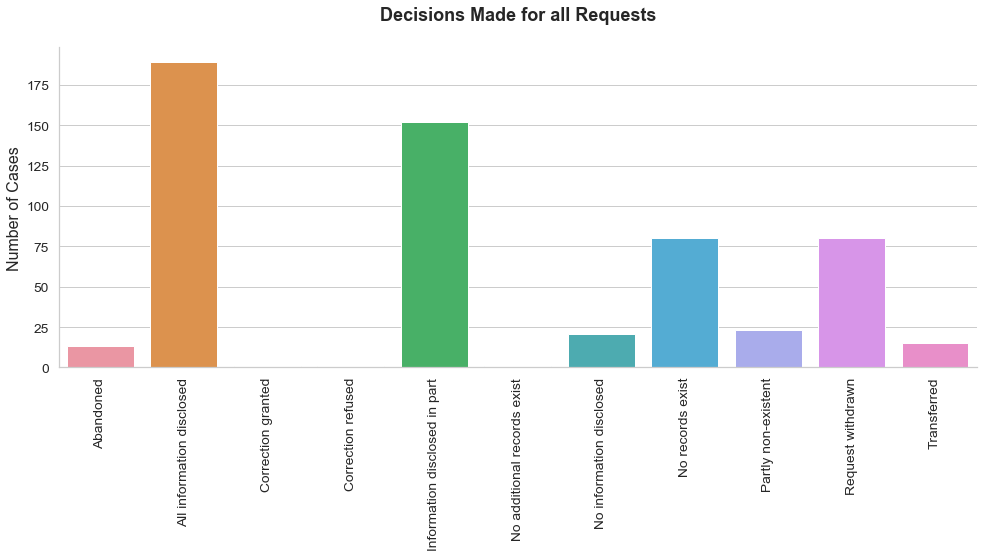

In [3005]:
# Bar plot of all decisions made
columns = list(adf_groupby_Decision.index)

fig, ax = plt.subplots(figsize=(14, 8))

sns.despine()
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.25)

ax = sns.barplot(x=columns, y='Source', data=adf_groupby_Decision)
ax.set_title(label='Decisions Made for all Requests\n', fontweight='bold', size=18)
plt.ylabel('Number of Cases', fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('./img/num_cases_vs_decisions_barplot_all.pdf')

In [2336]:
# Let's create a matrix of Decision vs Source

# Source Type:
# Business                    198 
# Individual                  172 
# Individual by Agent         166 
# Media                        20 
# Business by Agent            19 
# Individual for dependant      1

df_by_Decision = {}

source_types = []
for i in range (0, len(adf.Source.unique())):
    source_types.append(adf.Source.unique()[i])

decision_types = []
for i in range (0, len(adf.Decision.unique())):
    decision_types.append(adf.Decision.unique()[i])

counter = 0

for source in source_types:
    temp_df = adf[adf['Source'] == source].groupby('Decision').count()[['Source']]
    df_by_Decision[counter] = temp_df.T    # Transpose
    if len(df_by_Decision[counter].columns) != len(decision_types):
        for column in decision_types:
            if column not in df_by_Decision[counter].columns:
                df_by_Decision[counter][column] = 0

    df_by_Decision[counter].rename(index={'Source': source}, inplace=True)
    df_by_Decision[counter].rename
    counter += 1

df_by_Decision = pd.concat(df_by_Decision, sort=True)

df_by_Decision


Abandoned  All information disclosed  \
0 Business                          3                         64   
1 Individual                        5                         56   
2 Individual by Agent               4                         63   
3 Business by Agent                 0                          4   
4 Media                             0                          2   
5 Individual for dependant          1                          0   

                            Correction granted  Correction refused  \
0 Business                                   0                   0   
1 Individual                                 1                   1   
2 Individual by Agent                        0                   0   
3 Business by Agent                          0                   0   
4 Media                                      0                   0   
5 Individual for dependant                   0                   0   

                            Information disclosed in part  \
0 Business                                             36   
1 Individual                                           45   
2 Individual by Agent                                  56   
3 Business by Agent                                     6   
4 Media                                                 9   
5 Individual for dependant                              0   

                            No additional records exist  \
0 Business                                            0   
1 Individual                                          1   
2 Individual by Agent                                 0   
3 Business by Agent                                   0   
4 Media                                               0   
5 Individual for dependant                            0   

                            No information disclosed  No records exist  \
0 Business                                         2                43   
1 Individual                                      10                14   
2 Individual by Agent                              1                20   
3 Business by Agent                                2                 2   
4 Media                                            6                 1   
5 Individual for dependant                         0                 0   

                            Partly non-existent  Request withdrawn  \
0 Business                                   10                 38   
1 Individual                                  9                 23   
2 Individual by Agent                         3                 13   
3 Business by Agent                           0                  5   
4 Media                                       1                  1   
5 Individual for dependant                    0                  0   

                            Transferred  
0 Business                            2  
1 Individual                          7  
2 Individual by Agent                 6  
3 Business by Agent                   0  
4 Media                               0  
5 Individual for dependant            0

We have now created a multi-index array, let's reset index to be the Source.

In [2337]:
df_by_Decision = df_by_Decision.reset_index(level=0, drop=True)

In [2338]:
df_by_Decision

Abandoned  All information disclosed  \
Business                          3                         64   
Individual                        5                         56   
Individual by Agent               4                         63   
Business by Agent                 0                          4   
Media                             0                          2   
Individual for dependant          1                          0   

                          Correction granted  Correction refused  \
Business                                   0                   0   
Individual                                 1                   1   
Individual by Agent                        0                   0   
Business by Agent                          0                   0   
Media                                      0                   0   
Individual for dependant                   0                   0   

                          Information disclosed in part  \
Business                                             36   
Individual                                           45   
Individual by Agent                                  56   
Business by Agent                                     6   
Media                                                 9   
Individual for dependant                              0   

                          No additional records exist  \
Business                                            0   
Individual                                          1   
Individual by Agent                                 0   
Business by Agent                                   0   
Media                                               0   
Individual for dependant                            0   

                          No information disclosed  No records exist  \
Business                                         2                43   
Individual                                      10                14   
Individual by Agent                              1                20   
Business by Agent                                2                 2   
Media                                            6                 1   
Individual for dependant                         0                 0   

                          Partly non-existent  Request withdrawn  Transferred  
Business                                   10                 38            2  
Individual                                  9                 23            7  
Individual by Agent                         3                 13            6  
Business by Agent                           0                  5            0  
Media                                       1                  1            0  
Individual for dependant                    0                  0            0

And in a nice heatmap format,

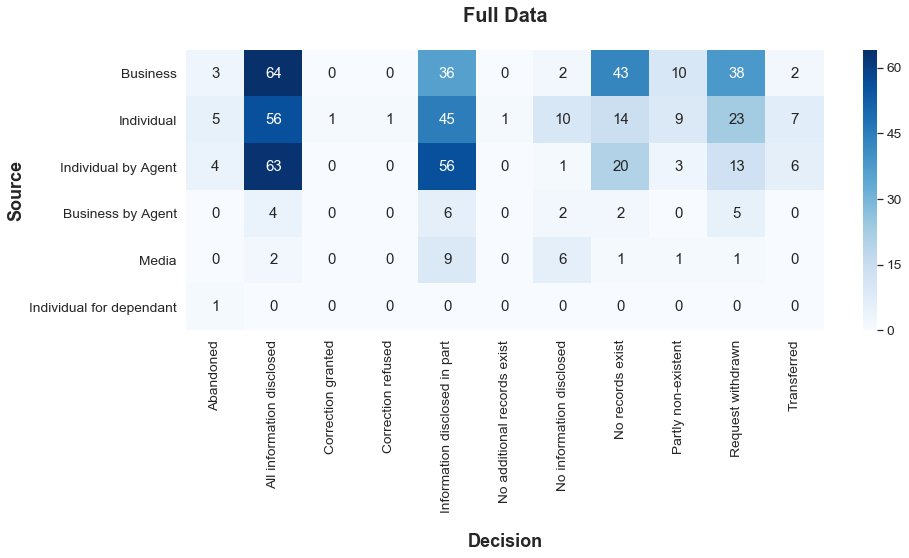

In [2967]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(df_by_Decision, annot=True, fmt='d', cmap='Blues',
            xticklabels=df_by_Decision.columns, yticklabels=df_by_Decision.index)
plt.ylabel('Source', fontweight='bold', fontsize=18)
plt.xlabel('Decision', fontweight='bold', fontsize=18, labelpad=20)
plt.xticks(rotation=90)
ax.set_title(label='Full Data\n', fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('./img/decisions_vs_source_heatmap_num_cases_all.pdf')

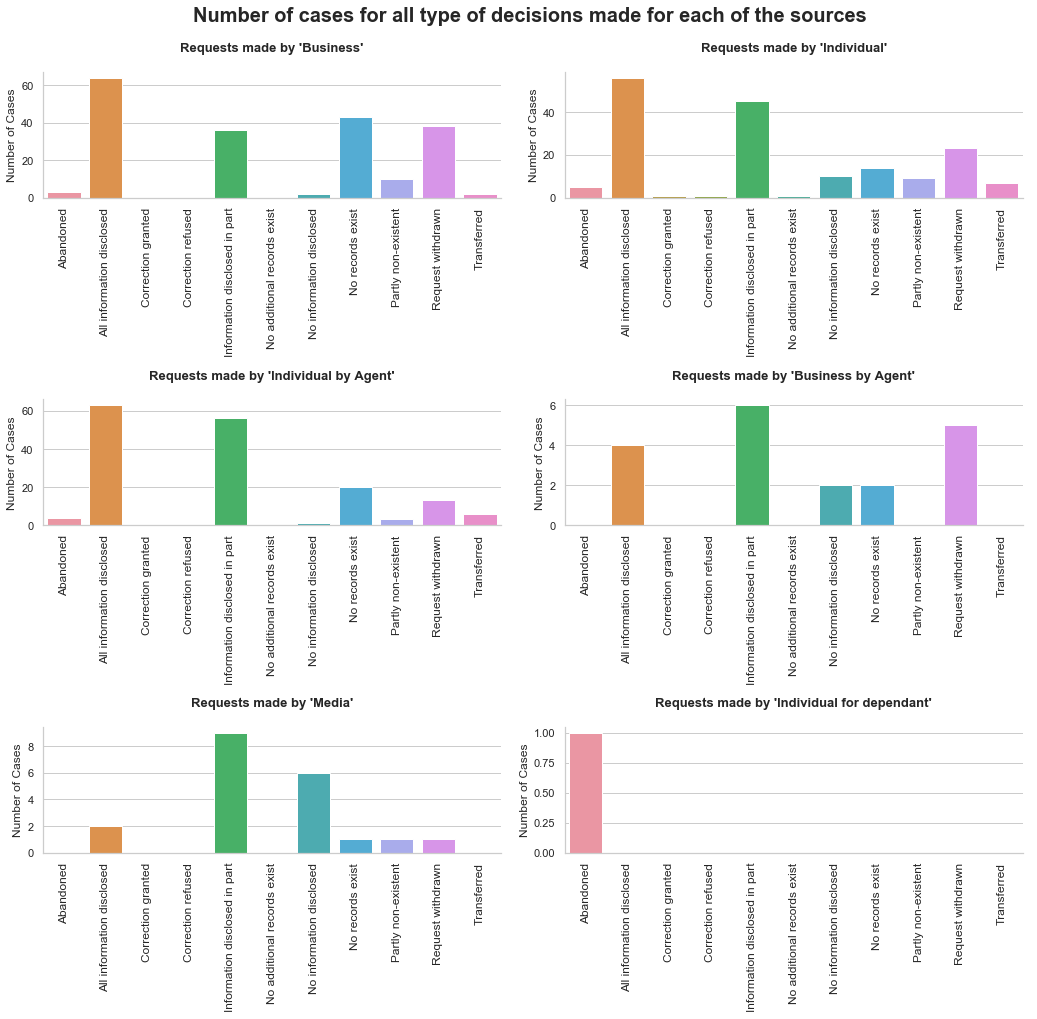

In [2987]:
# Visualizing the data just obtained, for each of the sources

fig, axs = plt.subplots(figsize=(15, 15), frameon=False) 
plt.box(False)
plt.axis('off')
plt.subplots_adjust(hspace = 1.6)
counter = 0

sns.set(style="whitegrid")
sns.set_context("notebook")

for source in source_types:
    ax = fig.add_subplot(3, 2, counter+1)
    sns.despine()
    ax = sns.barplot(data=df_by_Decision[counter: counter + 1])
    plt.ylabel('Number of Cases', fontsize=12)
    ax.set_title(label=str('Requests made by ' + '\'' + source + '\'' + '\n'), fontweight='bold', size=13)
    plt.xticks(rotation=90, fontsize=12)
    counter += 1

axs.set_title(label='Number of cases for all type of decisions made for each of the sources \n\n', 
             fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('./img/num_cases_vs_decision_for_each_source_barplot_all.pdf')


Another useful view from the same data is looking at each type of decision for all the sources (the inverse of what we just did above.)

In [2341]:
# Let's create a matrix of Source vs Decision

df_by_Entity = {}

for decision in decision_types:
    temp_df = adf[adf['Decision'] == decision].groupby('Source').count()[['Decision']]
    df_by_Entity[counter] = temp_df.T
    if len(df_by_Entity[counter].columns) != len(source_types):
        for column in source_types:
            if column not in df_by_Entity[counter].columns:
                df_by_Entity[counter][column] = 0

    df_by_Entity[counter].rename(index={'Decision': decision}, inplace=True)
    df_by_Entity[counter].rename
    counter += 1
    
df_by_Entity = pd.concat(df_by_Entity, sort=True)


In [2342]:
# Resetting index to remove multi-indexing
df_by_Entity = df_by_Entity.reset_index(level=0, drop=True)
df_by_Entity

Business  Business by Agent  Individual  \
Information disclosed in part        36                  6          45   
All information disclosed            64                  4          56   
Request withdrawn                    38                  5          23   
Partly non-existent                  10                  0           9   
Transferred                           2                  0           7   
No records exist                     43                  2          14   
No information disclosed              2                  2          10   
Correction refused                    0                  0           1   
Correction granted                    0                  0           1   
Abandoned                             3                  0           5   
No additional records exist           0                  0           1   

                               Individual by Agent  Individual for dependant  \
Information disclosed in part                   56                         0   
All information disclosed                       63                         0   
Request withdrawn                               13                         0   
Partly non-existent                              3                         0   
Transferred                                      6                         0   
No records exist                                20                         0   
No information disclosed                         1                         0   
Correction refused                               0                         0   
Correction granted                               0                         0   
Abandoned                                        4                         1   
No additional records exist                      0                         0   

                               Media  
Information disclosed in part      9  
All information disclosed          2  
Request withdrawn                  1  
Partly non-existent                1  
Transferred                        0  
No records exist                   1  
No information disclosed           6  
Correction refused                 0  
Correction granted                 0  
Abandoned                          0  
No additional records exist        0

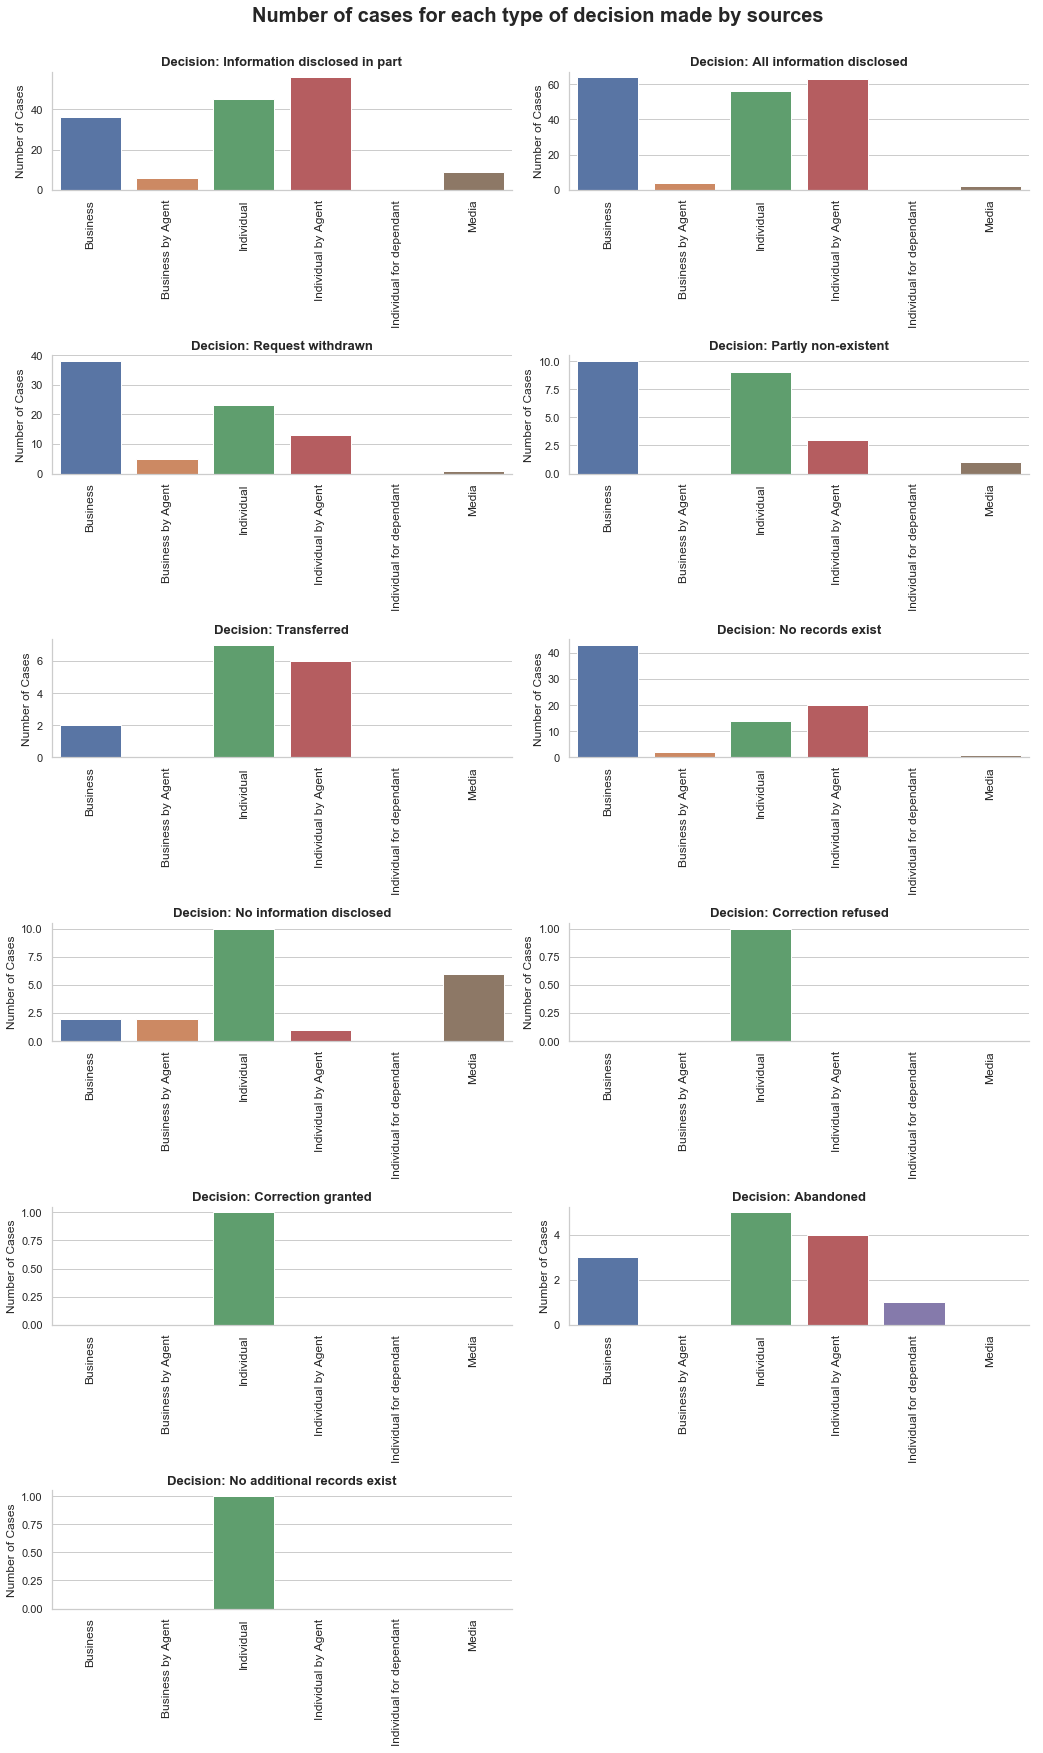

In [2988]:
fig, axs = plt.subplots(figsize=(15, 25), frameon=False) 
plt.box(False)
plt.axis('off')
plt.subplots_adjust(hspace = 1.6)
counter = 0

for decision in decision_types:
    sns.set(style="whitegrid")
    ax = fig.add_subplot(6, 2, counter+1)
    sns.despine()
    ax = sns.barplot(data=df_by_Entity[counter: counter + 1])
    plt.ylabel('Number of Cases', fontsize=12)
    ax.set_title(label=str('Decision: ' + decision), fontweight='bold', size=13)
    plt.xticks(rotation=90, fontsize=12)
    counter += 1

axs.set_title(label='Number of cases for each type of decision made by sources \n\n', 
             fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('./img/num_cases_vs_sources_for_each_decision_barplot_all.pdf')

In [2908]:
norm_rows_df_by_Decision = df_by_Decision.div(df_by_Decision.sum(axis=1), axis=0).round(decimals=2)

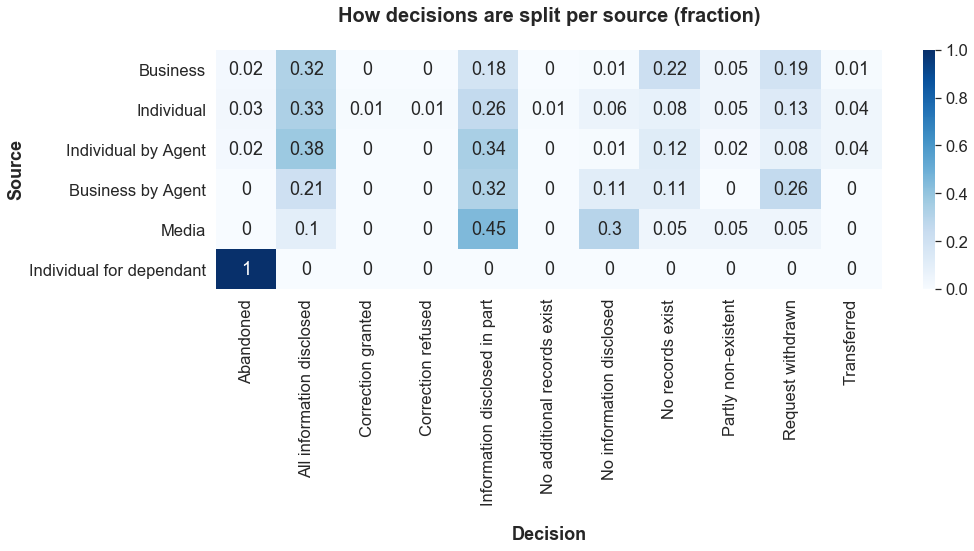

In [3022]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.set_context("notebook", font_scale=1.5)
sns.heatmap(norm_rows_df_by_Decision, annot=True, fmt='0.2g', cmap='Blues',
            xticklabels=norm_rows_df_by_Decision.columns, yticklabels=norm_rows_df_by_Decision.index)

plt.ylabel('Source', fontweight='bold', fontsize=18)
plt.xlabel('Decision', fontweight='bold', fontsize=18, labelpad=20)
plt.xticks(rotation=90)
ax.set_title(label='How decisions are split per source (fraction)\n', fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('./img/decisions_split_per_source_most_used_cases_percent.pdf')


In [2909]:
norm_cols_df_by_Decision = df_by_Decision.div(df_by_Decision.sum(axis=0), axis=1).round(decimals=2)

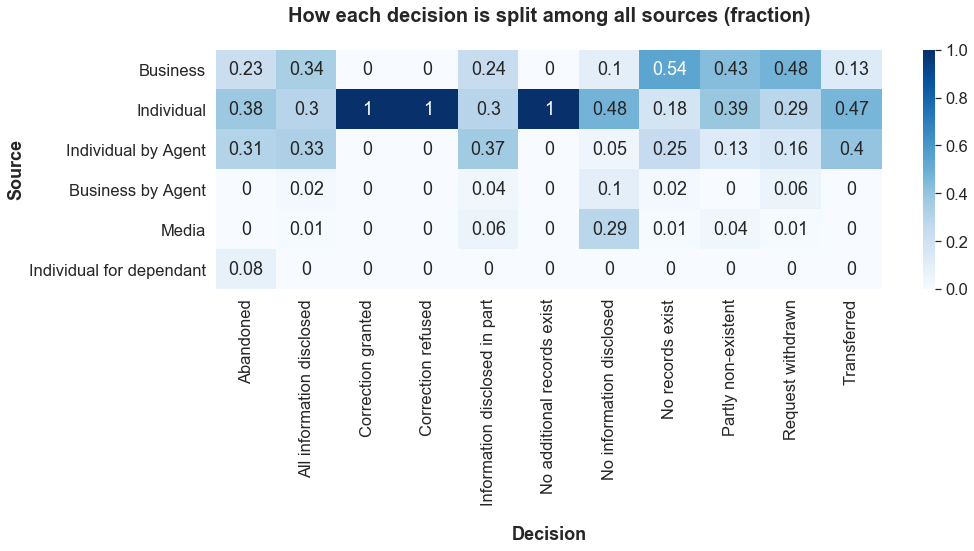

In [3026]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.set_context("notebook", font_scale=1.5)
sns.heatmap(norm_cols_df_by_Decision, annot=True, fmt='0.2g', cmap='Blues',
            xticklabels=norm_cols_df_by_Decision.columns, yticklabels=norm_cols_df_by_Decision.index)

plt.ylabel('Source', fontweight='bold', fontsize=18)
plt.xlabel('Decision', fontweight='bold', fontsize=18, labelpad=20)
ax.set_title(label='How each decision is split among all sources (fraction)\n', fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('./img/decision_split_among_sources_most_used_cases.pdf')





Another approach could be to drop the columns where there is no decision made. Meaning, when it was not on the hands of the person granting a decision, such as a request withdrawn or abandoned. It is important to note that the subset is still unbalanced.

In [2344]:
sub_df_by_Decision = df_by_Decision.drop(columns=['Abandoned', 'Correction granted', 'Correction refused',
                                                'No additional records exist', 'No records exist', 
                                                'Partly non-existent', 'Request withdrawn', 'Transferred'])


In [2345]:
sub_df_by_Decision

All information disclosed  \
Business                                         64   
Individual                                       56   
Individual by Agent                              63   
Business by Agent                                 4   
Media                                             2   
Individual for dependant                          0   

                          Information disclosed in part  \
Business                                             36   
Individual                                           45   
Individual by Agent                                  56   
Business by Agent                                     6   
Media                                                 9   
Individual for dependant                              0   

                          No information disclosed  
Business                                         2  
Individual                                      10  
Individual by Agent                              1  
Business by Agent                                2  
Media                                            6  
Individual for dependant                         0

In [2346]:
# Normalizing the subset by row - that is, each row (source) adds up to 100%
norm_sub_df_by_Decision = sub_df_by_Decision.div(sub_df_by_Decision.sum(axis=1), axis=0)
norm_sub_df_by_Decision

All information disclosed  \
Business                                   0.627451   
Individual                                 0.504505   
Individual by Agent                        0.525000   
Business by Agent                          0.333333   
Media                                      0.117647   
Individual for dependant                        NaN   

                          Information disclosed in part  \
Business                                       0.352941   
Individual                                     0.405405   
Individual by Agent                            0.466667   
Business by Agent                              0.500000   
Media                                          0.529412   
Individual for dependant                            NaN   

                          No information disclosed  
Business                                  0.019608  
Individual                                0.090090  
Individual by Agent                       0.008333  
Business by Agent                         0.166667  
Media                                     0.352941  
Individual for dependant                       NaN

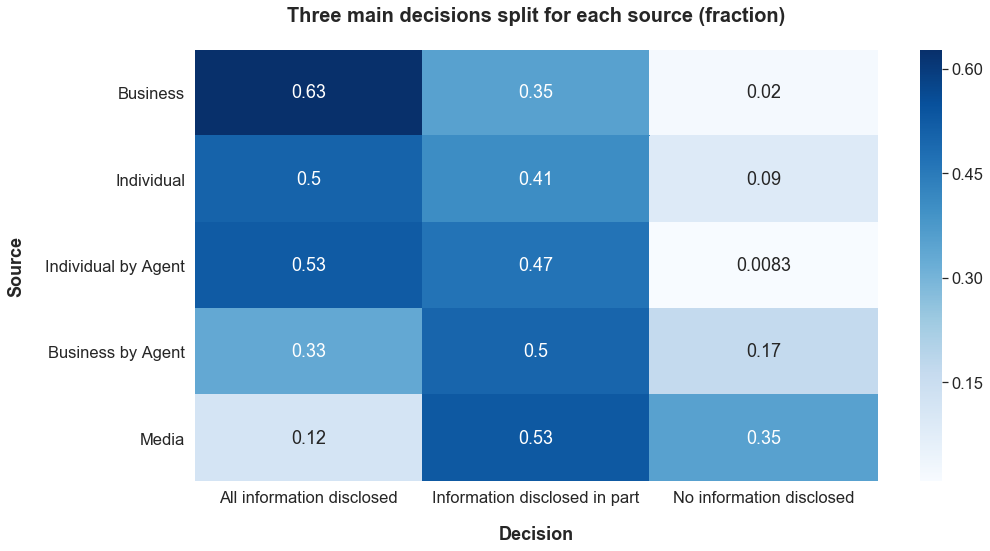

In [3033]:
#sns.set_palette("husl")
sns.set_palette("deep")
fig, ax = plt.subplots(figsize=(15, 8))
sns.set_context("notebook", font_scale=1.5)
sns.heatmap(norm_sub_df_by_Decision, annot=True, fmt='0.2g', cmap='Blues',
            xticklabels=norm_sub_df_by_Decision.columns, yticklabels=norm_sub_df_by_Decision.index)

plt.ylabel('Source', fontweight='bold', fontsize=18, labelpad=20)
plt.xlabel('Decision', fontweight='bold', fontsize=18, labelpad=20)
ax.set_title(label='Three main decisions split for each source (fraction)\n', fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('./img/three_main_decisions_split_for_each_source_heatmap.pdf')

With this view, one sees that business do better, followed by individuals by agent. Media, having few requests, does not do well.

And looking at the same data but with some stacked or grouped bar plots!

In [2349]:
norm_sub_df_by_Decision

All information disclosed  \
Business                                   0.627451   
Individual                                 0.504505   
Individual by Agent                        0.525000   
Business by Agent                          0.333333   
Media                                      0.117647   
Individual for dependant                        NaN   

                          Information disclosed in part  \
Business                                       0.352941   
Individual                                     0.405405   
Individual by Agent                            0.466667   
Business by Agent                              0.500000   
Media                                          0.529412   
Individual for dependant                            NaN   

                          No information disclosed  
Business                                  0.019608  
Individual                                0.090090  
Individual by Agent                       0.008333  
Business by Agent                         0.166667  
Media                                     0.352941  
Individual for dependant                       NaN

In [2350]:
# Individual for dependent does not have any of these cases.
norm_sub_df_by_Decision = norm_sub_df_by_Decision.drop('Individual for dependant')

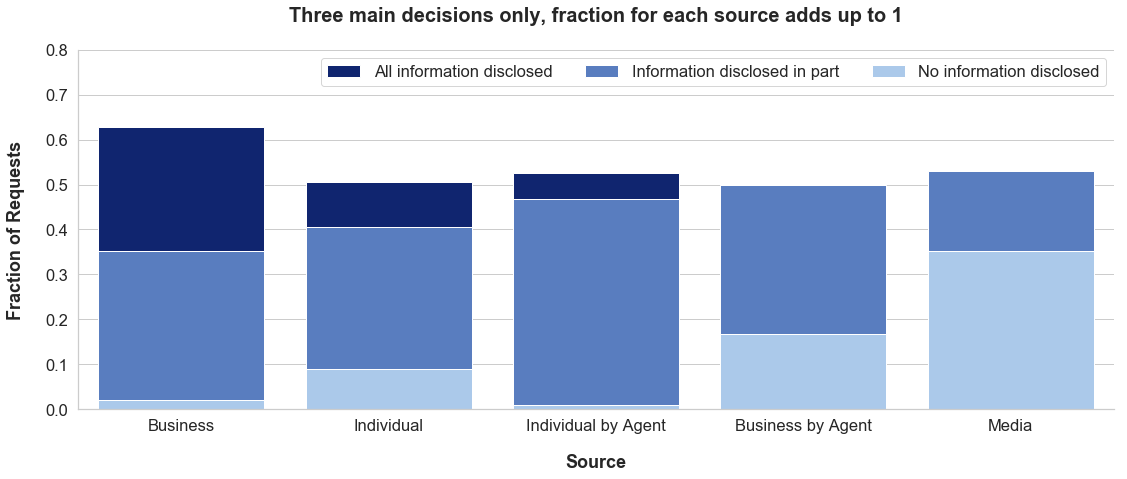

In [3038]:
categ = list(norm_sub_df_by_Decision.index)

f, ax = plt.subplots(figsize=(16, 7))

sns.set_color_codes('dark')
sns.set_context("notebook", font_scale=1.5)
sns.barplot(y='All information disclosed', x=categ, data=norm_sub_df_by_Decision,
            label='All information disclosed', color="b")

sns.set_color_codes('muted')
sns.barplot(y='Information disclosed in part', x=categ, data=norm_sub_df_by_Decision,
            label='Information disclosed in part', color="b")

sns.set_color_codes('pastel')
sns.barplot(y='No information disclosed', x=categ, data=norm_sub_df_by_Decision,
            label='No information disclosed', color="b")

ax.legend(ncol=3, loc="upper right", frameon=True)
plt.ylabel('Fraction of Requests', fontweight='bold', fontsize=18, labelpad=20)
plt.xlabel('Source', fontweight='bold', fontsize=18, labelpad=20)
ax.set(ylim=(0, 0.8))
ax.set_title(label='Three main decisions only, fractions for each source add to 1\n', fontweight='bold', size=20)
sns.despine(right=True, top=True)

plt.tight_layout()
plt.savefig('./img/three_main_decisions_split_for_each_source_stacked_barplot.pdf')

In [2352]:
norm_sub_df_by_Decision

All information disclosed  Information disclosed in part  \
Business                              0.627451                       0.352941   
Individual                            0.504505                       0.405405   
Individual by Agent                   0.525000                       0.466667   
Business by Agent                     0.333333                       0.500000   
Media                                 0.117647                       0.529412   

                     No information disclosed  
Business                             0.019608  
Individual                           0.090090  
Individual by Agent                  0.008333  
Business by Agent                    0.166667  
Media                                0.352941

In [2353]:
norm_sub_df_by_Decision['All information disclosed'].values.tolist()

[0.6274509803921569,
 0.5045045045045045,
 0.525,
 0.3333333333333333,
 0.11764705882352941]

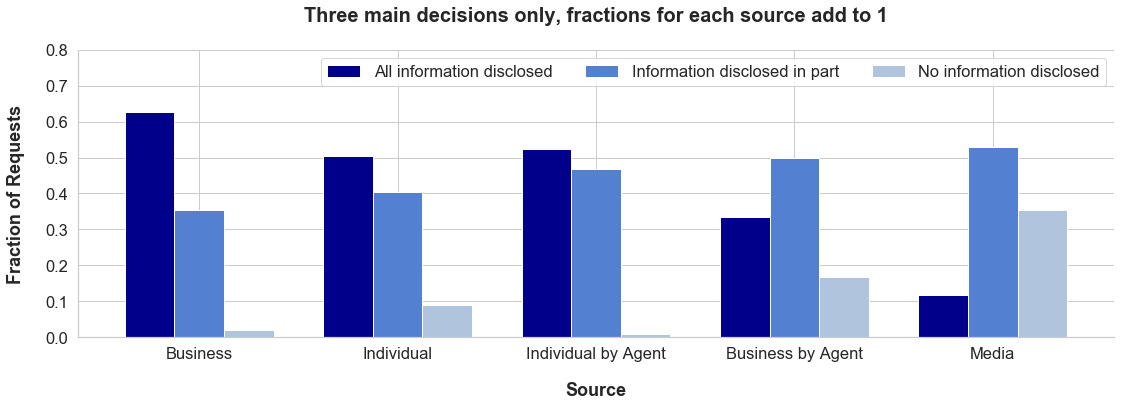

In [3039]:
categ = list(norm_sub_df_by_Decision.index)

fig, ax = plt.subplots(figsize=(16, 6))

# Set width of bar
barWidth = 0.25
 
# Set height of bar
bars1 = norm_sub_df_by_Decision['All information disclosed'].values.tolist()
bars2 = norm_sub_df_by_Decision['Information disclosed in part'].values.tolist()
bars3 = norm_sub_df_by_Decision['No information disclosed'].values.tolist()

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='darkblue', width=barWidth, edgecolor='white', label='All information disclosed')
plt.bar(r2, bars2, color='#5480d2', width=barWidth, edgecolor='white', label='Information disclosed in part')
plt.bar(r3, bars3, color='#b0c4de', width=barWidth, edgecolor='white', label='No information disclosed')

# Add xticks on the middle of the group bars
plt.xlabel('Source', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], categ)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
 
# Create legend & Show graphic
ax.legend(ncol=3, loc="upper right", frameon=True)
plt.ylabel('Fraction of Requests', fontweight='bold', fontsize=18, labelpad=20)
plt.xlabel('Source', fontweight='bold', fontsize=18, labelpad=20)
ax.set(ylim=(0, 0.8))
ax.set_title(label='Three main decisions only, fractions for each source add to 1\n', fontweight='bold', size=20)
sns.despine(right=True, top=True)
plt.tight_layout()
plt.savefig('./img/three_main_decisions_split_for_each_source_sidebyside_barplots.pdf')

There are some interesting features in these plots. 

- Business get the most cases where the information is fully disclosed and the least with no disclosed information.
- Media is the other way around. 
- Individuals by Agent fare better than individuals without one, however, the opposite is true for business and business by agents.



And another view for the same data can be done by exchanging the axes, i.e., by finding the source for each of the decisions. We need to start the table form scratch, to drop the rows where the decision was not made by the clerks.

In [2355]:
sub_df_by_Entity = df_by_Entity.drop(['Abandoned', 'Correction granted', 'Correction refused',
                                                'No additional records exist', 'No records exist', 
                                                'Partly non-existent', 'Request withdrawn', 'Transferred'], axis=0)
sub_df_by_Entity = sub_df_by_Entity.drop(columns='Individual for dependant')

In [2356]:
sub_df_by_Entity

Business  Business by Agent  Individual  \
Information disclosed in part        36                  6          45   
All information disclosed            64                  4          56   
No information disclosed              2                  2          10   

                               Individual by Agent  Media  
Information disclosed in part                   56      9  
All information disclosed                       63      2  
No information disclosed                         1      6

In [2357]:
# Normalizing by row, i.e, by type of decision. Decisions add up to 100%
norm_sub_df_by_Entity = sub_df_by_Entity.div(sub_df_by_Entity.sum(axis=1), axis=0)

In [2358]:
norm_sub_df_by_Entity

Business  Business by Agent  Individual  \
Information disclosed in part  0.236842           0.039474    0.296053   
All information disclosed      0.338624           0.021164    0.296296   
No information disclosed       0.095238           0.095238    0.476190   

                               Individual by Agent     Media  
Information disclosed in part             0.368421  0.059211  
All information disclosed                 0.333333  0.010582  
No information disclosed                  0.047619  0.285714

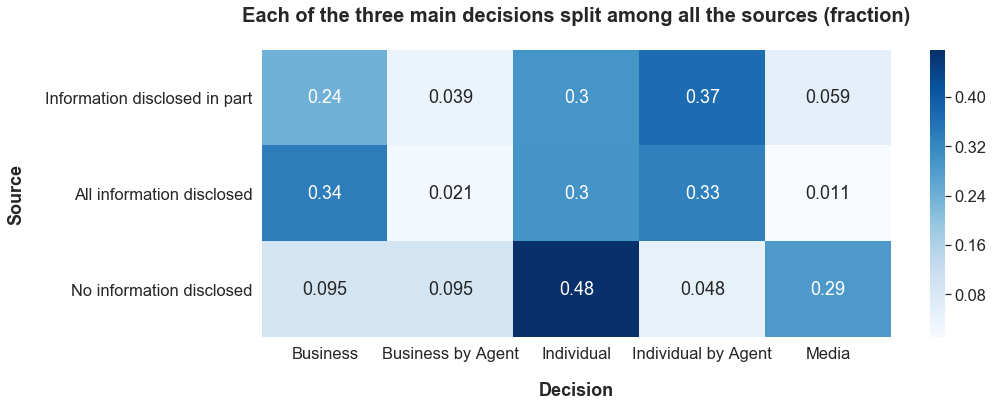

In [3046]:
# Decisions add up to 100%
'''
plt.figure(figsize=(10, 6))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 3.5, "lines.markersize": 12.0})
ax = sns.lineplot(data=norm_sub_df_by_Entity.T, markers=True)
ax.set(ylabel='Number of Cases', title='Each type of Decision adds to 100%')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
'''

fig, ax = plt.subplots(figsize=(15, 6))
sns.set_context("notebook", font_scale=1.5)
sns.heatmap(data=norm_sub_df_by_Entity, annot=True, fmt='0.2g', cmap='Blues',
            xticklabels=norm_sub_df_by_Entity.columns, yticklabels=norm_sub_df_by_Entity.index)

plt.ylabel('Source', fontweight='bold', fontsize=18, labelpad=20)
plt.xlabel('Decision', fontweight='bold', fontsize=18, labelpad=20)
ax.set_title(label='Each of the three main decisions split among all the sources (fraction)\n', 
             fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('./img/three_main_decisions_split_among_all_sources_heatmap.pdf')




- Of the requests where all the information was disclosed, 34% belong to business, 33% to individuals by agents, and 30% to individuals by agents.
- For partially disclosed information, 37% were for individuals by agents, 30% for individuals, and 24% for businesses. 
- Almost 50% of the requests where no information was disclosed were made by individuals, and 29% were made by the media. 

Now, doing a grouped bar plot for all the decisions.

In [2361]:
df_by_Decision

Abandoned  All information disclosed  \
Business                          3                         64   
Individual                        5                         56   
Individual by Agent               4                         63   
Business by Agent                 0                          4   
Media                             0                          2   
Individual for dependant          1                          0   

                          Correction granted  Correction refused  \
Business                                   0                   0   
Individual                                 1                   1   
Individual by Agent                        0                   0   
Business by Agent                          0                   0   
Media                                      0                   0   
Individual for dependant                   0                   0   

                          Information disclosed in part  \
Business                                             36   
Individual                                           45   
Individual by Agent                                  56   
Business by Agent                                     6   
Media                                                 9   
Individual for dependant                              0   

                          No additional records exist  \
Business                                            0   
Individual                                          1   
Individual by Agent                                 0   
Business by Agent                                   0   
Media                                               0   
Individual for dependant                            0   

                          No information disclosed  No records exist  \
Business                                         2                43   
Individual                                      10                14   
Individual by Agent                              1                20   
Business by Agent                                2                 2   
Media                                            6                 1   
Individual for dependant                         0                 0   

                          Partly non-existent  Request withdrawn  Transferred  
Business                                   10                 38            2  
Individual                                  9                 23            7  
Individual by Agent                         3                 13            6  
Business by Agent                           0                  5            0  
Media                                       1                  1            0  
Individual for dependant                    0                  0            0

In [2362]:
# Normalizing the subset by row - that is, each row (source) adds up to 100%
norm_df_by_Decision = df_by_Decision.div(df_by_Decision.sum(axis=1), axis=0)
norm_df_by_Decision = norm_df_by_Decision.drop('Individual for dependant')
norm_df_by_Decision

Abandoned  All information disclosed  Correction granted  \
Business              0.015152                   0.323232            0.000000   
Individual            0.029070                   0.325581            0.005814   
Individual by Agent   0.024096                   0.379518            0.000000   
Business by Agent     0.000000                   0.210526            0.000000   
Media                 0.000000                   0.100000            0.000000   

                     Correction refused  Information disclosed in part  \
Business                       0.000000                       0.181818   
Individual                     0.005814                       0.261628   
Individual by Agent            0.000000                       0.337349   
Business by Agent              0.000000                       0.315789   
Media                          0.000000                       0.450000   

                     No additional records exist  No information disclosed  \
Business                                0.000000                  0.010101   
Individual                              0.005814                  0.058140   
Individual by Agent                     0.000000                  0.006024   
Business by Agent                       0.000000                  0.105263   
Media                                   0.000000                  0.300000   

                     No records exist  Partly non-existent  Request withdrawn  \
Business                     0.217172             0.050505           0.191919   
Individual                   0.081395             0.052326           0.133721   
Individual by Agent          0.120482             0.018072           0.078313   
Business by Agent            0.105263             0.000000           0.263158   
Media                        0.050000             0.050000           0.050000   

                     Transferred  
Business                0.010101  
Individual              0.040698  
Individual by Agent     0.036145  
Business by Agent       0.000000  
Media                   0.000000

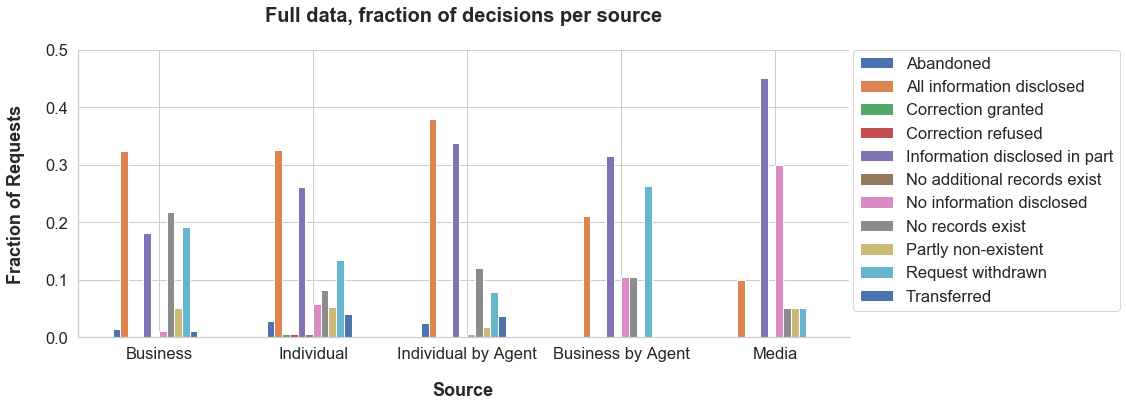

In [3054]:
categ = list(norm_df_by_Decision.index)

dec_norm_df_by_Decision = norm_df_by_Decision.columns.values.tolist()

fig, ax = plt.subplots(figsize=(16, 6))

# Set width of bar
barWidth = 0.05

bars = []
 
# Set height of bar
for dec in dec_norm_df_by_Decision:
    bars.append(norm_df_by_Decision[dec])

rs = []
r = np.arange(len(bars[0]))
rs.append(r)
# Set position of bar on X axis
for bw in range(1, len(bars)):
    rn = [x + barWidth for x in r]
    rs.append(rn)
    r = rn
    
# Make the plot
counter = 0

for dec in dec_norm_df_by_Decision:
    plt.bar(rs[counter], bars[counter], width=barWidth, edgecolor='white', label=dec)
    counter += 1

# Add xticks on the middle of the group bars
center_lb = len(dec_norm_df_by_Decision)/2
plt.xticks([r + center_lb*barWidth for r in range(len(bars[0]))], categ)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

 
# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.xlabel('Source', fontweight='bold', labelpad=20)
plt.ylabel('Fraction of Requests', fontweight='bold', fontsize=18, labelpad=20)
plt.ylim(0, 0.5)
ax.set_title(label='Full data, fraction of decisions per source\n', fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('./img/percentage_decisions_vs_source_barplot_sidebyside_all.pdf')


And if we drop decisions that have less than 15 instances:

In [2364]:
norm_df_by_Decision_over15 = df_by_Decision.copy()

dec_norm_df_by_Decision_over15 = norm_df_by_Decision_over15.columns.values.tolist()

todrop = []

for dec in dec_norm_df_by_Decision_over15:
    if norm_df_by_Decision_over15[dec].sum(axis=0) < 15:
        todrop.append(dec)

for decs in todrop:
    norm_df_by_Decision_over15 = norm_df_by_Decision_over15.drop(columns=decs)

norm_df_by_Decision_over15      
    

All information disclosed  \
Business                                         64   
Individual                                       56   
Individual by Agent                              63   
Business by Agent                                 4   
Media                                             2   
Individual for dependant                          0   

                          Information disclosed in part  \
Business                                             36   
Individual                                           45   
Individual by Agent                                  56   
Business by Agent                                     6   
Media                                                 9   
Individual for dependant                              0   

                          No information disclosed  No records exist  \
Business                                         2                43   
Individual                                      10                14   
Individual by Agent                              1                20   
Business by Agent                                2                 2   
Media                                            6                 1   
Individual for dependant                         0                 0   

                          Partly non-existent  Request withdrawn  Transferred  
Business                                   10                 38            2  
Individual                                  9                 23            7  
Individual by Agent                         3                 13            6  
Business by Agent                           0                  5            0  
Media                                       1                  1            0  
Individual for dependant                    0                  0            0

In [2365]:
# Normalizing the subset by row - that is, each row (source) adds up to 100%
norm_df_by_Decision_over15 = norm_df_by_Decision_over15.drop('Individual for dependant')
norm_df_by_Decision_over15 = norm_df_by_Decision_over15.div(norm_df_by_Decision_over15.sum(axis=1), axis=0)
norm_df_by_Decision_over15

All information disclosed  Information disclosed in part  \
Business                              0.328205                       0.184615   
Individual                            0.341463                       0.274390   
Individual by Agent                   0.388889                       0.345679   
Business by Agent                     0.210526                       0.315789   
Media                                 0.100000                       0.450000   

                     No information disclosed  No records exist  \
Business                             0.010256          0.220513   
Individual                           0.060976          0.085366   
Individual by Agent                  0.006173          0.123457   
Business by Agent                    0.105263          0.105263   
Media                                0.300000          0.050000   

                     Partly non-existent  Request withdrawn  Transferred  
Business                        0.051282           0.194872     0.010256  
Individual                      0.054878           0.140244     0.042683  
Individual by Agent             0.018519           0.080247     0.037037  
Business by Agent               0.000000           0.263158     0.000000  
Media                           0.050000           0.050000     0.000000

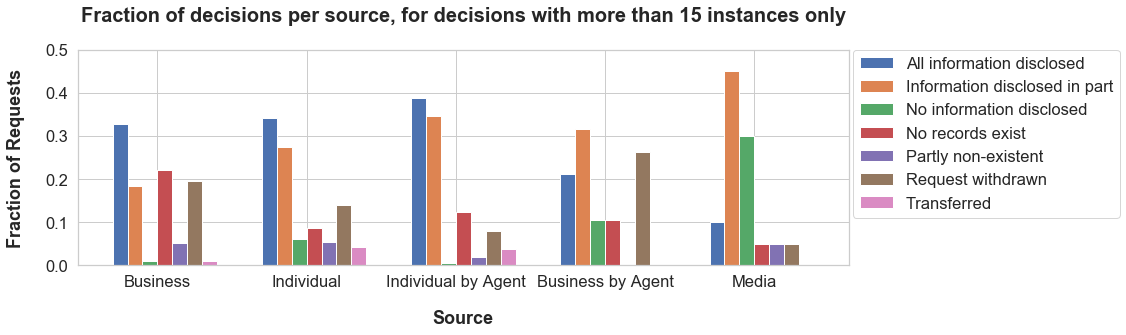

In [3057]:
categ = list(norm_df_by_Decision_over15.index)

dec_norm_df_by_Decision_over15 = norm_df_by_Decision_over15.columns.values.tolist()

fig, ax = plt.subplots(figsize=(16, 5))

# Set width of bar
barWidth = 0.1

bars = []
 
# Set height of bar
for dec in dec_norm_df_by_Decision_over15:
    bars.append(norm_df_by_Decision_over15[dec])

rs = []
r = np.arange(len(bars[0]))
rs.append(r)
# Set position of bar on X axis
for bw in range(1, len(bars)):
    rn = [x + barWidth for x in r]
    rs.append(rn)
    r = rn
    
# Make the plot
counter = 0

for dec in dec_norm_df_by_Decision_over15:
    plt.bar(rs[counter], bars[counter], width=barWidth, edgecolor='white', label=dec)
    counter += 1

# Add xticks on the middle of the group bars
plt.xlabel('Source', fontweight='bold')
center_lb = len(norm_df_by_Decision_over15)/2
plt.xticks([r + center_lb*barWidth for r in range(len(bars[0]))], categ)
 
# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.xlabel('Source', fontweight='bold', labelpad=20)
plt.ylabel('Fraction of Requests', fontweight='bold', fontsize=18, labelpad=20)
plt.ylim(0, 0.5)
ax.set_title(label='Fraction of decisions per source, for decisions with more than 15 instances only\n',
             fontweight='bold', size=20)
plt.tight_layout()
plt.savefig('./img/percentage_decisions_vs_source_barplot_sidebyside_over15_only.pdf')


Media is the one with the least success. Let's see what type of requests they make.

In [2369]:
media_req = adf[adf['Source'] == 'Media']

for req in range(0, len(media_req)):
    index = media_req.index[req]
    sum_req = media_req.loc[index,'Summary_of_Request']
    dec = media_req.loc[index,'Decision']
    print('Request {0}. Decision: {1}\n{2}\n'.format(req+1, dec, sum_req))

Request 1. Decision: Information disclosed in part
1) Facility Audit; 2) {Company name removed} Consultants report; 3) Finance Department report T2001-128; 4) {company name removed} bus bid for T2002-120; 5) maintenance costs 2001 to 2004 6) Communicated maintenance records 2001 to 2004.

Request 2. Decision: All information disclosed
1) sign out sheets for buses based at 250 Strasburg Road; 2) malfunction cards for those buses; 3) daily work sheets for those buses; 4) records showing how often express buses are used on regular routes;  record range from 2005/8/15 to date.

Request 3. Decision: No records exist
List of all chlorinated solvent sites in the Region of Waterloo and specific solvents found at those sites.

Request 4. Decision: No information disclosed
Resignation letter, records related to the reason for departure, and severance package details for the termination of {name and position removed}.

Request 5. Decision: All information disclosed
Quantity of pesticide used by R

# NLP

Now we proceed to analize the actual *Summary_of_Requests*. For this, we turn to Natural Language Processing libraries, such as NLTK and spaCy, and the help of sklearn.

Broadly generalizing, there are few steps one needs to do before analyzing any text:
- Tokenize the text: Break the text in single words, i.e., tokens.
- Remove any unwanted characters, such as returns (\n), and punctuation, such as "-", "...", "”".
- Remove URLs or replace them by a word, say, "URL".
- Remove screen names or replace the '@' by a word, say, "screen_name".
- Remove capitalization of words.
- Remove words with less than 4 characters.
- Remove "stopwords", i.e., the most common words in a language. These words probably won't help classifying our text, examples are articles such as , 'a', 'the', 'and'. There is no single universal list of stop words.
- Lemmatization, which is the process of grouping together the inflected forms of a word so they can be analyzed as a single item, identified by the word's lemma, or dictionary form.

In [3218]:
import string
import re

import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import spacy
from spacy.lang.en import English

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter    # Look at the most common item in a list

from matplotlib.colors import makeMappingArray

from palettable.colorbrewer.diverging import RdYlBu_4
from palettable.colorbrewer.diverging import Spectral_4
from palettable.colorbrewer.diverging import RdYlGn_4
from palettable.colorbrewer.diverging import PuOr_4
from palettable.colorbrewer.diverging import RdBu_4

from PIL import Image


In [2371]:
parser = English()
wordnet_lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/bertaerodriguez-
[nltk_data]     milla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Generating a larger stop words list, a combination of the stop words of NLTK, scikit learn, and wordcloud. And adding also a symbols list.

In [2372]:
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS) + list(STOPWORDS))
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "``", ",", ".", ":", "''"]

Defining a variety of functions that tokenize, remove white spaces, words with less than three characters, stopwords, and other specified symbols. This version also includes the spaCy lemmatizer.

In [2777]:
def clean_text(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    return text

In [2483]:
def parse_text(text):
    parsed = parser(text)
    return parsed

In [2492]:
def tokenize(parsed_text):
    tokens = []
    for token in parsed_text:
        if token.orth_.isspace():
            continue
        else:
            tokens.append(token)
    return tokens
    

In [2583]:
def replace_urls(tokens):
    tokens_array = []
    for token in tokens:
        if token.like_url:
            new_token = parser('URL')
            tokens_array.append(new_token[0])
        else:
            tokens_array.append(token)
    return tokens_array

In [2622]:
def replace_screen_names(tokens):
    tokens_array = []
    for token in tokens:
        if str(token).startswith('@'):
            new_token = parser('SCREEN_NAME')
            tokens_array.append(new_token[0])
        else:
            tokens_array.append(token)
    return tokens_array

In [2660]:
def lemmatize_tokens(tokens):
    lemmas = []
    for tok in tokens:    # spaCy lemmatization
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    return lemmas

In [2668]:
def remove_short_strings(string_array, length):
    array = []
    for word in string_array:
        if len(word) > length:
            array.append(word)
    return array 

In [2671]:
def remove_stop_words(string_array):
    array = []
    for word in string_array:
        if word not in STOPLIST:
            array.append(word)
    return array

In [2672]:
def remove_symbols(string_array):
    array = []
    for word in string_array:
        if word not in SYMBOLS:
            array.append(word)
    return array

In [2734]:
def convert_to_lowercase(tokens):
    low = []
    for tok in tokens:
        low.append(tok.text.lower().strip())
    return low

Function that gets the lemma of a word using NLTK.

In [2376]:
# NLTK lemma
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma  

Combining the functions, which parses, tokenizes, cleans, lemmatizes, and removes stop words and short words. This function prepares a text in general for NLP. It will serve for our future analysis using LDA and LSA. 

In [2776]:
def prepare_text_tlc(the_text):
    text = clean_text(the_text)
    text = parse_text(text)
    tokens = tokenize(text)
    tokens = replace_urls(tokens)
    tokens = replace_screen_names(tokens)
    tokens = lemmatize_tokens(tokens)
    tokens = remove_short_strings(tokens, 3)
    tokens = remove_stop_words(tokens)
    tokens = remove_symbols(tokens)
    return tokens

And one similar that does not lemmatize or remove stop words and short words from the text.

In [2778]:
def prepare_text_for_pos_tagging(the_text):
    text = clean_text(the_text)
    text = parse_text(text)
    tokens = tokenize(text)
    tokens = replace_urls(tokens)
    tokens = replace_screen_names(tokens)
    tokens = convert_to_lowercase(tokens)
    tokens = remove_symbols(tokens)
    return tokens 

And isolating the summary of requests into a panda series, 

In [2378]:
all_text = adf['Summary_of_Request']
print(all_text[:10])
print("No. of requests {0}".format(len(all_text)))

0    Minutes of Service Delivery Subcommittee of ES...
1    Public Health inspection reports for the {loca...
2    Public Health inspection records for {location...
3    Public Health inspection records for {address ...
4    Vendor list report with total of year-to-date ...
5    Public Health inspection file for {name remove...
6    Scope of work and deliverables sections of con...
7    Number of contracts and dollar amount of contr...
8    Public Health inspection report regarding a co...
9    Phase I environmental site assessment regardin...
Name: Summary_of_Request, dtype: object
No. of requests 576


## N-grams and Word Clouds

With the purpose of finding out which are the most common words (unigrams) and phrases consisting of 2, 3, or n-words (bigrams, trigrams, and n-grams), it is easier if one combines all the words into a single string.

In [2379]:
# Merging all the requests into a single line
all_text_merged = ''
for lines in range(0,len(all_text)):
    all_text_merged = all_text_merged + ' ' + all_text[lines]

Now that we have a single string, let's get the unigrams, bigrams (two consecutive words), and trigrams (three consecutive words.)

In [2715]:
# Preparing text and getting unigrams, bigrams, and trigrams
tokens = prepare_text_tlc(all_text_merged)
unigrams = tokens
bigrams = nltk.bigrams(unigrams)
trigrams = nltk.trigrams(unigrams)

In [2793]:
def display_top_grams(gram, gram_length, num_grams):
    '''
    Displays the top num_grams(number) most frequent 
    occurances of the gram array. 
    Since I will use this function for nltk ngrams,
    I want to know the length of the ngram (gram_length),
    e.g., if we are passing bigrams, the length is 2
    '''
    
    gram_counter = Counter(gram)
    
    if gram_length is 1:
        name = 'unigrams'
    elif gram_length is 2:
        name = 'bigrams'
    elif gram_length is 3:
        name = 'trigrams'
    else:
        name = str(gram_length) + '-grams'
        
    print("No. of unique {0}: {1}".format(name, len(gram_counter)))

    for grams in gram_counter.most_common(num_grams):
        print(grams)
    return None


And showing the top ten most common grams,

In [2792]:
display_top_grams(unigrams, 1, 10)

No. of unique unigrams: 1147
('remove', 284)
('file', 150)
('address', 123)
('removed}.', 123)
('ontario', 121)
('waterloo', 119)
('environmental', 115)
('copy', 110)
('site', 110)
('assessment', 107)


In [2717]:
display_top_grams(bigrams, 2, 10)

No. of unique bigrams: 3420
(('address', 'remove'), 112)
(('ontario', 'works'), 102)
(('environmental', 'site'), 98)
(('site', 'assessment'), 97)
(('phase', 'environmental'), 97)
(('assessment', 'address'), 83)
(('copy', 'ontario'), 81)
(('complete', 'copy'), 78)
(('file', 'removed}.'), 77)
(('client', 'file'), 71)


In [2718]:
display_top_grams(trigrams, 3, 10)

No. of unique trigrams: 4316
(('environmental', 'site', 'assessment'), 97)
(('phase', 'environmental', 'site'), 96)
(('site', 'assessment', 'address'), 82)
(('assessment', 'address', 'remove'), 80)
(('copy', 'ontario', 'works'), 79)
(('complete', 'copy', 'ontario'), 72)
(('ontario', 'works', 'client'), 67)
(('works', 'client', 'file'), 66)
(('client', 'file', 'removed}.'), 55)
(('address', 'remove', 'kitchener'), 36)


In [3219]:
def generating_WordCloud(gram, num_words, collocations_TF, mask_icon, color_palette, u_background_color,
                         color_grad_orientation):
    
    gradient_orientation = color_grad_orientation

    icon = Image.open(mask_icon).convert("RGBA")
    mask = Image.new("RGBA", icon_rgba.size, (255,255,255))
    mask.paste(icon, icon)
    mask_wordcloud = np.array(mask)

    # Create a linear gradient using the matplotlib color map
    imgsize = icon.size

    if gradient_orientation == "vertical":
        N_elem = imgsize[0]
    else:
        N_elem = imgsize[1]
        
    palette_colormap = str(color_palette + '.mpl_colormap')


    if color_palette == 'Spectral':
        palette = makeMappingArray(N_elem, Spectral_4.mpl_colormap)   # interpolates colors
    elif color_palette == 'RdYlBu':
        palette = makeMappingArray(N_elem, RdYlBu_4.mpl_colormap)
    elif color_palette == 'RdYlGn':
        palette = makeMappingArray(N_elem, RdYlGn_4.mpl_colormap)
    elif color_palette == 'PuOr':
        palette = makeMappingArray(N_elem, PuOr_4.mpl_colormap)
    elif color_palette == 'RdBu':
        palette = makeMappingArray(N_elem, RdBu_4.mpl_colormap)
    else:
        print ("No such palette")
        return None

    for y in range(imgsize[1]):
        for x in range(imgsize[0]):
            if mask.getpixel((x,y)) != (255,255,255):   # Only change nonwhite pixels of icon
                color = palette[x] if gradient_orientation is "vertical" else palette[y]

                # matplotlib color maps are from range of (0,1). Convert to RGB.
                r = int(color[0] * 255)
                g = int(color[1] * 255)
                b = int(color[2] * 255)

                mask.putpixel((x, y), (r, g, b))

    # create coloring from image
    image_colors = ImageColorGenerator(np.array(mask))

    grams_upper = []
    for token in gram:
        grams_upper.append(token.upper())

    wc = WordCloud(
                   font_path = "/Library/Fonts/DIN Condensed Bold.ttf",
                   mask=cloud_mask,
                   stopwords=STOPLIST,
                   background_color=u_background_color,
                   width=2500,
                   height=1750,
                   collocations=collocations_TF,
                   max_words=num_words,
                   #max_font_size=100,
                   ).generate(" ".join(grams_upper))

    # generate word cloud
    wc.recolor(color_func=image_colors)
    plt.figure(figsize=(10, 7))
    plt.imshow(wc, interpolation="bilinear", aspect='auto')
    plt.axis('off')
    
    return wc

Visualizing the word cloud with a maximum of 100 words

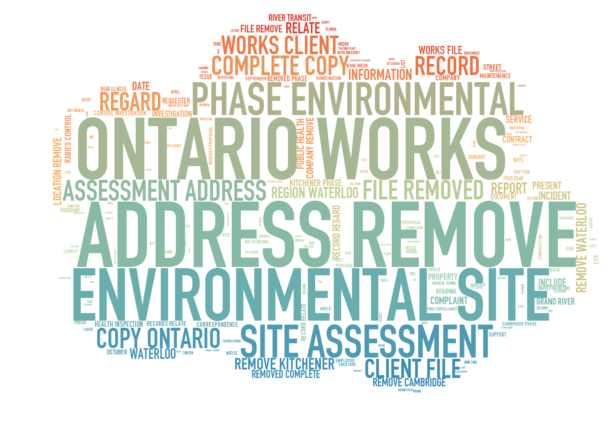

In [3232]:
wc = generating_WordCloud(unigrams, 200, True, "img/cloud_mask.png", 'Spectral', 'white',
                         'horizontal')
wc.to_file("img/wordclouds/wordcloud_200_words_with_bigrams_white_Spectral.pdf")

And with no collocations, this is, with no bigrams, we get something that features the word "remove" quite prominently.

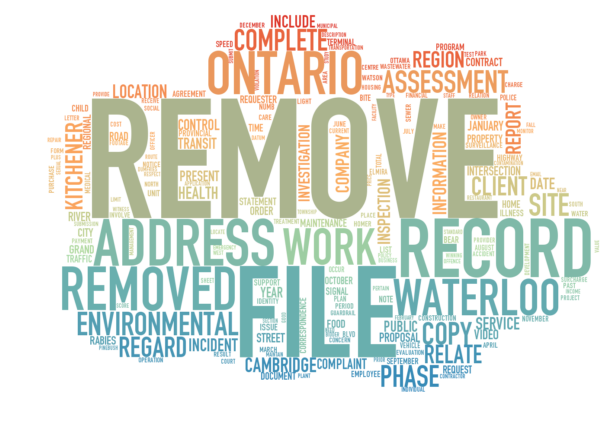

In [3233]:
wc = generating_WordCloud(unigrams, 200, False, "img/cloud_mask.png", 'Spectral', 'white',
                         'horizontal')
wc.to_file("img/wordclouds/wordcloud_200_words_no_bigrams_white_Spectral.pdf")

## N-grams and Word Clouds after removing phrases that include *"{ ... removed}"*

So, why is the word "remove" so important? It turns out, many of these requests have names of people or locations that needed to be removed for privacy reasons. So, let's reprocess the text taking this into account by using regular expressions.

In [2388]:
# {address removed}, {name removed} {names removed} {location removed} {company name removed}
# {intersection removed}
# {request number removed}

new_stop_words = []
regex_phrase = r'(?:\{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\}|\(\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\}|\{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\)|\(\w+\s*removed\)|\{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\{)'
'''
# Somehow splitting the regEx chain changes the output!
regex_phrase = r'(?:\{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\}|\
                  \(\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\}|\
                  \{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\)|\
                  \{\w+\s*\w*\s*\w*\s*\w*\s*\w*\s*\w*\{|\(\w+\s*removed\)|\
                  )'
'''

matches = re.findall(regex_phrase, all_text_merged)
for match in matches:
    #print(match)
    new_stop_words.append(match)

# Change array to a set to remove duplicates
new_stop_words = set(new_stop_words)
# Turn back to a list
new_stop_words = list(new_stop_words)
print("No. of phrases to be removed: {0}".format(len(new_stop_words)))   # 33
print(new_stop_words)
    
    

No. of phrases to be removed: 33
['{request number removed}', '{business removed}', '{company names removed}', '{restaurant removed}', '{addresses removed}', '{name removed}', '{street name removed}', '{company removed}', '{intersection removed}', '(location removed)', '{locations removed}', '{organization name removed}', '{institutions removed}', '{Name removed}', '{address}', '(name removed}', '{company name removed}', '{Company name removed}', '{address removed}', '{names removed}', '{name and position removed}', '{location removed}', '{facility removed}', '(name removed)', '{name removed{', '{date removed}', '{restaurant name removed}', '{developer removed}', '{companies removed}', '{individual by agent}', '{company name and address removed}', '{orgnization name removed}', '(address removed}']


In [2389]:
all_text_merged_removed = all_text_merged

# Replace new stop phrases with nothing
for stop in new_stop_words:
    all_text_merged_removed = all_text_merged_removed.replace(stop, '')
    

So, let's find the unigrams, bigrams, trigrams, and n-grams (4-5 words), and their most commom occurrences, for this new text.

In [2719]:
tokens_rm = prepare_text_tlc(all_text_merged_removed)
unigrams_rm = tokens_rm
bigrams_rm = nltk.bigrams(unigrams_rm)
trigrams_rm = nltk.trigrams(unigrams_rm)
everygrams_rm_4 = nltk.everygrams(unigrams_rm, min_len=4, max_len=4)
everygrams_rm_5 = nltk.everygrams(unigrams_rm, min_len=4, max_len=5)

In [2720]:
display_top_grams(unigrams_rm, 1, 10)

No. of unique unigrams: 1139
('file', 150)
('ontario', 121)
('waterloo', 119)
('environmental', 115)
('copy', 110)
('site', 110)
('assessment', 107)
('record', 104)
('works', 102)
('phase', 99)


In [2721]:
display_top_grams(bigrams_rm, 2, 20)

No. of unique bigrams: 3314
(('ontario', 'works'), 102)
(('environmental', 'site'), 98)
(('site', 'assessment'), 97)
(('phase', 'environmental'), 97)
(('copy', 'ontario'), 84)
(('complete', 'copy'), 78)
(('client', 'file'), 71)
(('works', 'client'), 67)
(('region', 'waterloo'), 45)
(('works', 'file'), 33)
(('assessment', 'kitchener'), 30)
(('file', 'complete'), 28)
(('public', 'health'), 26)
(('assessment', 'waterloo'), 25)
(('record', 'regard'), 24)
(('assessment', 'cambridge'), 22)
(('river', 'transit'), 21)
(('grand', 'river'), 21)
(('kitchener', 'phase'), 20)
(('rabies', 'control'), 19)


In [2722]:
display_top_grams(trigrams_rm, 3, 20)

No. of unique trigrams: 4062
(('environmental', 'site', 'assessment'), 97)
(('phase', 'environmental', 'site'), 96)
(('copy', 'ontario', 'works'), 81)
(('complete', 'copy', 'ontario'), 74)
(('ontario', 'works', 'client'), 67)
(('works', 'client', 'file'), 66)
(('ontario', 'works', 'file'), 33)
(('site', 'assessment', 'kitchener'), 30)
(('file', 'complete', 'copy'), 24)
(('site', 'assessment', 'cambridge'), 22)
(('site', 'assessment', 'waterloo'), 22)
(('grand', 'river', 'transit'), 21)
(('kitchener', 'phase', 'environmental'), 20)
(('assessment', 'kitchener', 'phase'), 18)
(('public', 'health', 'inspection'), 16)
(('rabies', 'control', 'investigation'), 14)
(('waterloo', 'phase', 'environmental'), 13)
(('client', 'file', 'complete'), 13)
(('works', 'file', 'complete'), 12)
(('food', 'bear', 'illness'), 12)


In [2723]:
display_top_grams(everygrams_rm_4, 4, 10)

No. of unique 4-grams: 4396
(('phase', 'environmental', 'site', 'assessment'), 96)
(('complete', 'copy', 'ontario', 'works'), 72)
(('ontario', 'works', 'client', 'file'), 66)
(('copy', 'ontario', 'works', 'client'), 59)
(('environmental', 'site', 'assessment', 'kitchener'), 30)
(('file', 'complete', 'copy', 'ontario'), 23)
(('environmental', 'site', 'assessment', 'waterloo'), 22)
(('copy', 'ontario', 'works', 'file'), 22)
(('environmental', 'site', 'assessment', 'cambridge'), 22)
(('kitchener', 'phase', 'environmental', 'site'), 20)


In [2724]:
display_top_grams(everygrams_rm_5, 5, 20)

No. of unique 5-grams: 9014
(('phase', 'environmental', 'site', 'assessment'), 96)
(('complete', 'copy', 'ontario', 'works'), 72)
(('ontario', 'works', 'client', 'file'), 66)
(('copy', 'ontario', 'works', 'client', 'file'), 59)
(('copy', 'ontario', 'works', 'client'), 59)
(('complete', 'copy', 'ontario', 'works', 'client'), 51)
(('environmental', 'site', 'assessment', 'kitchener'), 30)
(('phase', 'environmental', 'site', 'assessment', 'kitchener'), 30)
(('file', 'complete', 'copy', 'ontario'), 23)
(('file', 'complete', 'copy', 'ontario', 'works'), 23)
(('environmental', 'site', 'assessment', 'cambridge'), 22)
(('phase', 'environmental', 'site', 'assessment', 'waterloo'), 22)
(('environmental', 'site', 'assessment', 'waterloo'), 22)
(('copy', 'ontario', 'works', 'file'), 22)
(('phase', 'environmental', 'site', 'assessment', 'cambridge'), 22)
(('complete', 'copy', 'ontario', 'works', 'file'), 21)
(('kitchener', 'phase', 'environmental', 'site', 'assessment'), 20)
(('kitchener', 'phase', 

And just for the fun of visualizing it, wordclouds!

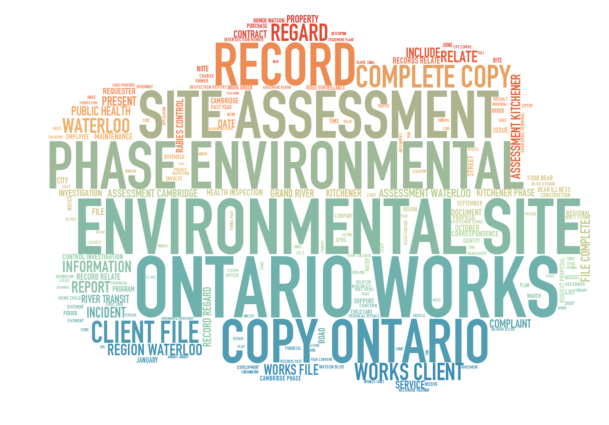

In [3237]:
wc = generating_WordCloud(unigrams_rm, 200, True, "img/cloud_mask.png", 'Spectral', 'white',
                         'horizontal')
wc.to_file("img/wordclouds/wordcloud_200_words_removed_with_bigrams_white_Spectral.pdf")

And without bigrams:

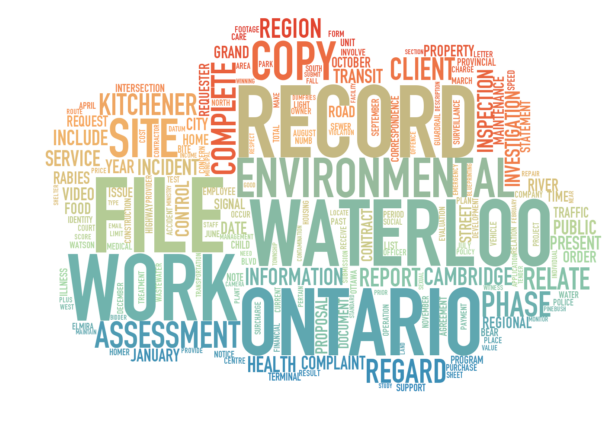

In [3236]:
wc = generating_WordCloud(unigrams_rm, 200, False, "img/cloud_mask.png", 'Spectral', 'white',
                         'horizontal')
wc.to_file("img/wordclouds/wordcloud_200_words_removed_no_bigrams_white_Spectral.pdf")

## Most-used Phrases and Decisions

Looking at the n-grams, one finds phrases that commonly appear throughout the requests:

- "ontario works" appears in 8 out of the top 20 n-grams.
- "environmental site (assessment)" as "environmental site" or "site assessment" appears in 11 of the top 20. 

... And those word combinations make up the top 50!

Using bigrams, other few phrases come to light:

- "grand river transit" as "grand river" or "river transit"
- "rabies control" or "control investigation"
- "(public) health inspection"
- "food bear" or "bear illness" (Lemmatize version of "Food-borne illness")



Based on these phrases, we try to find if there is a pattern concerning the *Decision*. 

Since we will be working with prepared and processed text, we will just add that cleaned, tokenized, and lemmatized text as a column, called "Edited_Summary" to a new dataframe. 

In [2398]:
tokenized_adf = adf.copy()

In [2698]:
new_col = []
for index in range(0, len(tokenized_adf)):
    current_line = tokenized_adf['Summary_of_Request'][index]
    for stop in new_stop_words:
        if stop in current_line:
            current_line = current_line.replace(stop, '')
    line_tokens = prepare_text_tlc(current_line)

    rejoined_text =  "".join([" " + i if not i.startswith("'") and i not in string.punctuation 
                              else i for i in line_tokens]).strip()
    new_col.append(rejoined_text)
    
tokenized_adf['Edited_Summary'] = new_col

In [2699]:
tokenized_adf.head(5)

Request_Number Request_Type      Source  \
0           99001      General    Business   
1           99002      General    Business   
2           99003      General    Business   
3           99004      General  Individual   
4           99005      General    Business   

                                  Summary_of_Request  \
0  Minutes of Service Delivery Subcommittee of ES...   
1  Public Health inspection reports for the {loca...   
2  Public Health inspection records for {location...   
3  Public Health inspection records for {address ...   
4  Vendor list report with total of year-to-date ...   

                        Decision  \
0  Information disclosed in part   
1      All information disclosed   
2  Information disclosed in part   
3      All information disclosed   
4      All information disclosed   

                                      Edited_Summary  
0  minutes service delivery subcommittee escac pe...  
1  public health inspection report kitchener past...  
2  public health inspection record cambridge past...  
3  public health inspection record cambridge rela...  
4  vendor list report total year date purchase fi...

While looking at the n-grams, we noted that there are few recurrent phrases and its variations:

* 'ontario works', 'complete copy ontario works client file'
* 'environmental site', 'site assessment', 'environmental site assessment'
* 'grand river', 'river transit', 'grand river transit'
* 'public health', 'health inspection', 'public health inspection'
* 'rabies control', 'control investigation', 'rabies control investigation'
* 'food bear', 'bear illness', 'food bear illness'

So, if we are to determine a decision probability based on these phrases, which ones are we going to use?

For the first one, 'ontario works' will encompass most of the requests. For the others, let's find out which phrase represents the majority.



In [2797]:
def find_phrase_that_includes_most_requests(string1, string2, string3, df, summary_col, req_col):
    '''
    We will be comparing only three strings this time.
    Function will create three sets containing the request numbers 
    that contain such string in the column summary_col
    of the dataframe df.
    It will compare those sets and print the differences
    '''

    # Find out if the df has both columns 
    assert summary_col in  df, "Column '{0}' not in dataframe".format(summary_col)
    assert req_col in  df, "Column '{0}' not in dataframe".format(req_col)
       
    # Arrays to store the 'Request_Number's
    s1_array = []
    s2_array  = []
    s3_array  = []

    for index in range(0, len(df)):
        current_line = df[summary_col][index]
        if string1 in current_line:
            s1_array.append(df[req_col][index])
        if string2 in current_line:
            s2_array.append(df[req_col][index])
        if string3 in current_line:
            s3_array.append(df[req_col][index])

    s1_set = set(s1_array) 
    s2_set = set(s2_array) 
    s3_set = set(s3_array) 

    if s1_set != s2_set:
        print("set('{0}') is not equal to set('{1}')".format(string1, string2))
    else:
        print("set('{0}') is equal to set('{1}')".format(string1, string2))
    if s2_set != s3_set:
        print("set('{0}') is not equal to set('{1}')".format(string2, string3))
    else:
        print("set('{0}') is equal to set('{1}')".format(string2, string3))
    if s1_set != s3_set:
        print("set('{0}') is not equal to set('{1}')".format(string1, string3))
    else:
        print("Set('{0}') is equal to set('{1}')".format(string1, string3))

    diff_set_12 = s1_set.symmetric_difference(s2_set)
    diff_set_23 = s2_set.symmetric_difference(s3_set) 
    diff_set_13 = s1_set.symmetric_difference(s3_set)

    if diff_set_12:
        print("\nDifferences between set('{0}') and set('{1}') are:".format(string1, string2))
        for index in range(0, len(df)):
            rn = df[req_col][index]
            if rn in diff_set_12:
                print("Request Number: {0}; text: {1}".format(rn, df[summary_col][index]))
        if diff_set_23:
            print("\nDifferences between set('{0}') and set('{1}') are:".format(string2, string3))
            for index in range(0, len(df)):
                rn = df[req_col][index]
                if rn in diff_set_23:
                    print("Request Number: {0}; text: {1}".format(rn, df[summary_col][index]))
            if diff_set_13:
                print("\nDifferences between set('{0}') and set('{1}') are:".format(string1, string3))
                for index in range(0, len(df)):
                    rn = df[req_col][index]
                    if rn in diff_set_13:
                        print("Request Number: {0}; text: {1}".format(rn, df[summary_col][index]))
    elif diff_set_23:
        print("\nDifferences between set('{0}') and set('{1}') are:".format(string2, string3))
        for index in range(0, len(df)):
            rn = df[req_col][index]
            if rn in diff_set_23:
                print("Request Number: {0}; text: {1}".format(rn, df[summary_col][index]))
        if diff_set_13:
            print("\nDifferences between set('{0}') and set('{1}') are:".format(string1, string3))
            for index in range(0, len(df)):
                rn = df[req_col][index]
                if rn in diff_set_13:
                    print("Request Number: {0}; text: {1}".format(rn, df[summary_col][index]))
          
    return None



In [2798]:
find_phrase_that_includes_most_requests('environmental site', 'site assessment', 'environmental site assessment',
                                        tokenized_adf, 'Edited_Summary', 'Request_Number')

set('environmental site') is not equal to set('site assessment')
set('site assessment') is equal to set('environmental site assessment')
set('environmental site') is not equal to set('environmental site assessment')

Differences between set('environmental site') and set('site assessment') are:
Request Number: 2016077; text: record environmental concern regard elmsdale drive include information contain environmental site information index


*'environmental site'* is the one that includes the most requests, so let's use that phrase.

In [2799]:
find_phrase_that_includes_most_requests('grand river', 'river transit', 'grand river transit',
                                        tokenized_adf, 'Edited_Summary', 'Request_Number')

set('grand river') is equal to set('river transit')
set('river transit') is equal to set('grand river transit')
Set('grand river') is equal to set('grand river transit')


All options give the same result, so let's use the the full phrase, *'grand river transit'*.

In [2800]:
find_phrase_that_includes_most_requests('public health', 'health inspection', 'public health inspection',
                                        tokenized_adf, 'Edited_Summary', 'Request_Number')

set('public health') is not equal to set('health inspection')
set('health inspection') is equal to set('public health inspection')
set('public health') is not equal to set('public health inspection')

Differences between set('public health') and set('health inspection') are:
Request Number: 2002009; text: competition file 2002 public health nurse sexual health
Request Number: 2002010; text: personal information competition file 2002 public health nurse sexual health
Request Number: 2003002; text: information regard public health nurse staff qualification perform sexual health counsel
Request Number: 2003012; text: rabies control record incident occur deal halton public health
Request Number: 2006009; text: public health record regard contamination investigation
Request Number: 2006021; text: public health investigation record regard kitchener
Request Number: 2007001; text: public health investigation file regard coli 0157 outbreak requester home care
Request Number: 2007005; text: publ

*'public health'* seems to broaden the topics, so, let's stick to *'public health inspection'* instead.

In [2801]:
find_phrase_that_includes_most_requests('rabies control', 'control investigation', 'rabies control investigation',
                                        tokenized_adf, 'Edited_Summary', 'Request_Number')

set('rabies control') is not equal to set('control investigation')
set('control investigation') is equal to set('rabies control investigation')
set('rabies control') is not equal to set('rabies control investigation')

Differences between set('rabies control') and set('control investigation') are:
Request Number: 99013; text: rabies control record relate bite affect report bite involve
Request Number: 2003011; text: rabies control record incident occur january 2003 kitchener
Request Number: 2003012; text: rabies control record incident occur deal halton public health
Request Number: 2007023; text: rabies control inspection record involve august 2007
Request Number: 2012037; text: rabies control inspection record incident occur


Let's use *'rabies control'*.

In [2802]:
find_phrase_that_includes_most_requests('food bear', 'bear illness', 'food bear illness',
                                        tokenized_adf, 'Edited_Summary', 'Request_Number')

set('food bear') is equal to set('bear illness')
set('bear illness') is equal to set('food bear illness')
Set('food bear') is equal to set('food bear illness')


All sets are the same, so let's use 'food bear illness'.

Now that we know which phrases to use, let's analyze the decisions based on those.

In [2407]:
# Looking at acceptance rates based on the following phrases
# 'ontario works'
# 'environmental site'
# 'grand river transit'
# 'rabies control'
# 'public health inspection'
# 'food bear illness'

list_commom_phrases = {'ontario works', 'environmental site', 
                       'grand river transit', 'public health inspection', 
                       'rabies control', 'food bear illness'}


Making a matrix of the number of decisions for each of these phrases,

In [2408]:
# Defining the unique decisions as our rows of our new dataframe
counter_rows = np.append(tokenized_adf.Decision.unique(), 'All')

# Starting a dataframe with such rows, and the common phrases as columns. Set initial values of zero
counter_df = pd.DataFrame(0, index=counter_rows, columns=list_commom_phrases)

# Changing values to occurances based on decisions
for index in range(0, len(tokenized_adf)):
    current_line = tokenized_adf['Edited_Summary'][index]
    current_decision = tokenized_adf['Decision'][index]
    for phrase in list_commom_phrases:
        if phrase in current_line:
            counter_df[phrase]['All'] = counter_df[phrase]['All'] + 1
            counter_df[phrase][current_decision] = counter_df[phrase][current_decision] + 1
    
counter_df

food bear illness  environmental site  \
Information disclosed in part                  4                   5   
All information disclosed                      7                  24   
Request withdrawn                              0                  22   
Partly non-existent                            0                   7   
Transferred                                    0                   0   
No records exist                               1                  40   
No information disclosed                       0                   0   
Correction refused                             0                   0   
Correction granted                             0                   0   
Abandoned                                      0                   0   
No additional records exist                    0                   0   
All                                           12                  98   

                               ontario works  grand river transit  \
Information disclosed in part             31                    4   
All information disclosed                 41                   10   
Request withdrawn                         10                    1   
Partly non-existent                        5                    0   
Transferred                                1                    0   
No records exist                          11                    0   
No information disclosed                   0                    0   
Correction refused                         0                    0   
Correction granted                         0                    0   
Abandoned                                  3                    2   
No additional records exist                0                    0   
All                                      102                   17   

                               rabies control  public health inspection  
Information disclosed in part              15                         8  
All information disclosed                   3                         6  
Request withdrawn                           0                         1  
Partly non-existent                         0                         0  
Transferred                                 1                         0  
No records exist                            0                         1  
No information disclosed                    0                         0  
Correction refused                          0                         0  
Correction granted                          0                         0  
Abandoned                                   0                         0  
No additional records exist                 0                         0  
All                                        19                        16

What fraction of entries have these phrases?

In [2409]:
# Total number of requests with this phrases
total_w_phrases = counter_df[11:12].sum(axis=1)
total_w_phrases/tokenized_adf.shape[0]

All    0.458333
dtype: float64

So, 46% of the requests made over 18 years involve one of the following phrases: 'ontario works', 'environmental site', 'grand river transit', 'public health inspection', 'rabies control', or 'food bear illness'. 

In order to normalize the results, we should remove the "All" column.

In [2410]:
counter_df_Dec = counter_df.drop('All')

In [2411]:
counter_df_Dec_by_Decision = counter_df_Dec.div(counter_df_Dec.sum(axis=0), axis=1)
counter_df_Dec_by_Decision

food bear illness  environmental site  \
Information disclosed in part           0.333333            0.051020   
All information disclosed               0.583333            0.244898   
Request withdrawn                       0.000000            0.224490   
Partly non-existent                     0.000000            0.071429   
Transferred                             0.000000            0.000000   
No records exist                        0.083333            0.408163   
No information disclosed                0.000000            0.000000   
Correction refused                      0.000000            0.000000   
Correction granted                      0.000000            0.000000   
Abandoned                               0.000000            0.000000   
No additional records exist             0.000000            0.000000   

                               ontario works  grand river transit  \
Information disclosed in part       0.303922             0.235294   
All information disclosed           0.401961             0.588235   
Request withdrawn                   0.098039             0.058824   
Partly non-existent                 0.049020             0.000000   
Transferred                         0.009804             0.000000   
No records exist                    0.107843             0.000000   
No information disclosed            0.000000             0.000000   
Correction refused                  0.000000             0.000000   
Correction granted                  0.000000             0.000000   
Abandoned                           0.029412             0.117647   
No additional records exist         0.000000             0.000000   

                               rabies control  public health inspection  
Information disclosed in part        0.789474                    0.5000  
All information disclosed            0.157895                    0.3750  
Request withdrawn                    0.000000                    0.0625  
Partly non-existent                  0.000000                    0.0000  
Transferred                          0.052632                    0.0000  
No records exist                     0.000000                    0.0625  
No information disclosed             0.000000                    0.0000  
Correction refused                   0.000000                    0.0000  
Correction granted                   0.000000                    0.0000  
Abandoned                            0.000000                    0.0000  
No additional records exist          0.000000                    0.0000

Now we can make a plot of the results.

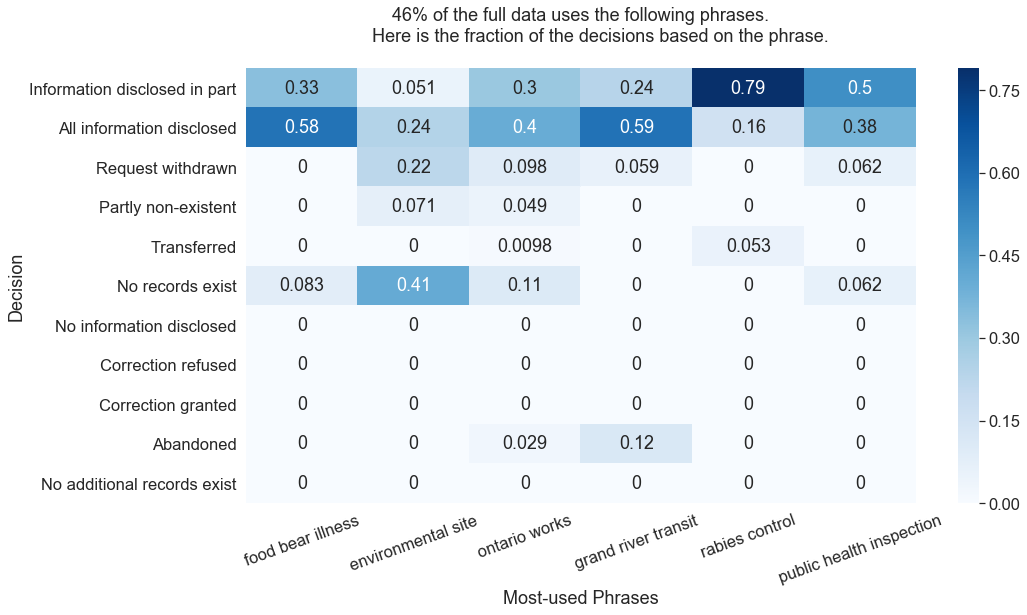

In [2412]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.set_context("notebook", font_scale=1.5)
sns.heatmap(counter_df_Dec_by_Decision, annot=True, fmt='0.2g', cmap='Blues',
            xticklabels=counter_df_Dec_by_Decision.columns, yticklabels=counter_df_Dec_by_Decision.index)

plt.ylabel('Decision')
plt.xlabel('Most-used Phrases')
plt.xticks(rotation=20)
ax.set(title='46% of the full data uses the following phrases.\n \
       Here is the fraction of the decisions based on the phrase.\n ')
plt.show()

It is interesting to note that none of these phrases got a single "No information disclosed" decision. In summary, 46% of all of our data contains these phrases, and of those phrases,

- *"food bear illness"*: 92% of the cases got full or partial information disclosed, with 8% where no information exists.
- *"environmental site"*: there was no information for 41% of the cases, for 22% of the cases the request was withdrawn. Full or partial information was given to 30%, while the remaining 7% had partially non-existent information.  
- *"ontario works"*: 70% got full or partial information disclosed, 13% of the cases were abandoned or withdrawn, information did not exist for 11%, while 5% had only partial existing information, and 1% gor transferred.
- *"grand river transit"*: 82% of cases got a full or partial information disclosed, while 18% of the cases were abandoned or withdrawn.
- *"rabies control"* got about 95% with all or partially information disclosed, and 5% of the cases were tranferred.
- *"public health Inspection"*: 88% got full or partial information disclosed, 6% had no records, and 6% of the requests were withdrawn. 

Visualizing same data in pie charts:

In [2413]:
def display_donut_charts(df, title, figsize_x, figsize_y, n_subplot_x, n_subplot_y):
    '''
    Displays donut charts for data in a pandas dataframe df
    Each column in the df is a chart, whose labels are the indices of the df.
        
    plt.subplots(figsize=(figsize_x, figsize_y)
    fig.add_subplot(n_subplot_y, n_subplot_x, counter+1)
    '''
    fig, axs = plt.subplots(figsize=(figsize_x, figsize_y), frameon=False) 
    plt.box(False)
    plt.axis('off')

    plt.title(title)
    plt.subplots_adjust(hspace = 1.4)

    counter = 0
    for col in df.columns:
        labels = []
        sizes = []

        nitems = len(df)

        for item in range(0, nitems):
            label = df.index[item]
            size = df.loc[label, col]
            if size > 0:
                labels.append(label)
                sizes.append(size)

        axs = fig.add_subplot(n_subplot_y, n_subplot_x, counter+1)

        axs.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85,
               labeldistance = 1.1, textprops={'fontsize': 13, 'fontweight': 'bold'})

        #draw circle
        centre_circle = plt.Circle((0,0), 0.70, fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle) 
        fig.tight_layout()
        axs.set_title(col)
        counter += 1

    plt.show()
    return None
    

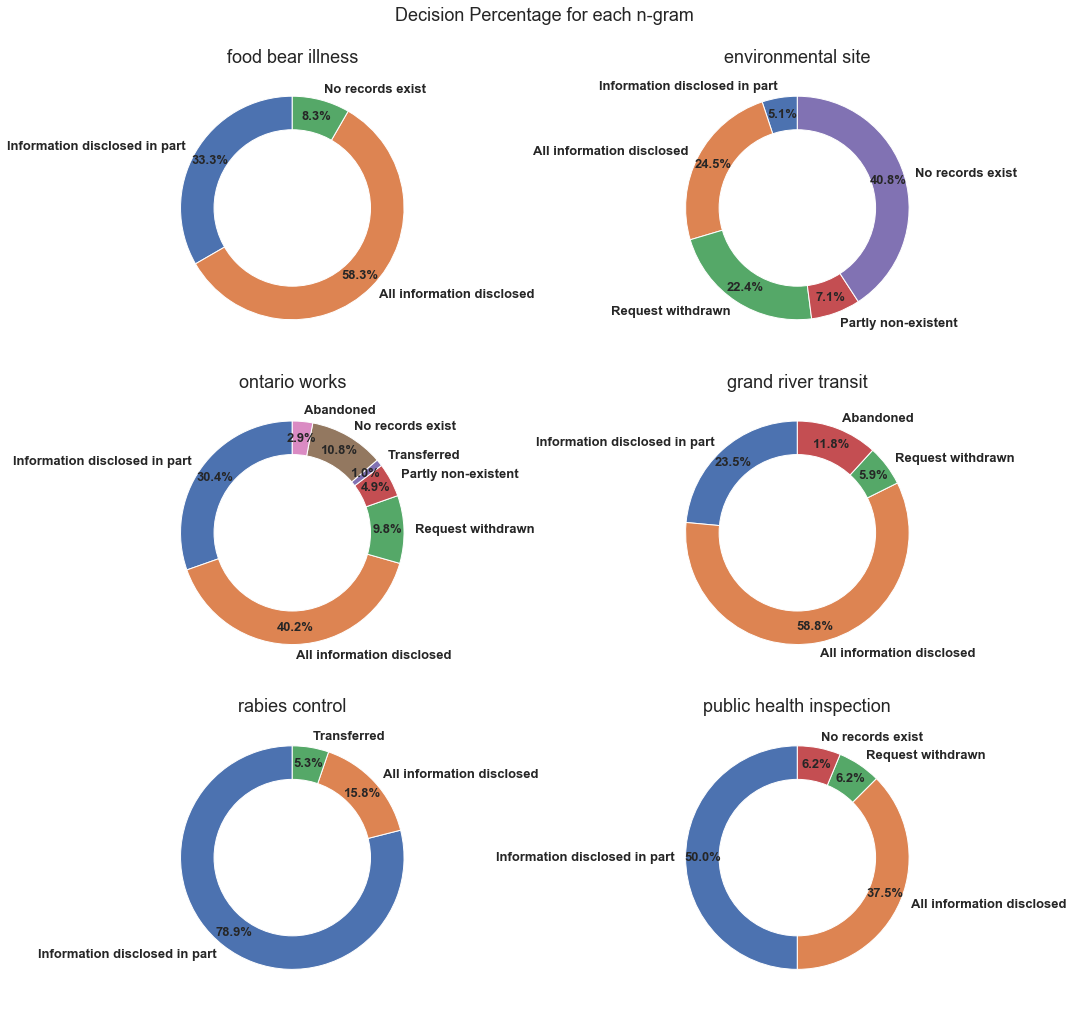

In [2414]:
display_donut_charts(counter_df_Dec_by_Decision, 'Decision Percentage for each n-gram\n\n',
                     15, 15, 2, 3)

In [2415]:
counter_df_Dec_by_Decision_inv = counter_df_Dec.T
counter_df_by_Source_inv = counter_df_Dec_by_Decision_inv.div(counter_df_Dec_by_Decision_inv.sum(axis=0), axis=1)
counter_df_by_Source_inv = counter_df_by_Source_inv.dropna(axis=1)
counter_df_by_Source_inv

Information disclosed in part  \
food bear illness                              0.059701   
environmental site                             0.074627   
ontario works                                  0.462687   
grand river transit                            0.059701   
rabies control                                 0.223881   
public health inspection                       0.119403   

                          All information disclosed  Request withdrawn  \
food bear illness                          0.076923           0.000000   
environmental site                         0.263736           0.647059   
ontario works                              0.450549           0.294118   
grand river transit                        0.109890           0.029412   
rabies control                             0.032967           0.000000   
public health inspection                   0.065934           0.029412   

                          Partly non-existent  Transferred  No records exist  \
food bear illness                    0.000000          0.0          0.018868   
environmental site                   0.583333          0.0          0.754717   
ontario works                        0.416667          0.5          0.207547   
grand river transit                  0.000000          0.0          0.000000   
rabies control                       0.000000          0.5          0.000000   
public health inspection             0.000000          0.0          0.018868   

                          Abandoned  
food bear illness               0.0  
environmental site              0.0  
ontario works                   0.6  
grand river transit             0.4  
rabies control                  0.0  
public health inspection        0.0

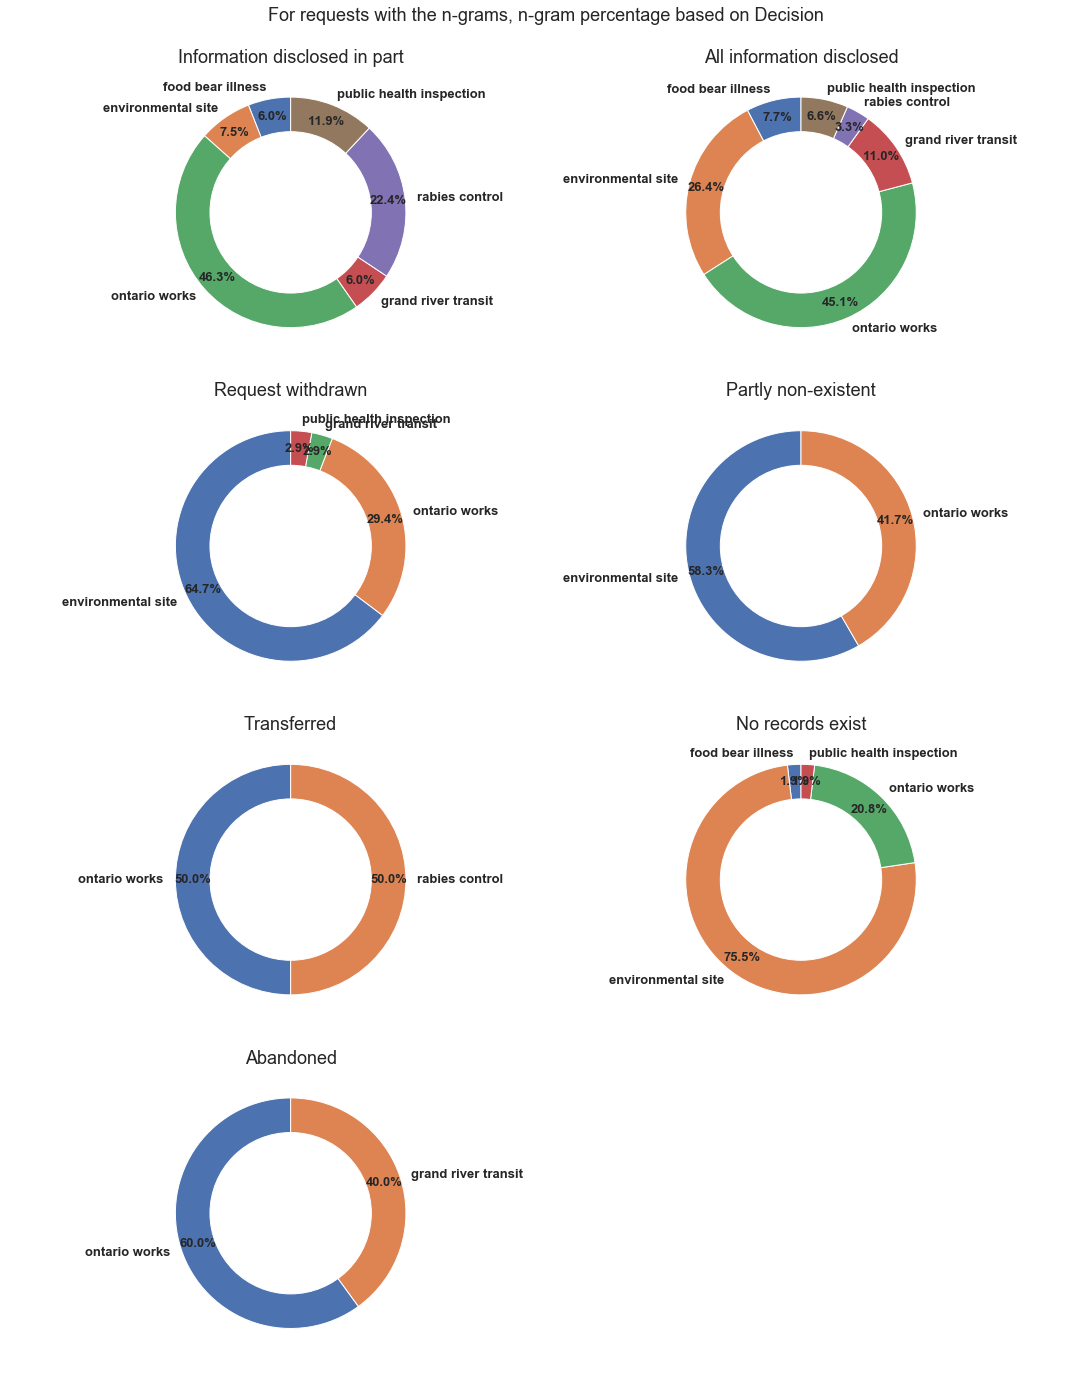

In [2416]:
display_donut_charts(counter_df_by_Source_inv, 
                     'For requests with the n-grams, n-gram percentage based on Decision\n\n',
                     15, 20, 2, 4)

## *Summary_of_Request* Statistics

It is be also interesting to see with how much data our ML algorith would be working. This is, what is the length of those "Summary_of_Request". Remember we don't get the full version submitted for review, but the summary made by the clerk. 

First, let's examine the full text we obtained directly from the files.

In [2417]:
num_chars = []
num_words = []
counter = 0

for index in range(0, len(all_text)):
    chars_num = len(all_text[index])
    words_num = len(parser(all_text[index]))
    num_chars.append(chars_num)
    num_words.append(words_num)
    if words_num > 100:
        counter += 1
        print(all_text[index])
        print("Number of characters: {0}".format(chars_num))
        number_words = parser(all_text[index])
        print("Number of words: {0} \n".format(words_num))
print("Total number of entries with more than 100 words: {0}".format(counter))


1. A copy of the successful proposal in response to the RFP C2014-39 for Tender Preparation, Contract Administration and Construction Inspection Services for the Construction of the Waterloo Spur Line Trail from Regina Street in the City of Waterloo to Ahrens Street in the City of Kitchener issued by the Regional Municipality of Waterloo on October 15, 2014.� Please exclude any promotional material that may have been submitted with the proposal and may be considered proprietary. 2. The total number of submissions and the dollar value of the top three submissions for RFP C2014-39.
Number of characters: 586
Number of words: 106 

1) Records for the past two years up to most current for the inspection, testing and maintaining of the traffic control signal system sub-systems at the intersection of Homer Watson Blvd. and Ottawa St. pursuant to "ONTARIO REGULATION 239/02 MINIMUM MAINTENANCE STANDARDS FOR MUNICIPAL HIGHWAYS", section 14 subsection (1).  2) Records for the past two years up to

Average number of words per request is 20.491319444444443, while the median is 15.0


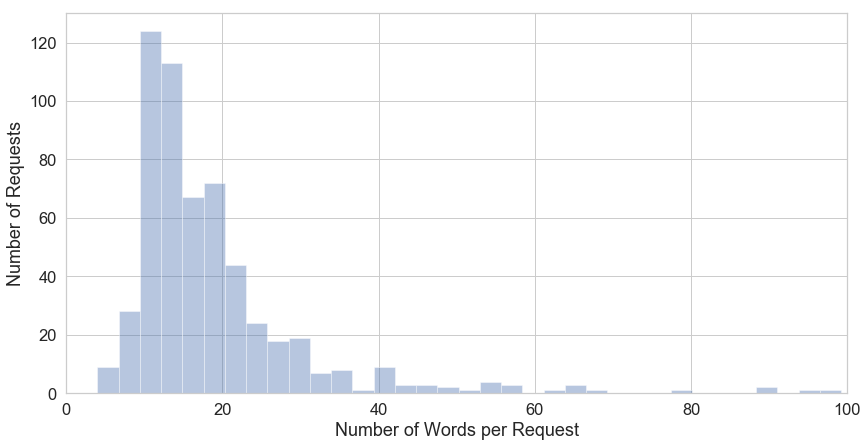

In [2419]:
np_num_words = np.array(num_words)
mean_words = np_num_words.mean()
median_words = np.median(num_words)

plt.figure(figsize=(14, 7))
plt.xlim(0, 100)
plt.xlabel('Number of Words per Request')
plt.ylabel('Number of Requests')
sns.distplot(num_words, bins=100, kde=False)

print("Average number of words per request is {0}, while the median is {1}".format(mean_words, median_words))


As for the tokenized version of it:

In [2420]:
all_text_tokenized = tokenized_adf['Edited_Summary']

# Merging all the requests into a single line
all_text_tokenized_merged = ''
for lines in range(0, len(all_text_tokenized)):
    all_text_tokenized_merged = all_text_tokenized_merged + ' ' + all_text_tokenized[lines]


In [2803]:
num_chars_t = []
num_words_t = []
small_req = []
counter = 0
counter_sm = 0

for index in range(0, len(all_text_tokenized)):
    chars_num_t = len(all_text_tokenized[index])
    words_num_t = len(parser(all_text_tokenized[index]))
    num_chars_t.append(chars_num_t)
    num_words_t.append(words_num_t)
    if words_num_t > 100:
        counter += 1
        print(all_text_tokenized[index])
        print("Number of characters: {0}".format(chars_num_t))
        number_words = parser(all_text_tokenized[index])
        print("Number of words: {0} \n".format(words_num_t))
    if words_num_t < 6:
        small_req.append(all_text_tokenized[index])
        counter_sm += 1
        
print("Total number of entries with more than 100 words: ", counter)
print("Total number of entries with less than 6 words: {0}," ,
      "which is {1:.2f}% of the total number of requests".format(
      counter_sm, (100.*counter_sm / len(all_text_tokenized))))


records past year current inspection test maintain traffic control signal intersection homer watson blvd ottawa pursuant ontario regulation 239/02 minimum maintenance standards municipal highways section subsection records past year current inspection test maintain conflict monitor(s intersection homer watson blvd ottawa pursuant ontario regulation 239/02 minimum maintenance standards municipal highways section subsection records past year current inspection test maintenance light camera intersection homer watson blvd ottawa records past year current year corrective maintenance need place traffic control signal intersection homer watson blvd ottawa records past year current year corrective maintenance need place conflict monitor(s intersection homer watson blvd ottawa records past year current year corrective maintenance need place light camera intersection homer watson blvd ottawa
Number of characters: 894
Number of words: 114 

Total number of entries with more than 100 words:  1
Tot

Average number of words per request is 9.338541666666666, while the median is 7.0


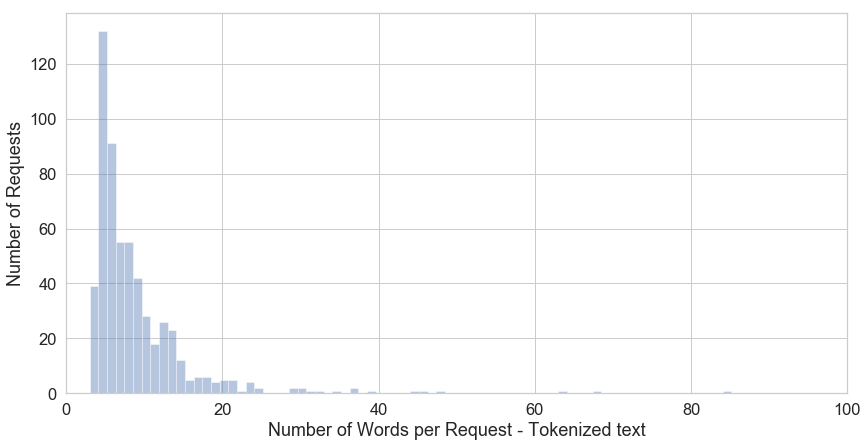

In [2432]:
np_num_words_t = np.array(num_words_t)
mean_words_t = np_num_words_t.mean()
median_words_t = np.median(num_words_t)

plt.figure(figsize=(14, 7))
plt.xlim(0, 100)
plt.xlabel('Number of Words per Request - Tokenized text')
plt.ylabel('Number of Requests')
sns.distplot(num_words_t, bins=100, kde=False)

print("Average number of words per request is {0}, while the median is {1}".format(mean_words_t, median_words_t))


Seven words (7!), the median, is not much with which to work...

30% of the requests have 5 words or less. They are listed below.

In [2433]:
small_req[:20]

['records relate complaint cambridge',
 'personnel file period 1990/10/01 1999/10/31',
 'phase environmental site assessment kitchener',
 'home child care provider file',
 'identity owner close restaurant',
 'proposals pride network p2002',
 'contracts payment make region waterloo',
 'records mould growth home kitchener',
 'results tender t2003 carpet replacement',
 'records regard municipal regulation pesticide',
 'analysis sewage composition cambridge 2003',
 'email send cupe member refer',
 'record correspondence ontario works file',
 'rabies control investigation file',
 'social worker client file pertain',
 'phase environmental site assessment elmira',
 'phase environmental site assessment elmira',
 'phase environmental site assessment elmira',
 'phase environmental site assessment cambridge',
 'employee file attendance datum']

In [2434]:
df_small_req = pd.DataFrame({'Tokenized_Requests_lt_6': small_req})


Of those 171 *small requests*, some are the same type of requests. We break down the number and phases below. We only show those with more than 2 cases. 

In [2435]:
#df_small_req['Tokenized_Requests_lt_6'].unique()
print("Number of unique values: ", df_small_req['Tokenized_Requests_lt_6'].nunique())
df_small_req['Tokenized_Requests_lt_6'].value_counts().head(12)


Number of unique values:  62


phase environmental site assessment kitchener    30
phase environmental site assessment cambridge    22
phase environmental site assessment waterloo     22
complete copy ontario works file                 21
complete ontario works file                       7
phase environmental site assessment elmira        6
rabies control investigation file                 4
phase environmental site assessment               3
copy complete ontario works file                  2
2416 outside video footage 2:00                   2
winning blueprinting service 2010                 1
records pertain requester 1987 date               1
Name: Tokenized_Requests_lt_6, dtype: int64

## POS Tagging

How about tag types? For this we will use spaCy.

One can do the analysis including empty spaces and punctuation. Instead, we chose to remove them first, therefore, we need to tokenize the text and then remove unwanted characters and symbols.  


However, the *nlp( )* function of spaCy, the one that will provide the tags, requires a string. We will need to stitch back together the tokens.

We will also use the text *all_text_merged_removed* instead of *all_text_merged* for this analysis. Comparing both outputs, strings such as *{name removed}* or *{location removed}* make up to 2% of the noun and verb POS tags.

In [2814]:
# Tokenizing text, while removing symbols
full_text_tok = prepare_text_for_pos_tagging(all_text_merged_removed)

# Merging all the tokens into a single line
full_text = ''
for words in range(0, len(full_text_tok)):
    full_text = full_text + ' ' + full_text_tok[words]


In [2815]:
full_text_nlp = nlp(full_text)    # spaCy nlp()

tags = []    # Array where the spacy tags will be stored

for token in full_text_nlp:
    tags.append(token.tag_)

tags_df = pd.DataFrame(data=tags, columns=['Tags'])

print("Number of unique tag values: {0}".format(tags_df['Tags'].nunique()))
print("Total number of words: {0}".format(len(tags_df['Tags'])))

# Make a dataframe out of unique values
tags_value_counts = tags_df['Tags'].value_counts(dropna=True, sort=True)
tags_value_counts_df = tags_value_counts.rename_axis('Unique_Values').reset_index(name='Counts')

# And normalizing the count values
tags_value_counts_df['Normalized_Count'] = tags_value_counts_df['Counts'] / len(tags_df['Tags'])

tags_value_counts_df.head(10)


Number of unique tag values: 37
Total number of words: 9011


Unique_Values  Counts  Normalized_Count
0            NN    3033          0.336589
1            IN    1619          0.179669
2            JJ     864          0.095883
3           NNS     842          0.093441
4            DT     591          0.065587
5            CD     582          0.064588
6            CC     361          0.040062
7           VBG     244          0.027078
8           VBN     217          0.024082
9           PRP     101          0.011209

Now, for those who can't remember what all of those tags mean, let's add the explanation as a new column called "Decoded" by using spacy's function *explain( )*.

In [2816]:
uv_decoded = []

for val in tags_value_counts_df['Unique_Values']:
    uv_decoded.append(spacy.explain(val))

tags_value_counts_df['Decoded'] = uv_decoded
tags_value_counts_df

Unique_Values  Counts  Normalized_Count  \
0             NN    3033          0.336589   
1             IN    1619          0.179669   
2             JJ     864          0.095883   
3            NNS     842          0.093441   
4             DT     591          0.065587   
5             CD     582          0.064588   
6             CC     361          0.040062   
7            VBG     244          0.027078   
8            VBN     217          0.024082   
9            PRP     101          0.011209   
10            VB      97          0.010765   
11            TO      67          0.007435   
12           VBP      62          0.006880   
13            RB      60          0.006659   
14           VBD      51          0.005660   
15           WDT      34          0.003773   
16           VBZ      32          0.003551   
17           NNP      32          0.003551   
18             .      27          0.002996   
19           POS      22          0.002441   
20            MD      21          0.002330   
21            RP      10          0.001110   
22           WRB       8          0.000888   
23          PRP$       7          0.000777   
24           RBS       4          0.000444   
25           JJS       4          0.000444   
26            FW       3          0.000333   
27           AFX       3          0.000333   
28            WP       3          0.000333   
29            UH       2          0.000222   
30            EX       2          0.000222   
31           JJR       1          0.000111   
32            XX       1          0.000111   
33           PDT       1          0.000111   
34            ''       1          0.000111   
35            LS       1          0.000111   
36                     1          0.000111   

                                      Decoded  
0                      noun, singular or mass  
1   conjunction, subordinating or preposition  
2                                   adjective  
3                                noun, plural  
4                                  determiner  
5                             cardinal number  
6                   conjunction, coordinating  
7          verb, gerund or present participle  
8                       verb, past participle  
9                           pronoun, personal  
10                            verb, base form  
11                             infinitival to  
12      verb, non-3rd person singular present  
13                                     adverb  
14                           verb, past tense  
15                              wh-determiner  
16          verb, 3rd person singular present  
17                      noun, proper singular  
18          punctuation mark, sentence closer  
19                          possessive ending  
20                      verb, modal auxiliary  
21                           adverb, particle  
22                                  wh-adverb  
23                        pronoun, possessive  
24                        adverb, superlative  
25                     adjective, superlative  
26                               foreign word  
27                                      affix  
28                       wh-pronoun, personal  
29                               interjection  
30                          existential there  
31                     adjective, comparative  
32                                    unknown  
33                              predeterminer  
34                     closing quotation mark  
35                           list item marker  
36                                       None

Given the range of values, it does not make much sense to plot anything under 30 occurances.

In [2817]:
tags_value_counts_df_gt20 = tags_value_counts_df[tags_value_counts_df['Counts'] > 30]

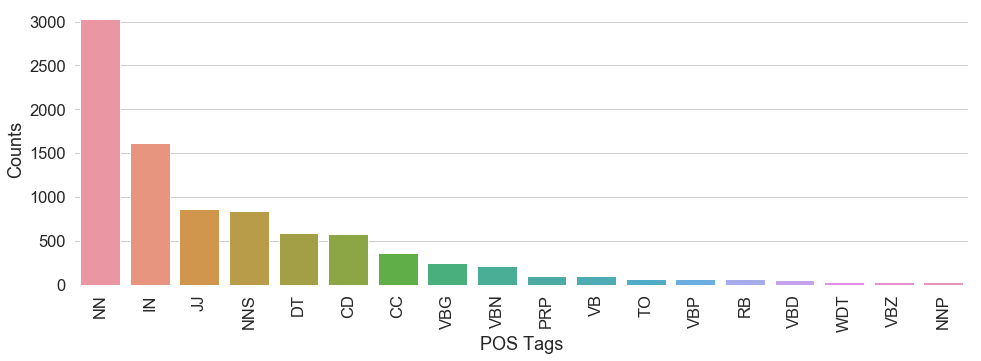

In [2820]:
categ = list(tags_value_counts_df_gt20['Unique_Values'])

f, ax = plt.subplots(figsize=(16, 5))

sns.set_color_codes('dark')
sns.barplot(y=tags_value_counts_df_gt20['Counts'], x=categ)
ax.set(xlabel="POS Tags", ylim=(0, 3100), ylabel="Counts")
plt.xticks(rotation=90)
sns.despine(left=True, bottom=True)

And to be more explicit, let's write the descriptions instead.

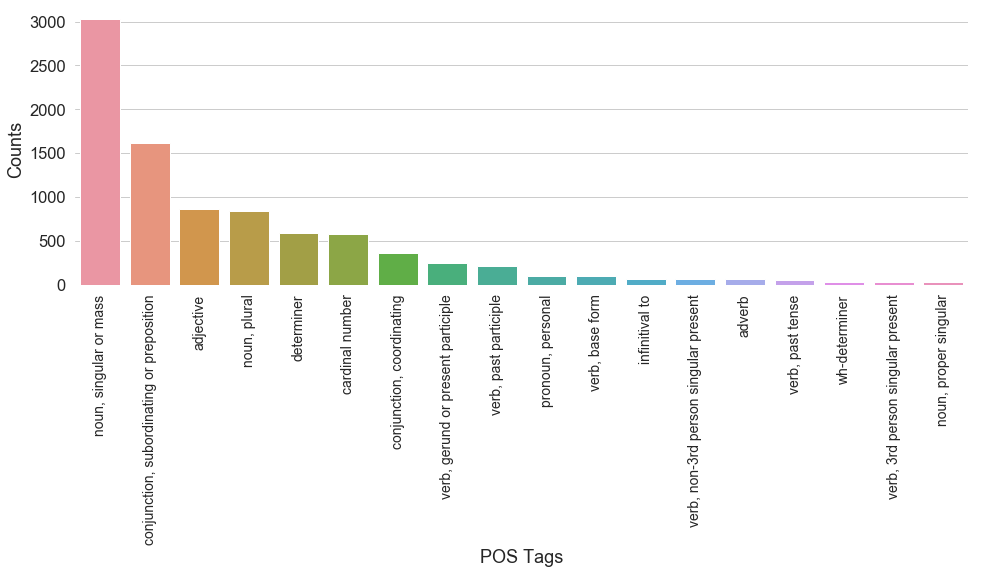

In [2821]:
categ = list(tags_value_counts_df_gt20['Decoded'])

f, ax = plt.subplots(figsize=(16, 5))

sns.set_color_codes('dark')
sns.barplot(y=tags_value_counts_df_gt20['Counts'], x=categ)
ax.set(xlabel="POS Tags", ylim=(0, 3100), ylabel="Counts")
plt.xticks(rotation=90, fontsize=14)
sns.despine(left=True, bottom=True)

And with normalized values (0 to 1),

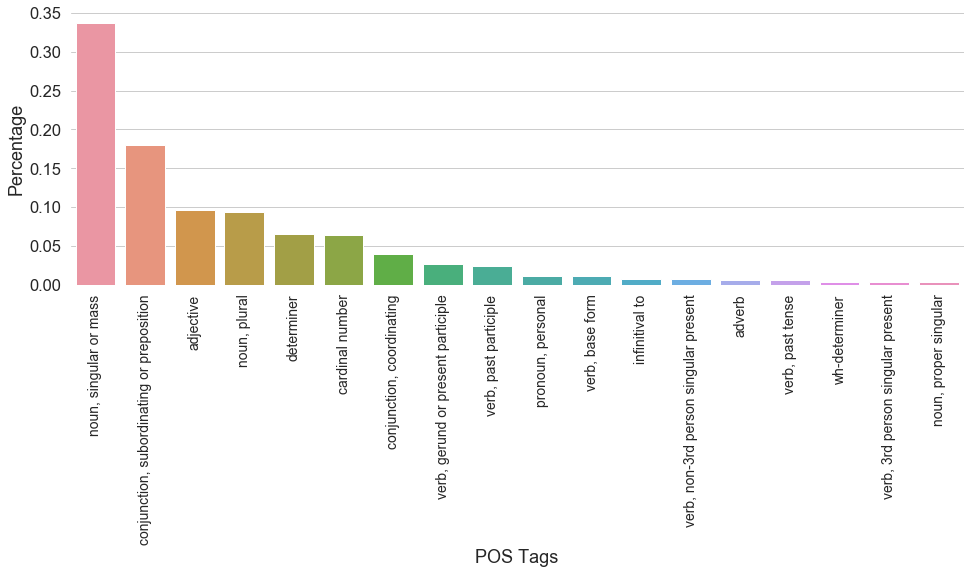

In [2823]:
categ = list(tags_value_counts_df_gt20['Decoded'])

f, ax = plt.subplots(figsize=(16, 5))

sns.set_color_codes('dark')
sns.barplot(y=tags_value_counts_df_gt20['Normalized_Count'], x=categ)
ax.set(xlabel="POS Tags", ylim=(0, 0.35), ylabel="Percentage")
plt.xticks(rotation=90, fontsize=14)
sns.despine(left=True, bottom=True)

It is interesting to see how much text is composed of nouns (singular, plural,...), verbs (present, past,...), numbers, conjunctions, pronouns, adverbs, and adjectives.

In [2824]:
pos_types = ['noun', 'pronoun', 'verb', 'adjective', 'adverb', 'conjunction', 'cardinal']

tag_tag = []
tag_count = []
tag_percent = []

for tag in pos_types:
    # Adding the columns that fit the constraint
    tag_array = tags_value_counts_df[(tags_value_counts_df['Decoded'].str.startswith(tag, na=False))].sum(axis=0)
    tag_tag.append(tag)
    # tag_array: [0]=Unique_Values, [1]=Counts, [2]=Normalized_Count, [3]=Decoded
    tag_count.append(tag_array[1])
    tag_percent.append(tag_array[2])

d = {'Tags':tag_tag, 'Counts':tag_count, 'Normalized_Count':tag_percent}

tags_df = pd.DataFrame(d)
tags_df = tags_df.sort_values(by='Counts', ascending=False)
tags_df

Counts  Normalized_Count         Tags
0    3907          0.433581         noun
5    1980          0.219731  conjunction
3     869          0.096438    adjective
2     724          0.080346         verb
6     582          0.064588     cardinal
1     108          0.011985      pronoun
4      74          0.008212       adverb

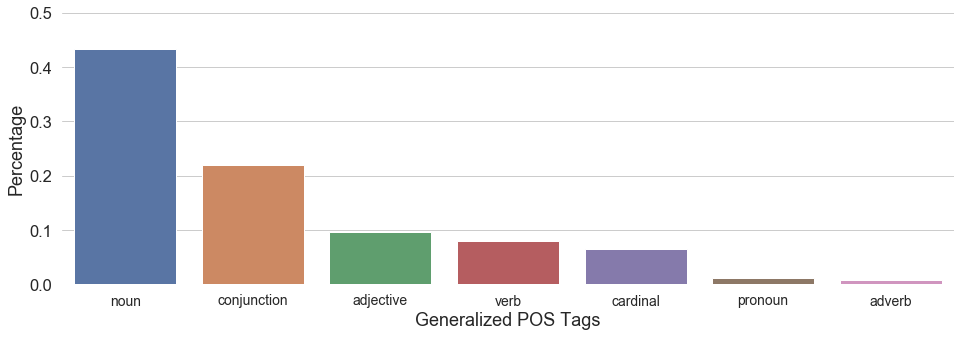

In [2825]:
categ = list(tags_df['Tags'])

f, ax = plt.subplots(figsize=(16, 5))

sns.set_color_codes('dark')
sns.barplot(y=tags_df['Normalized_Count'], x=categ)
ax.set(xlabel="Generalized POS Tags", ylim=(0, 0.5), ylabel="Percentage")
plt.xticks(rotation=0, fontsize=14)
sns.despine(left=True, bottom=True)

In summary, our corpus includes 43% nouns, 22% conjunctions, 10% adjectives, 8% verbs, 6% numbers, 1% pronouns, among others (9%).

## LSA and LDA Analysis using Bokeh, scikit-learn, and t-SNE

Following Susan Li's posts. We present here LSA and LDA analysis of the text.

In [2445]:
from sklearn.manifold import TSNE

# LSA
from sklearn.decomposition import TruncatedSVD

# LDA
from sklearn.decomposition import LatentDirichletAllocation

In [2446]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.models import Label
from bokeh.models import Range1d

output_notebook()

Loading BokehJS ...

In [2447]:
import matplotlib.patheffects as path_effects

In [2448]:
# Susan Li's predefined functions

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
    
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:, index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(", ".join(topic_words))         
    return top_words

def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        reviews_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                reviews_in_that_topic.append(two_dim_vectors[i])    
        
        reviews_in_that_topic = np.vstack(reviews_in_that_topic)
        mean_review_in_that_topic = np.mean(reviews_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_review_in_that_topic)
    return mean_topic_vectors

def get_median_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of median-centroid vectors from each predicted topic category
    '''
    median_topic_vectors = []
    for t in range(n_topics):
        reviews_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                reviews_in_that_topic.append(two_dim_vectors[i])    
        
        reviews_in_that_topic = np.vstack(reviews_in_that_topic)
        median_review_in_that_topic = np.median(reviews_in_that_topic, axis=0)
        median_topic_vectors.append(median_review_in_that_topic)
    return median_topic_vectors

In [2449]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [2450]:
def display_model_outputs(df, df_col, n_topics, num_top_n_words,
                          la_model, model_seed, 
                          vectorizer_name, 
                          title_barplot, 
                          title_tsne_plot, tsne_plot_range_x_x, tsne_plot_range_x_y,
                          tsne_plot_range_y_x, tsne_plot_range_y_y):
    '''
    Creates a LSA or LDA model by using either TruncatedSVD()
    or LatentDirichletAllocation() for n topics
    
    Takes only two vectorizers, TfidfVectorizer() as tfidf_vectorizer or 
    CountVectorizer() as count_vectorizer
    
    df_col must be the column in which there is the tokenized text.
    
    num_top_n_words: number of words to display
    '''
    
    reindexed_data = df[df_col]
    reindexed_data = reindexed_data.values
    
    if vectorizer_name == 'tfidf_vectorizer':
        vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
    elif vectorizer_name == 'count_vectorizer':
        vectorizer = CountVectorizer(ngram_range=(1, 5))
    else:
        print("No such vectorizer")
        return None
    
    document_term_matrix = vectorizer.fit_transform(reindexed_data)
    
    if la_model == 'LSA':
        model = TruncatedSVD(n_components=n_topics, random_state=model_seed)
    elif la_model == "LDA":
        model = LatentDirichletAllocation(n_components=n_topics,
                                          random_state=model_seed, verbose=0)
    else: 
        print("No such model")
        return None
    
    topic_matrix = model.fit_transform(document_term_matrix)

    keys = get_keys(topic_matrix)
    categories, counts = keys_to_counts(keys)
    top_n_words = get_top_n_words(num_top_n_words, keys, document_term_matrix, vectorizer)

    for i in range(len(top_n_words)):
        print("Topic {}: ".format(i + 1), top_n_words[i])

    # Plotting
    labels = ['Topic {}: \n'.format(i + 1) + top_n_words[i] for i in categories]
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.bar(categories, counts);
    ax.set_xticks(categories);
    ax.set_xticklabels(labels);
    ax.set_ylabel('Number of Requests');
    ax.set_title(title_barplot);
    plt.xticks(rotation=30, fontsize=12)
    plt.show();

    #Bokeh and t-SNE
    tsne_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                            n_iter=2000, verbose=1, random_state=42, angle=0.75)
    tsne_vectors = tsne_model.fit_transform(topic_matrix)

    mean_topic_vectors = get_mean_topic_vectors(keys, tsne_vectors)

    plot = figure(title=title_tsne_plot.format(n_topics), 
                  plot_width=700, plot_height=700, 
                  x_range=[tsne_plot_range_x_x, tsne_plot_range_x_y],
                  y_range=[tsne_plot_range_y_x, tsne_plot_range_y_y])

    plot.scatter(x=tsne_vectors[:,0], y=tsne_vectors[:,1], color=colormap[keys])

    for t in range(n_topics):
        label = Label(x=mean_topic_vectors[t][0], y=mean_topic_vectors[t][1], 
                      text=top_n_words[t], text_color=colormap[t])
        plot.add_layout(label)

    show(plot)
    
    return None
    

## LSA - scikit-learn - tf-idf vectorizer

Of the 10 topics found, five of the previously six discussed common phrases are included, except for *"Public Health Inspection"*.


Topic 1:  works, ontario, file, complete
Topic 2:  phase, assessment, site, environmental
Topic 3:  record, regard, relate, waterloo
Topic 4:  kitchener, mould, 2003, street
Topic 5:  rabies, investigation, control, file
Topic 6:  cambridge, records, vicinity, relate
Topic 7:  health, public, milk, sell
Topic 8:  transit, grand, river, video
Topic 9:  food, illness, bear, investigation
Topic 10:  child, care, home, provider


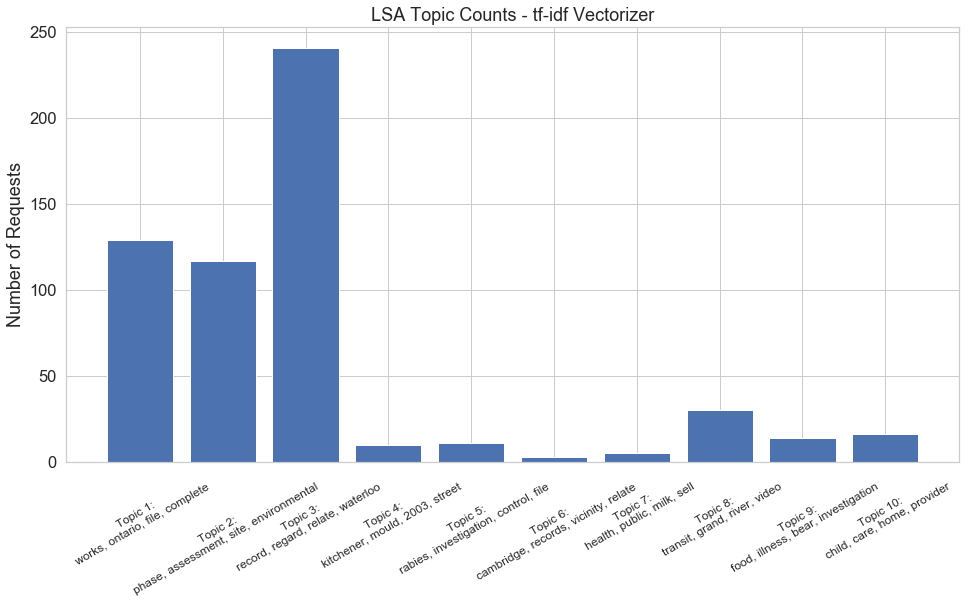

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 576 samples in 0.000s...
[t-SNE] Computed neighbors for 576 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 576 / 576
[t-SNE] Mean sigma: 0.090932
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.772839
[t-SNE] KL divergence after 2000 iterations: 0.330207


In [2451]:
display_model_outputs(tokenized_adf, 'Edited_Summary', 10, 4,
                      'LSA', 42, 
                      'tfidf_vectorizer', 
                      'LSA Topic Counts - tf-idf Vectorizer', 
                      "t-SNE Clustering of {} LSA Topics - tf-idf Vectorizer",
                       -30, 50,
                       -30, 20)

While there seems to be defined clusters for *food bear illness*, *rabies*, *ontario works*, and *environmental site*, these last two also overlap with the *record regard relate waterloo* topic, which is also overlaps with the other topics. 

## LDA - scikit learn - tf-idf vectorizer

Of the 10 topics found, LDA found four of the previously six discussed common phrases are included, except for *"Grand River Transit"* and *food bear illness*.

Topic 1:  relate, policy, environmentally, sensitive
Topic 2:  health, public, inspection, food
Topic 3:  service, winning, blueprinting, file
Topic 4:  phase, site, assessment, environmental
Topic 5:  water, 000, refer, maintenance
Topic 6:  speed, 2013, charge, regard
Topic 7:  record, waterloo, signal, street
Topic 8:  works, complete, ontario, file
Topic 9:  rabies, control, investigation, record
Topic 10:  identity, report, application, include


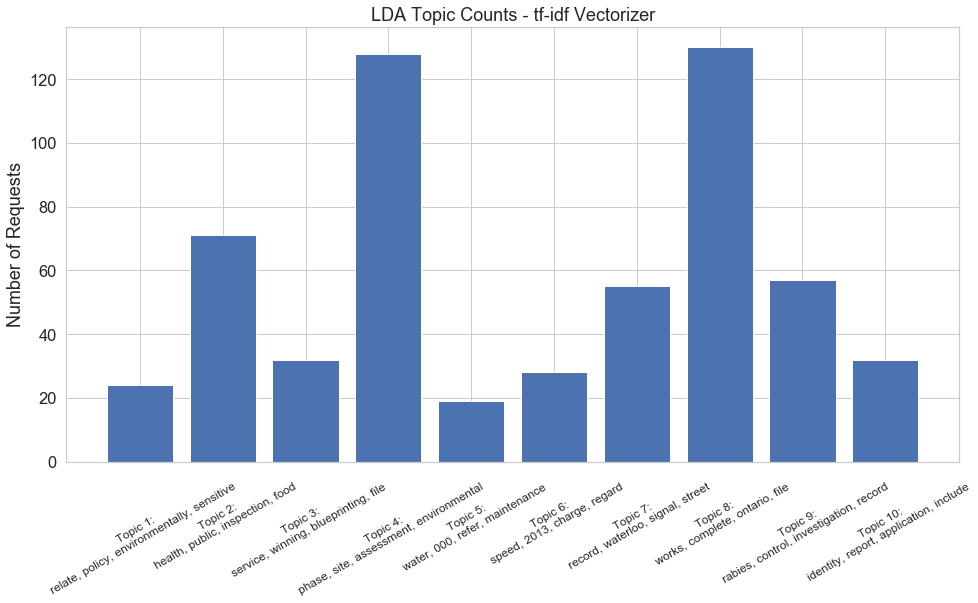

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 576 samples in 0.000s...
[t-SNE] Computed neighbors for 576 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 576 / 576
[t-SNE] Mean sigma: 0.001239
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.165726
[t-SNE] KL divergence after 2000 iterations: 0.174454


In [2452]:
display_model_outputs(tokenized_adf, 'Edited_Summary', 10, 4,
                      'LDA', 42, 
                      'tfidf_vectorizer', 
                      'LDA Topic Counts - tf-idf Vectorizer', 
                      "t-SNE Clustering of {} LDA Topics - tf-idf Vectorizer",
                       -30, 50,
                       -30, 20)

t-SNE for LDA with tf-idf provides more defined clusters compared to LSA. 

## LSA - scikit learn - CountVectorizer

It seems like LSA + CountVectorizer does not give better results. It did find three of the topics, but t-SNE gives overlapping clusters and the top topics include bigrams, too. And while the words *Waterloo* and *Kitchener* are present in many requests, as expected, it is probably not a good idea for those to be topics themselves.

Topic 1:  year, records, homer, homer watson
Topic 2:  file, ontario, works, ontario works
Topic 3:  environmental, site, assessment, phase
Topic 4:  terminal, guardrail terminal, guardrail, waterloo
Topic 5:  centre, waterloo city centre, city, waterloo city
Topic 6:  transit, river transit, river, grand river transit
Topic 7:  signal, january, traffic, intersection
Topic 8:  record, waterloo, regard, relate
Topic 9:  numb, total, park, 2014
Topic 10:  kitchener, january, street, street south kitchener


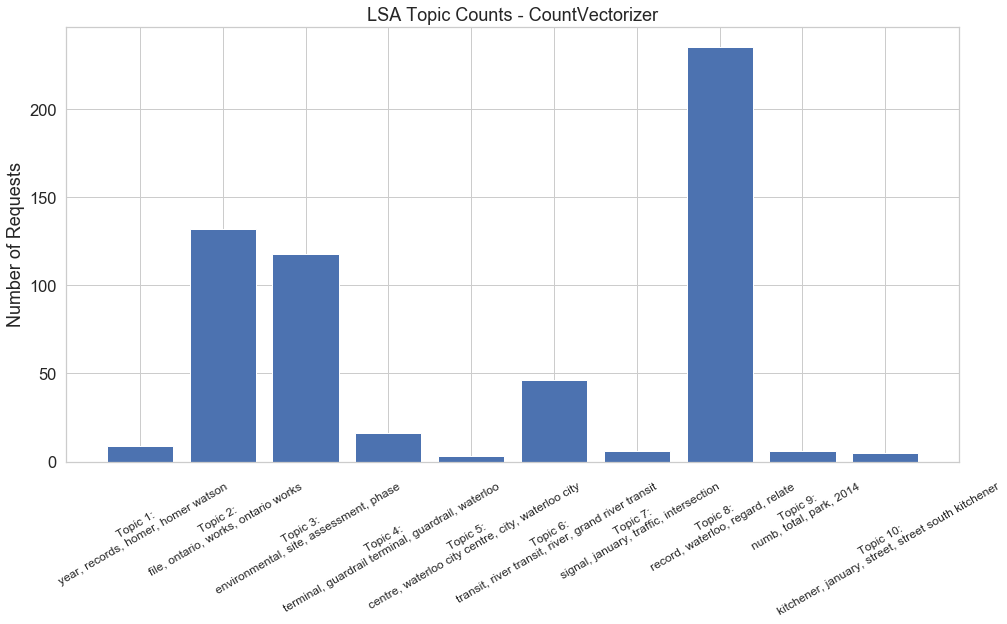

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 576 samples in 0.000s...
[t-SNE] Computed neighbors for 576 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 576 / 576
[t-SNE] Mean sigma: 0.236402
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.945583
[t-SNE] KL divergence after 1800 iterations: 0.282286


In [2453]:
display_model_outputs(tokenized_adf, 'Edited_Summary', 10, 4,
                      'LSA', 42, 
                      'count_vectorizer', 
                      'LSA Topic Counts - CountVectorizer', 
                      "t-SNE Clustering of {} LSA Topics - CountVectorizer",
                       -20, 50,
                       -20, 40)

## LDA - scikit learn - CountVectorizer

While t-DNE gives more defined clusters for LSA + CountVectorizer, it is obvious by looking at the topics that this is not a good model for our data.

Topic 1:  regard, file, record, health
Topic 2:  waterloo, region, region waterloo, record
Topic 3:  record, regard, relate, file
Topic 4:  relate, record, waterloo, region
Topic 5:  environmental, environmental site, assessment, phase
Topic 6:  include, terminal, guardrail, guardrail terminal
Topic 7:  regard, record, waterloo, relate
Topic 8:  waterloo, file, relate, maintenance
Topic 9:  transit, incident, relate, record
Topic 10:  file, ontario, ontario works, works


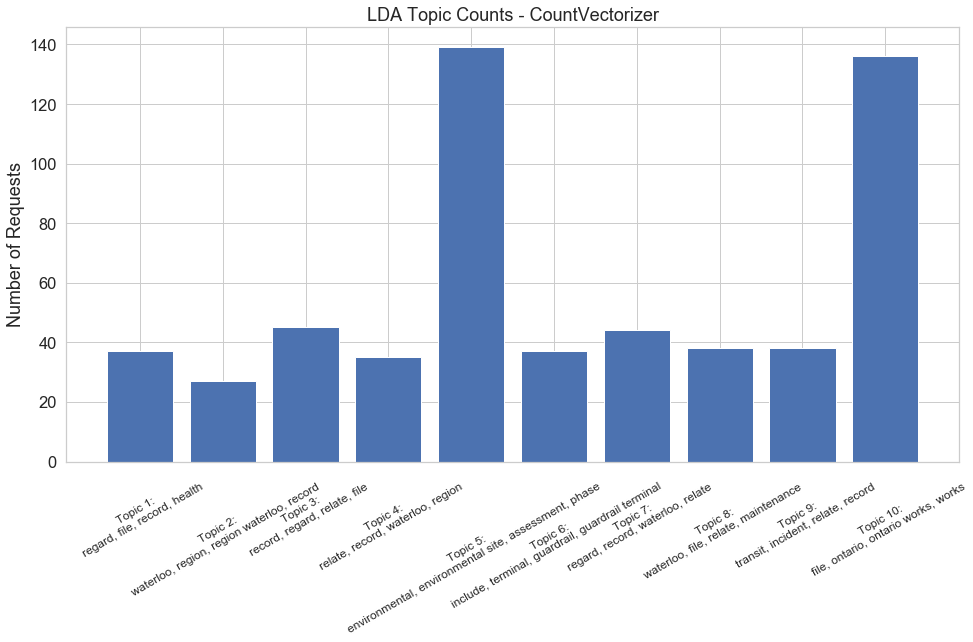

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 576 samples in 0.000s...
[t-SNE] Computed neighbors for 576 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 576 / 576
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.050976
[t-SNE] KL divergence after 1750 iterations: 0.073258


In [2454]:
display_model_outputs(tokenized_adf, 'Edited_Summary', 10, 4,
                      'LDA', 42, 
                      'count_vectorizer', 
                      'LDA Topic Counts - CountVectorizer', 
                      "t-SNE Clustering of {} LDA Topics - CountVectorizer",
                       -30, 50,
                       -24, 24)

## LDA Analysis using Gensim and pyLDAvis

### Gensim
Another tool for LDA analysis is gensim, an open-source library for unsupervised topic modeling and natural language processing. Gensim is specifically designed to handle large text collections using data streaming and incremental online algorithms, which differentiates it from most other machine learning software packages that target only in-memory processing.

In [2455]:
import gensim
from gensim import corpora

import pyLDAvis.gensim    # To visualize our output


In [2456]:
import warnings 
warnings.filterwarnings('ignore')

In [2731]:
# 'Edited_Summary' has the tokens already, no need to preprocess or prepare the text

text_data = []
for index in range(0, len(tokenized_adf)):
    current_line = tokenized_adf['Edited_Summary'][index]
    line_tokens = prepare_text_tlc(current_line)
    text_data.append(line_tokens)

In [2732]:
#Convert document into the bag-of-words format 
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

# To be able to save model to hard drive
import pickle
pickle.dump(corpus, open('data/corpus/corpus.pkl', 'wb'))
dictionary.save('data/gensim/dictionary.gensim')

Let's try extracting a different number of topics, from 3 to 15, and print the top 5 words of each.

In [2733]:
NUM_TOPICS = 3
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('data/gensim/model3.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.076*"file" + 0.062*"ontario" + 0.060*"work" + 0.056*"copy" + 0.050*"complete"')
(1, '0.030*"record" + 0.028*"waterloo" + 0.025*"regard" + 0.022*"region" + 0.019*"relate"')
(2, '0.060*"environmental" + 0.058*"site" + 0.057*"assessment" + 0.053*"phase" + 0.024*"waterloo"')


In [1022]:
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('data/gensim/model5.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.072*"file" + 0.068*"ontario" + 0.066*"environmental" + 0.063*"assessment" + 0.063*"work"')
(1, '0.034*"record" + 0.028*"regard" + 0.023*"waterloo" + 0.019*"inspection" + 0.018*"year"')
(2, '0.033*"waterloo" + 0.032*"record" + 0.029*"region" + 0.023*"relate" + 0.020*"incident"')
(3, '0.024*"record" + 0.022*"regard" + 0.020*"river" + 0.020*"transit" + 0.019*"video"')
(4, '0.020*"file" + 0.015*"waterloo" + 0.014*"record" + 0.014*"road" + 0.013*"control"')


In [1023]:
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('data/gensim/model10.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.025*"record" + 0.020*"service" + 0.017*"2013" + 0.016*"relate" + 0.015*"regard"')
(1, '0.032*"proposal" + 0.026*"speed" + 0.025*"request" + 0.023*"provincial" + 0.020*"include"')
(2, '0.045*"record" + 0.043*"investigation" + 0.036*"regard" + 0.031*"rabies" + 0.031*"control"')
(3, '0.095*"file" + 0.092*"ontario" + 0.086*"work" + 0.085*"copy" + 0.073*"complete"')
(4, '0.038*"record" + 0.036*"transit" + 0.036*"grand" + 0.035*"river" + 0.027*"video"')
(5, '0.077*"health" + 0.065*"public" + 0.042*"inspection" + 0.026*"waterloo" + 0.023*"record"')
(6, '0.037*"waterloo" + 0.031*"region" + 0.028*"relate" + 0.022*"correspondence" + 0.017*"january"')
(7, '0.112*"environmental" + 0.107*"site" + 0.103*"assessment" + 0.096*"phase" + 0.039*"kitchener"')
(8, '0.035*"year" + 0.024*"waterloo" + 0.019*"past" + 0.019*"intersection" + 0.018*"region"')
(9, '0.030*"kitchener" + 0.022*"report" + 0.022*"road" + 0.022*"record" + 0.019*"service"')


In [1020]:
NUM_TOPICS = 15
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('data/gensim/model15.gensim')
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.147*"environmental" + 0.143*"site" + 0.141*"assessment" + 0.130*"phase" + 0.050*"kitchener"')
(1, '0.046*"transit" + 0.034*"grand" + 0.034*"river" + 0.022*"incident" + 0.019*"regard"')
(2, '0.031*"relate" + 0.030*"waterloo" + 0.022*"construction" + 0.021*"water" + 0.019*"region"')
(3, '0.036*"1996" + 0.031*"year" + 0.027*"child" + 0.024*"december" + 0.022*"1998"')
(4, '0.060*"control" + 0.058*"rabies" + 0.053*"investigation" + 0.044*"record" + 0.043*"file"')
(5, '0.030*"signal" + 0.028*"record" + 0.025*"intersection" + 0.024*"homer" + 0.024*"watson"')
(6, '0.030*"proposal" + 0.023*"request" + 0.021*"2016" + 0.020*"january" + 0.018*"2009"')
(7, '0.032*"waterloo" + 0.022*"record" + 0.018*"guardrail" + 0.018*"terminal" + 0.018*"include"')
(8, '0.032*"2001" + 0.026*"incident" + 0.026*"2004" + 0.024*"record" + 0.023*"illness"')
(9, '0.036*"record" + 0.034*"relate" + 0.027*"include" + 0.019*"report" + 0.018*"2015"')
(10, '0.029*"waterloo" + 0.021*"city" + 0.018*"relate" + 0.017*"recor

### pyLDAvis

pyLDAvis is a python library for interactive topic model visualization. It is designed to help users interpret the topics in a topic model that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an interactive web-based visualization.



In [1024]:
pyLDAvis.enable_notebook()

In [1025]:
# We can load the dictionary and corpus from the files we already stored in the hard drive. 
dictionary = gensim.corpora.Dictionary.load('data/gensim/dictionary.gensim')
corpus = pickle.load(open('data/corpus/corpus.pkl', 'rb'))


Let's now visualize our data for all the models, which range from 3 to 15 topics. It seems that perhaps 3-5 topics give the clearer distinction between topics in the distance map. Realistically, we know the number topics should be more. Increasing the number of topics just brings up the issue that for our models, given the number of words and data we have, there is no clear separation of topics.

In [1026]:
lda = gensim.models.ldamodel.LdaModel.load('data/gensim/model15.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [1027]:
lda = gensim.models.ldamodel.LdaModel.load('data/gensim/model10.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [1028]:
lda = gensim.models.ldamodel.LdaModel.load('data/gensim/model5.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [1029]:
lda = gensim.models.ldamodel.LdaModel.load('data/gensim/model3.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## LSI Analysis using Gensim

In [1100]:
NUM_TOPICS = 10
lsimodel = gensim.models.lsimodel.LsiModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary)
lsimodel.save('data/gensim/model10_lsi.gensim')
topics = lsimodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '-0.344*"record" + -0.272*"ontario" + -0.271*"year" + -0.233*"file" + -0.214*"work"')
(1, '0.400*"file" + 0.351*"work" + 0.346*"copy" + 0.319*"complete" + 0.317*"ontario"')
(2, '0.425*"site" + 0.423*"assessment" + 0.398*"environmental" + 0.362*"phase" + 0.336*"waterloo"')
(3, '0.318*"waterloo" + 0.306*"terminal" + 0.287*"guardrail" + 0.270*"region" + -0.239*"phase"')
(4, '-0.343*"guardrail" + -0.326*"terminal" + 0.317*"regard" + 0.233*"record" + -0.214*"plus"')
(5, '0.410*"waterloo" + 0.355*"city" + 0.316*"centre" + -0.247*"record" + 0.209*"canviro"')
(6, '0.454*"record" + -0.365*"transit" + -0.324*"river" + -0.323*"grand" + -0.197*"video"')
(7, '-0.438*"january" + -0.289*"support" + -0.268*"signal" + -0.224*"2014" + -0.219*"2016"')
(8, '-0.401*"employee" + -0.361*"park" + -0.275*"report" + -0.272*"incident" + -0.231*"total"')
(9, '0.401*"region" + 0.284*"waterloo" + -0.219*"report" + -0.197*"centre" + -0.196*"regard"')


# Machine Learning

Having taken a deep look at our text, we now proceed to try to predict the *Decision* based on the *Summary_of_Request* text. We move forward even though our colleague Scott Jones already worked with this data and found ML does not work very well given the size of our set. He, instead, proceeded to add the freedom of information requests from Toronto and surrounding areas. 

But, hey, we are learning, so let's give ML a shot (again) given what we already know about the limitations of the data and the preprocessing we did. We also add other models to the analysis.

In [2458]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing

from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.base import TransformerMixin
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

import mlxtend
from mlxtend.plotting import category_scatter
from mlxtend.plotting import plot_decision_regions

import scikitplot as skplt

from xgboost import XGBClassifier

In [2459]:
from spacy import displacy

import en_core_web_sm

nlp = en_core_web_sm.load()

In [2725]:
class clean_text_Transformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    
def get_params(self, deep=True):
        return {}

In [2461]:
def display_confusion_matrix(y_test, preds,
                             df, df_col_w_labels,
                             plot_title):
    
    count_conf_mat = confusion_matrix(y_test, preds)
    fig, ax = plt.subplots(figsize=(10, 7))
    labels = df[df_col_w_labels].unique()
    sns.heatmap(count_conf_mat, annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set(title=plot_title)
    plt.show() 
    
    return None
    

In [2462]:
def display_confusion_matrix_w_report(y_test, preds,
                             df, df_col_w_labels,
                             plot_title):
    
    count_conf_mat = confusion_matrix(y_test, preds)
    fig, ax = plt.subplots(figsize=(10, 5))
    labels = df[df_col_w_labels].unique()
    sns.heatmap(count_conf_mat, annot=True, fmt='d',
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set(title=plot_title)
    plt.show() 
    
    print(classification_report(y_test, preds,
                                target_names=df[df_col_w_labels].unique()))
    
    return None
    

As a reminder, we have 11 types of decisions in a unbalanced set.

In [2463]:
print(tokenized_adf['Decision'].value_counts())

All information disclosed        189
Information disclosed in part    152
No records exist                  80
Request withdrawn                 80
Partly non-existent               23
No information disclosed          21
Transferred                       15
Abandoned                         13
No additional records exist        1
Correction refused                 1
Correction granted                 1
Name: Decision, dtype: int64


We will be using two vectorizers for our analysis, CountVectorizer and tf-idf.

In [2703]:
count_vect = CountVectorizer(tokenizer=prepare_text_tlc, ngram_range=(1, 5))
tfidf_vect = TfidfVectorizer(tokenizer=prepare_text_tlc, ngram_range=(1, 5))

Let's choose the MultinomialNB model as a start,

In [2704]:
count_clf = MultinomialNB()
tfidf_clf = MultinomialNB()

and define a pipeline for our text, to clean it up, select and apply both the vectorizer and classifier.

In [2726]:
count_pipe = Pipeline([
                      ('clean_text', clean_text_Transformer()),
                      ('vectorizer', count_vect),
                      ('clf', count_clf)
                      ])

tfidf_pipe = Pipeline([
                      ('clean_text', clean_text_Transformer()),
                      ('vectorizer', tfidf_vect),
                      ('clf', tfidf_clf)
                      ])

We will work with our dataframe whose column *'Edited_Summary'* has the cleaned and tokenized text, where symbols and stopwords have been removed already.

In [2727]:
y = tokenized_adf['Decision']
X1 = tokenized_adf['Edited_Summary']
X1_train, X1_test, y1_train, y1_test=train_test_split(X1, y, test_size=0.33, random_state=42)

We will train in 67% of the set, which is about 385 requests.

### CountVectorizer with MultinomialNB - full set of decisions

In [2729]:
count_pipe.fit(X1_train, y1_train)
count_preds = count_pipe.predict(X1_test)
print("Accuracy: {0}".format(accuracy_score(y1_test, count_preds)))

Accuracy: 0.4293193717277487


CountVectorizer with MultinomialNB gives about 43% accuracy, bummer! Let's look at the confusion matrix.

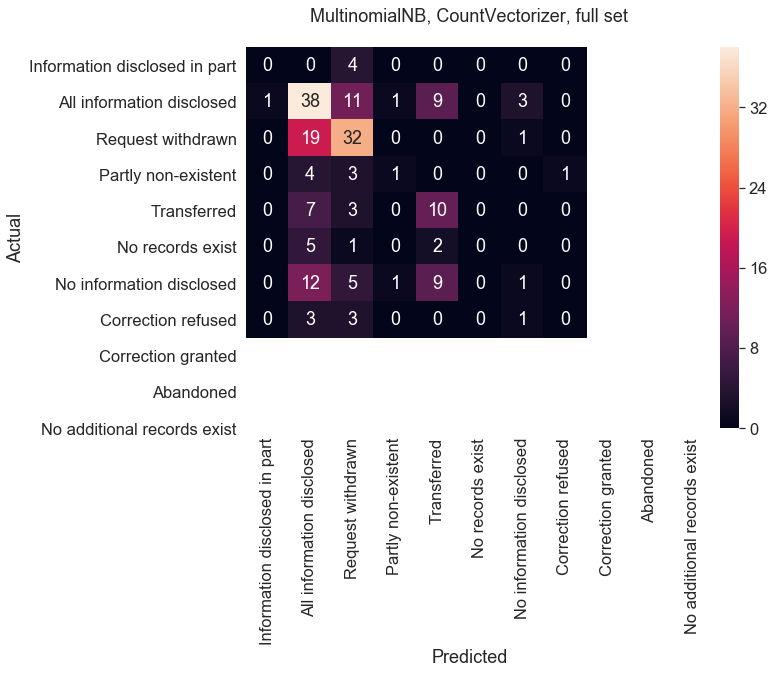

In [2730]:
display_confusion_matrix(y1_test, count_preds,
                         tokenized_adf, 'Decision',
                         'MultinomialNB, CountVectorizer, full set\n')

### tf-idf with LinearSVC - full set of decisions

In [2471]:
tfidf_pipe.fit(X1_train, y1_train)
tfidf_preds = tfidf_pipe.predict(X1_test)
print("Accuracy: {0}".format(accuracy_score(y1_test, tfidf_preds)))

Accuracy: 0.418848167539267


tf-idf with MultinomialNB gives about 42% accuracy, not better. Let's look at the confusion matrix.

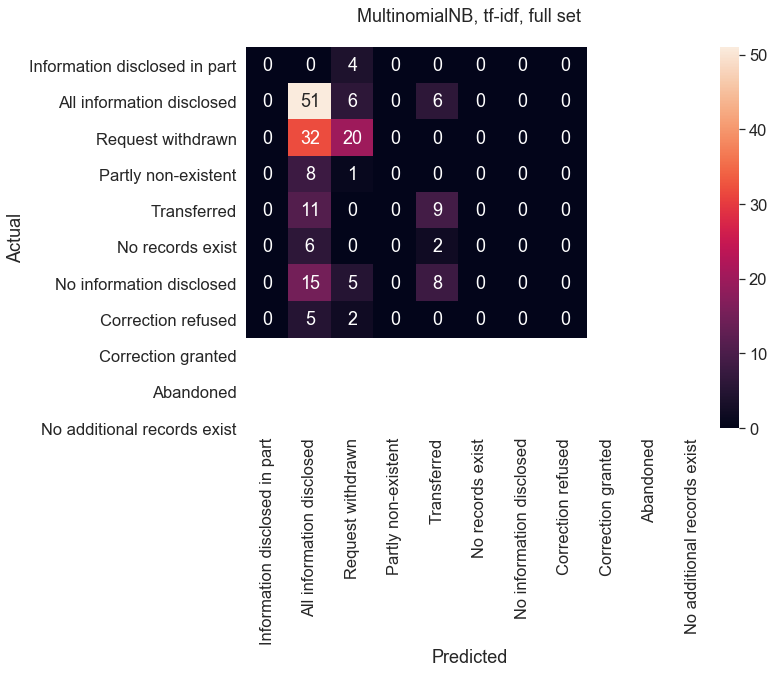

In [2472]:
display_confusion_matrix(y1_test, tfidf_preds,
                         tokenized_adf, 'Decision',
                         'MultinomialNB, tf-idf, full set\n')

By observing the matrix, we can see that it could not predict decisions that had few instances, like *'Correction granted'*, which has only once request. It was in the training set but not in the prediction set, or vice versa, but not both.

Therefore, let's test three different approaches to this:

a) Keep our set of decisions, except for the ones with less than 15 instances (just to keep *'Transferred'*.)

b) Binning all decisions into 3 basic categories, all, partial, or no information disclosed.

a) Remove cases with less than 15 cases and where a decision was not made, this, when the request was either *'Withdrawn'* or *'Abandoned'*. 


## a) Using Decisions with more than 15 instances

In [2473]:
print(tokenized_adf['Decision'].value_counts())

All information disclosed        189
Information disclosed in part    152
No records exist                  80
Request withdrawn                 80
Partly non-existent               23
No information disclosed          21
Transferred                       15
Abandoned                         13
No additional records exist        1
Correction refused                 1
Correction granted                 1
Name: Decision, dtype: int64


In [2474]:
tokenized_adf_over15 = tokenized_adf.groupby('Decision').filter(lambda x: len(x) >= 15)
print(tokenized_adf_over15['Decision'].value_counts())

All information disclosed        189
Information disclosed in part    152
No records exist                  80
Request withdrawn                 80
Partly non-existent               23
No information disclosed          21
Transferred                       15
Name: Decision, dtype: int64


### Model comparison

Now we will introduce a way to compare 8 classifiers at once, both numerically and visually. We start with CounterVectorizer, for both regular and *balanced* class weights, and then we will change our vectorizer to tf-idf.


In [2868]:
accuracy_dfs = []    # Setting up a array of dataframes to be put all the results together later on.

In [2869]:
def compare_ML_models(df, df_feature_col, df_labels_col, 
                      vectorizer_name, 
                      num_k_folds,
                      model_seed,
                      balanced_bool,
                      title_plot, 
                      accuracy_df_title):
    '''
    Functions that compares eight ML classifiers models:
    RandomForest, LinearSVC, MultinomialNB, LogisticRegression,
    SVC, KNeighbors, SGDC, and DecisionTree for
    five numebr of folds (cv)
    
    Takes:
    dataframe
    dataframe column with data
    dataframe column with labels
    vectorizer
    random seed,
    if one considers class_weight='balanced'
    plot title
    output dataframe title
    
    Output:
    Dataframe with accuracy means per model
      
    '''
  
    if vectorizer_name == 'tfidf_vectorizer':
        vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2',
                                     ngram_range=(1, 4), tokenizer=prepare_text_tlc)
    elif vectorizer_name == 'count_vectorizer':
        vectorizer = CountVectorizer(min_df=3, ngram_range=(1, 4), tokenizer=prepare_text_tlc)
    else:
        print("No such vectorizer")
        return None

    assert df_feature_col in  df, "Column '{0}' not in dataframe".format(df_feature_col)
    assert df_labels_col in  df, "Column '{0}' not in dataframe".format(df_labels_col)
    
    features = vectorizer.fit_transform(df[df_feature_col])
    labels = df[df_labels_col]
    
    if balanced_bool:
        cw_value = 'balanced'
    else:
        cw_value = None

    models = [
        RandomForestClassifier(n_estimators=200, max_depth=3,
                               random_state=model_seed, class_weight=cw_value),
        LinearSVC(random_state=model_seed, class_weight=cw_value),
        MultinomialNB(),
        LogisticRegression(random_state=model_seed, class_weight=cw_value),
        SVC(gamma="scale", random_state=model_seed, class_weight=cw_value),
        KNeighborsClassifier(),
        SGDClassifier(loss='hinge', penalty='l2', max_iter=5, tol=None,
                      random_state=model_seed, class_weight=cw_value),
        DecisionTreeClassifier(random_state=model_seed, class_weight=cw_value)
        ]
        
    CV = num_k_folds
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, features, labels,
                                     scoring='accuracy', cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


    fig, ax = plt.subplots(figsize=(15,6))
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df,
                 size=8, jitter=True, edgecolor="gray", linewidth=2)
    ax.set(title=title_plot)
    plt.xticks(rotation=30, fontsize=14)
    plt.show()

    accuracy_df = cv_df.groupby('model_name').accuracy.mean()
    accuracy_df = accuracy_df.to_frame()
    accuracy_df.rename(index=str, columns={"accuracy": accuracy_df_title}, inplace=True)

    return accuracy_df

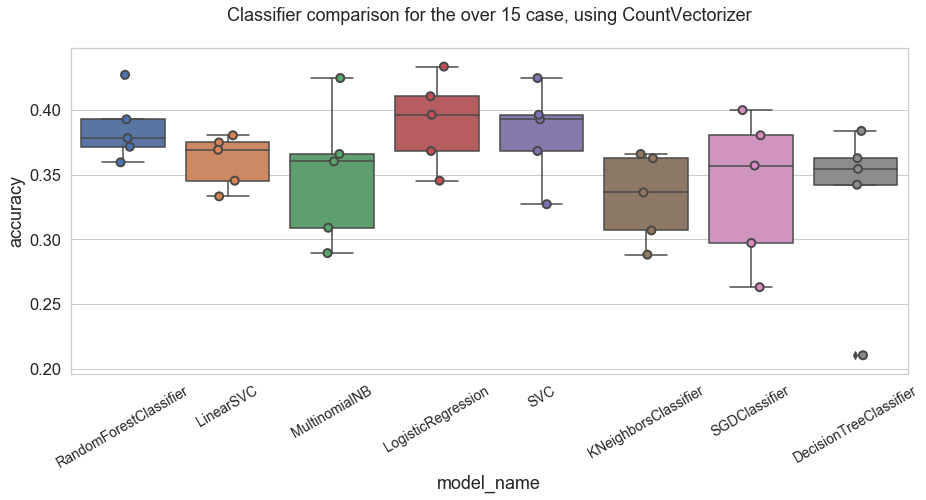

Acc., ov15, CVec
model_name                              
DecisionTreeClassifier          0.330835
KNeighborsClassifier            0.332115
LinearSVC                       0.360738
LogisticRegression              0.390923
MultinomialNB                   0.349955
RandomForestClassifier          0.385968
SGDClassifier                   0.339626
SVC                             0.381945

In [2870]:
acc_df1 = compare_ML_models(tokenized_adf_over15, 'Edited_Summary', 'Decision', 
              'count_vectorizer', 
              5,
              42,
              False,
              'Classifier comparison for the over 15 case, using CountVectorizer\n', 
              'Acc., ov15, CVec')
accuracy_dfs.append(acc_df1)
acc_df1

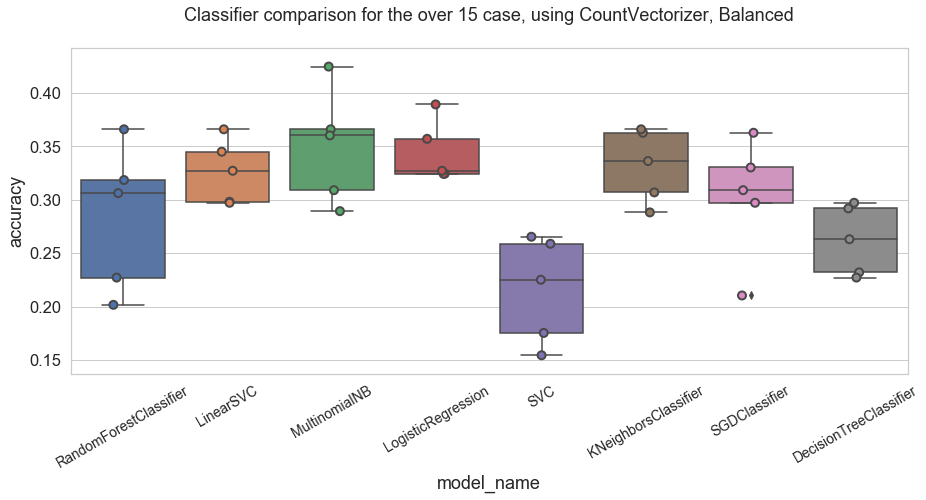

Acc., ov15, CVec, bal.
model_name                                    
DecisionTreeClassifier                0.262381
KNeighborsClassifier                  0.332115
LinearSVC                             0.326804
LogisticRegression                    0.344536
MultinomialNB                         0.349955
RandomForestClassifier                0.283998
SGDClassifier                         0.302021
SVC                                   0.215925

In [2871]:
acc_df2 = compare_ML_models(tokenized_adf_over15, 'Edited_Summary', 'Decision', 
              'count_vectorizer', 
              5,
              42,
              True,
              'Classifier comparison for the over 15 case, using CountVectorizer, Balanced\n', 
              'Acc., ov15, CVec, bal.')
accuracy_dfs.append(acc_df2)
acc_df2

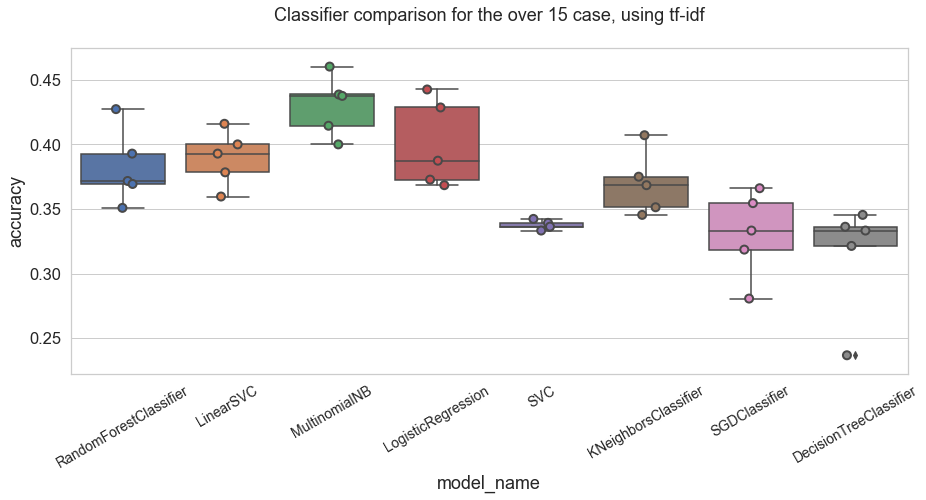

Acc., o15, tf-idf
model_name                               
DecisionTreeClassifier           0.314668
KNeighborsClassifier             0.369461
LinearSVC                        0.389363
LogisticRegression               0.399917
MultinomialNB                    0.430138
RandomForestClassifier           0.382412
SGDClassifier                    0.330647
SVC                              0.337522

In [2872]:
acc_df3 = compare_ML_models(tokenized_adf_over15, 'Edited_Summary', 'Decision', 
              'tfidf_vectorizer', 
              5,
              42,
              False,
              'Classifier comparison for the over 15 case, using tf-idf\n', 
              'Acc., o15, tf-idf')
accuracy_dfs.append(acc_df3)
acc_df3

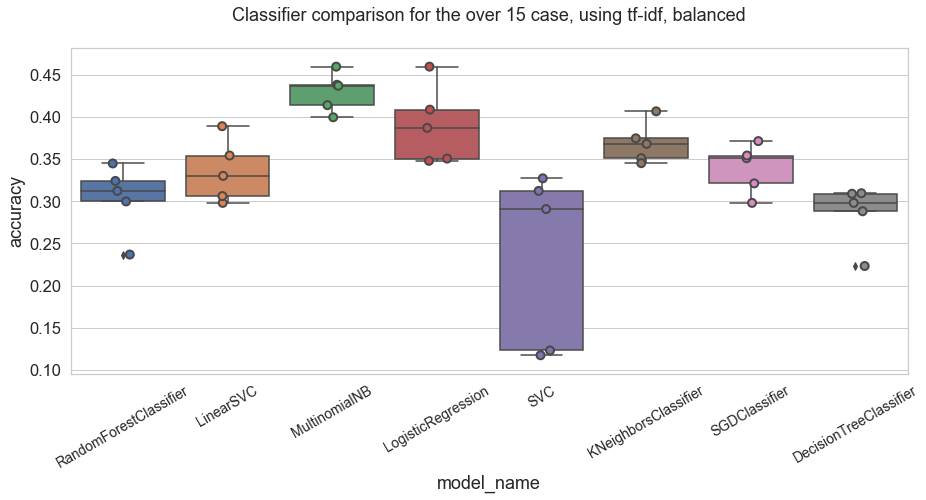

Acc., o15, tf-idf, bal.
model_name                                     
DecisionTreeClassifier                 0.285715
KNeighborsClassifier                   0.369461
LinearSVC                              0.335767
LogisticRegression                     0.391149
MultinomialNB                          0.430138
RandomForestClassifier                 0.303760
SGDClassifier                          0.339450
SVC                                    0.234153

In [2873]:
acc_df4 = compare_ML_models(tokenized_adf_over15, 'Edited_Summary', 'Decision', 
              'tfidf_vectorizer', 
              5,
              42,
              True,
              'Classifier comparison for the over 15 case, using tf-idf, balanced\n', 
              'Acc., o15, tf-idf, bal.')
accuracy_dfs.append(acc_df4)
acc_df4

### Grid Search

MultinomialNB with tf-idf seems to do better. Therefore, we are going to show an example of the approach using GridSearch to find the best parameters for a classifier, in this case, for MultinomialNB, and the vectorizer. We will find the scores and the confusion matrix.


Setting our training and test sets.

In [2840]:
y_s_over15 = tokenized_adf_over15['Decision']
X_s_over15 = tokenized_adf_over15['Edited_Summary']
X_s_over15_train, X_s_over15_test, y_s_over15_train, y_s_over15_test=train_test_split(X_s_over15, 
                                                y_s_over15, test_size=0.33, random_state=42)

Finding parameters.

In [2884]:
tfidf_vect = TfidfVectorizer()
parameters = {'vectorizer__ngram_range': [(1, 2), (1, 3), (1, 4)],
              'clf__alpha': (1, 1e-1, 1e-2, 1e-3)
             }
tfidf_clf = MultinomialNB()
tfidf_pipe = Pipeline([
                      ('vectorizer', tfidf_vect),
                      ('clf', tfidf_clf)
                      ])
gs_clf = GridSearchCV(tfidf_pipe, parameters, cv=5, iid=False, n_jobs=-1)
gs_clf = gs_clf.fit(X_s_over15_train, y_s_over15_train)
print("For MultinomialNB Classifier with tf-idf:\n")
print("Best score: ", gs_clf.best_score_)
for param_name in sorted(parameters.keys()):
    print("{0}: {1}".format(param_name, gs_clf.best_params_[param_name]))


For MultinomialNB Classifier with tf-idf:

Best score:  0.4393272845875586
clf__alpha: 0.1
vectorizer__ngram_range: (1, 4)


Running our model with the parameters just found.

MultinomialNB Accuracy, tfidf, over 15 case: 0.43243243243243246


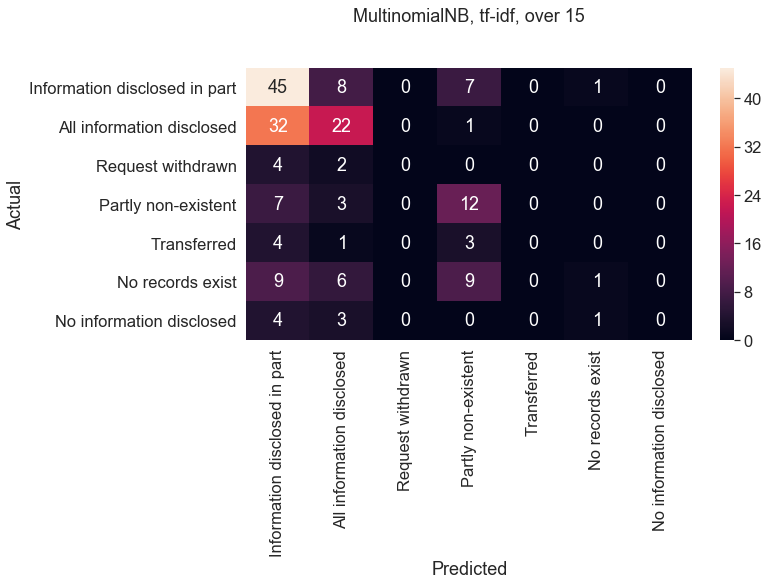

                               precision    recall  f1-score   support

Information disclosed in part       0.43      0.74      0.54        61
    All information disclosed       0.49      0.40      0.44        55
            Request withdrawn       0.00      0.00      0.00         6
          Partly non-existent       0.38      0.55      0.44        22
                  Transferred       0.00      0.00      0.00         8
             No records exist       0.33      0.04      0.07        25
     No information disclosed       0.00      0.00      0.00         8

                    micro avg       0.43      0.43      0.43       185
                    macro avg       0.23      0.25      0.21       185
                 weighted avg       0.38      0.43      0.37       185



In [2230]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 4))
tfidf_clf = MultinomialNB(alpha=0.1)

tfidf_pipe.fit(X_s_over15_train, y_s_over15_train)
tfidf_preds = tfidf_pipe.predict(X_s_over15_test)
print("MultinomialNB Accuracy, tfidf, over 15 case:", accuracy_score(y_s_over15_test, tfidf_preds))

display_confusion_matrix_w_report(y_s_over15_test, tfidf_preds,
                         tokenized_adf_over15, 'Decision',
                         'MultinomialNB, tf-idf, over 15\n\n')

## b) Binning into 3 basic categories: all, partial, or no information disclosed

So, let's reduce the categories to three: all, partial, and no information disclosed. We'll bin them according to:

- All information disclosed (plus 'Correction granted')

- Information disclosed in part (plus 'Partly non-existent')

- No information disclosed (plus 'Transferred', 'No records exist', 'Correction refused', 'No additional records exist', 'Withdrawn', and 'Abandoned')

We will do this by adding a new column to our array, *'Sub_Decision'*.

In [2841]:
tokenized_adf.head(4)

Request_Number Request_Type      Source  \
0           99001      General    Business   
1           99002      General    Business   
2           99003      General    Business   
3           99004      General  Individual   

                                  Summary_of_Request  \
0  Minutes of Service Delivery Subcommittee of ES...   
1  Public Health inspection reports for the {loca...   
2  Public Health inspection records for {location...   
3  Public Health inspection records for {address ...   

                        Decision  \
0  Information disclosed in part   
1      All information disclosed   
2  Information disclosed in part   
3      All information disclosed   

                                      Edited_Summary  
0  minutes service delivery subcommittee escac pe...  
1  public health inspection report kitchener past...  
2  public health inspection record cambridge past...  
3  public health inspection record cambridge rela...

In [2842]:
tokenized_adf['Sub_Decision'] = tokenized_adf['Decision']

In [2843]:
tokenized_adf.head(4)

Request_Number Request_Type      Source  \
0           99001      General    Business   
1           99002      General    Business   
2           99003      General    Business   
3           99004      General  Individual   

                                  Summary_of_Request  \
0  Minutes of Service Delivery Subcommittee of ES...   
1  Public Health inspection reports for the {loca...   
2  Public Health inspection records for {location...   
3  Public Health inspection records for {address ...   

                        Decision  \
0  Information disclosed in part   
1      All information disclosed   
2  Information disclosed in part   
3      All information disclosed   

                                      Edited_Summary  \
0  minutes service delivery subcommittee escac pe...   
1  public health inspection report kitchener past...   
2  public health inspection record cambridge past...   
3  public health inspection record cambridge rela...   

                    Sub_Decision  
0  Information disclosed in part  
1      All information disclosed  
2  Information disclosed in part  
3      All information disclosed

Replacing our decisions for a generic version.

In [2844]:
pos_dec = {'Correction granted'}
part_dec = {'Partly non-existent'}
neg_dec = {'Request withdrawn', 'Transferred', 'No records exist', 'Correction refused', 'Abandoned', 
           'No additional records exist'}

In [2845]:
for pos in pos_dec:
    tokenized_adf['Sub_Decision'] = tokenized_adf['Sub_Decision'].str.replace(
                                    pos,'All information disclosed')

In [2846]:
for part in part_dec:
    tokenized_adf['Sub_Decision'] = tokenized_adf['Sub_Decision'].str.replace(
                                    part,'Information disclosed in part')

In [2847]:
for neg in neg_dec:
    tokenized_adf['Sub_Decision'] = tokenized_adf['Sub_Decision'].str.replace(
                                    neg,'No information disclosed')

In [2848]:
tokenized_adf.head(11)

Request_Number Request_Type      Source  \
0            99001      General    Business   
1            99002      General    Business   
2            99003      General    Business   
3            99004      General  Individual   
4            99005      General    Business   
5            99006     Personal  Individual   
6            99007      General  Individual   
7            99008      General  Individual   
8            99009     Personal  Individual   
9            99010      General    Business   
10           99011      General    Business   

                                   Summary_of_Request  \
0   Minutes of Service Delivery Subcommittee of ES...   
1   Public Health inspection reports for the {loca...   
2   Public Health inspection records for {location...   
3   Public Health inspection records for {address ...   
4   Vendor list report with total of year-to-date ...   
5   Public Health inspection file for {name remove...   
6   Scope of work and deliverables sections of con...   
7   Number of contracts and dollar amount of contr...   
8   Public Health inspection report regarding a co...   
9   Phase I environmental site assessment regardin...   
10  Complete fiscal year end vendor report for yea...   

                         Decision  \
0   Information disclosed in part   
1       All information disclosed   
2   Information disclosed in part   
3       All information disclosed   
4       All information disclosed   
5       All information disclosed   
6       All information disclosed   
7               Request withdrawn   
8       All information disclosed   
9               Request withdrawn   
10            Partly non-existent   

                                       Edited_Summary  \
0   minutes service delivery subcommittee escac pe...   
1   public health inspection report kitchener past...   
2   public health inspection record cambridge past...   
3   public health inspection record cambridge rela...   
4   vendor list report total year date purchase fi...   
5   public health inspection file regard requester...   
6   scope work deliverable section contract region...   
7   number contract dollar contract region waterlo...   
8   public health inspection report regard complai...   
9    phase environmental site assessment regard sewer   
10  complete fiscal year vendor report year 1996 1...   

                     Sub_Decision  
0   Information disclosed in part  
1       All information disclosed  
2   Information disclosed in part  
3       All information disclosed  
4       All information disclosed  
5       All information disclosed  
6       All information disclosed  
7        No information disclosed  
8       All information disclosed  
9        No information disclosed  
10  Information disclosed in part

In [2849]:
tokenized_adf['Sub_Decision'].unique()

array(['Information disclosed in part', 'All information disclosed',
       'No information disclosed'], dtype=object)

In [2850]:
tokenized_adf.Sub_Decision.value_counts()

No information disclosed         211
All information disclosed        190
Information disclosed in part    175
Name: Sub_Decision, dtype: int64

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

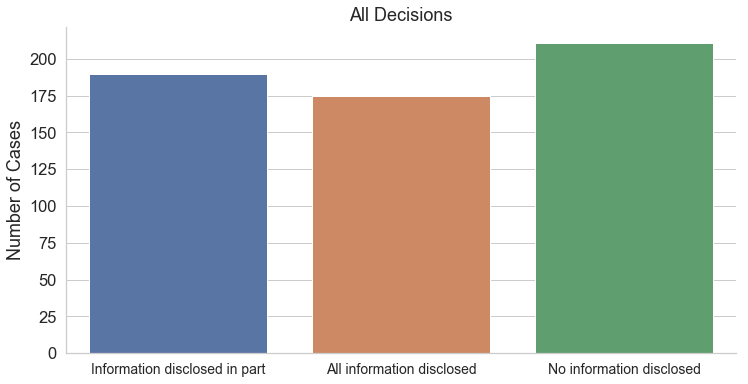

In [2852]:
columns_sub = []
for i in range(0,tokenized_adf.Sub_Decision.nunique()):
    columns_sub.append(tokenized_adf.Sub_Decision.unique()[i])

tokenized_adf_groupby_Sub_Decision = tokenized_adf.groupby('Sub_Decision').count()[['Source']]

fig, ax = plt.subplots(figsize=(12, 6))
sns.set(style="whitegrid", font_scale=1.5)
sns.despine()
ax = sns.barplot(x=columns_sub, y='Source', data=tokenized_adf_groupby_Sub_Decision)
ax.set(ylabel='Number of Cases', title='All Decisions')
plt.xticks(rotation=0, fontsize=14)

And now our set seems more balanced.

### Model comparison, 3-bin case

Let's compare eight different classifiers with two vectorizers, CountVectorizer and tf-idf.

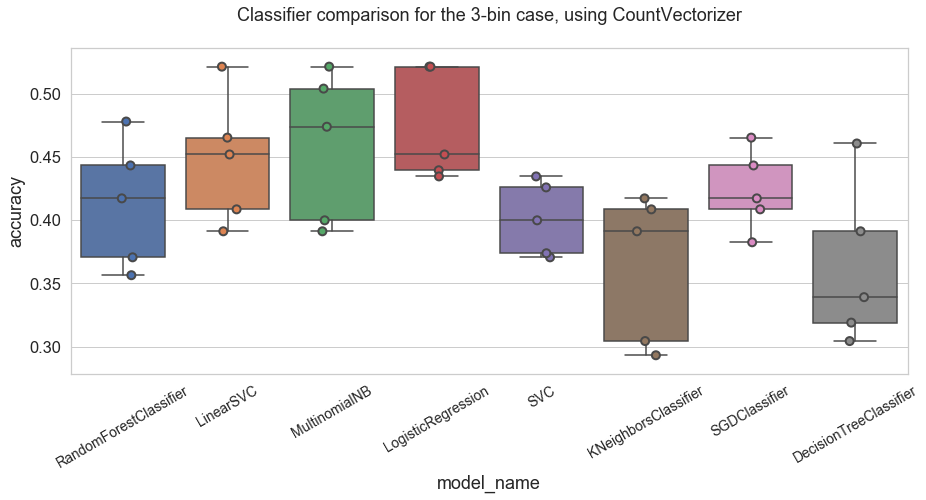

Acc., 3b, CVec
model_name                            
DecisionTreeClassifier        0.362924
KNeighborsClassifier          0.362969
LinearSVC                     0.447886
LogisticRegression            0.474018
MultinomialNB                 0.458306
RandomForestClassifier        0.413268
SGDClassifier                 0.423538
SVC                           0.401094

In [2874]:
acc_df5 = compare_ML_models(tokenized_adf, 'Edited_Summary', 'Sub_Decision', 
              'count_vectorizer', 
              5,
              42,
              False,
              'Classifier comparison for the 3-bin case, using CountVectorizer\n', 
              'Acc., 3b, CVec')
#accuracy_dfs.append(acc_df5)
acc_df5

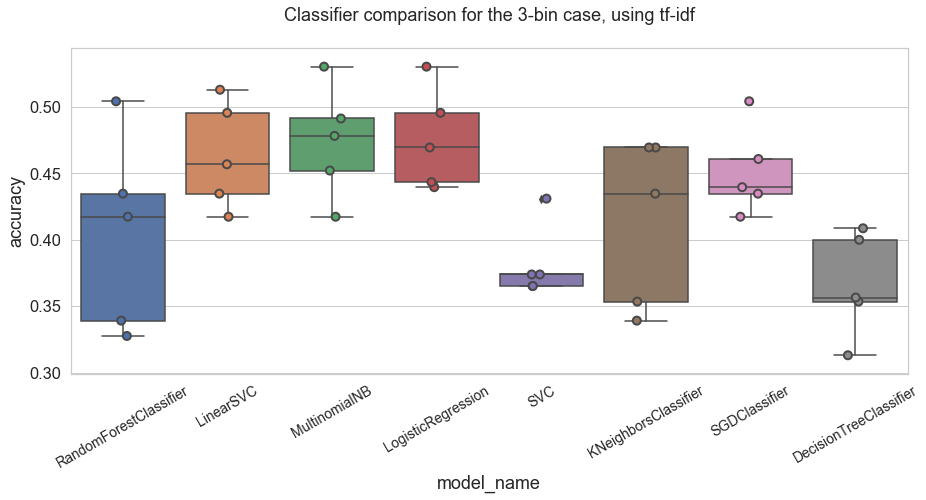

Acc., 3b, tf-idf
model_name                              
DecisionTreeClassifier          0.366342
KNeighborsClassifier            0.413298
LinearSVC                       0.463553
LogisticRegression              0.475757
MultinomialNB                   0.473928
RandomForestClassifier          0.404648
SGDClassifier                   0.451409
SVC                             0.381859

In [2927]:
acc_df6 = compare_ML_models(tokenized_adf, 'Edited_Summary', 'Sub_Decision', 
              'tfidf_vectorizer', 
              5,
              42,
              False,
              'Classifier comparison for the 3-bin case, using tf-idf\n', 
              'Acc., 3b, tf-idf')
#accuracy_dfs.append(acc_df6)
acc_df6

It seems like LogisticRegression with tf-idf does slightly better this time. Let's find the best parameters and take a look at the confusion matrix and the scores.

In [2855]:
y_s = tokenized_adf['Sub_Decision']
X_s = tokenized_adf['Edited_Summary']
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, test_size=0.33, random_state=42)

### GridSearch for LogisticRegression - tf-idf

Finding parameters.

In [2861]:
# tf-idf
tfidf_vect = TfidfVectorizer()
tfidf_clf = LogisticRegression(random_state=42)
tfidf_pipe = Pipeline([
                      ('vectorizer', tfidf_vect),
                      ('clf', tfidf_clf)
                      ])

parameters = {'vectorizer__ngram_range': [(1, 2), (1, 3), (1, 4)],
              'clf__penalty' : ['l1', 'l2'],
              'clf__C' : np.logspace(-4, 4, 20),
              'clf__solver' : ['liblinear']
             }

gs_clf = GridSearchCV(tfidf_pipe, parameters, cv=5)
gs_clf = gs_clf.fit(X_s_train, y_s_train)
print("For MultinomialNB Classifier with tf-idf:\n")
print("Best score: ", gs_clf.best_score_)
for param_name in sorted(parameters.keys()):
    print("{0}: {1}".format(param_name, gs_clf.best_params_[param_name]))


For MultinomialNB Classifier with tf-idf:

Best score:  0.5142857142857142
clf__C: 78.47599703514607
clf__penalty: l2
clf__solver: liblinear
vectorizer__ngram_range: (1, 4)


Running our model with the parameters just found.

In [2860]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 4))
tfidf_clf = LogisticRegression(C=78.47, penalty='l2', solver='liblinear', random_state=42)
tfidf_pipe.fit(X_s_train, y_s_train)
tfidf_preds = tfidf_pipe.predict(X_s_test)
print("LogisticRegression Accuracy - tfidf - 3 bins:", accuracy_score(y_s_test, tfidf_preds))

LogisticRegression Accuracy - tfidf - 3 bins: 0.44502617801047123


Finding confusion matrix and report.

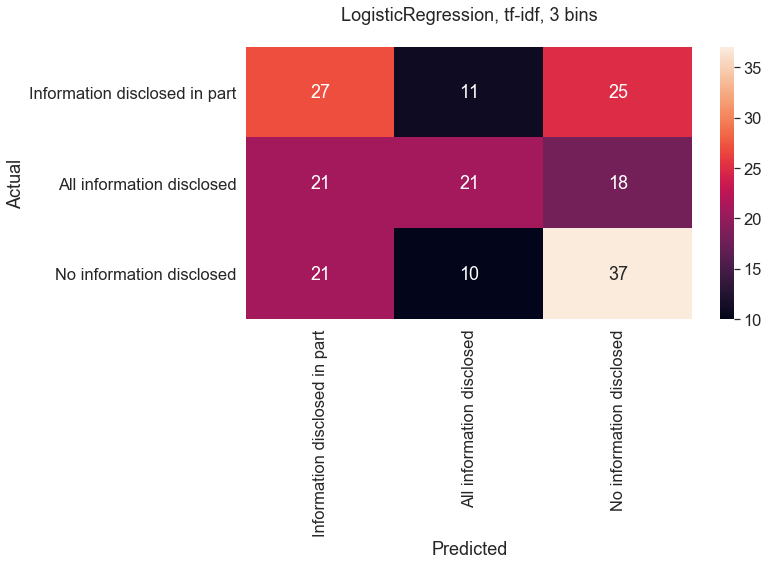

                               precision    recall  f1-score   support

Information disclosed in part       0.39      0.43      0.41        63
    All information disclosed       0.50      0.35      0.41        60
     No information disclosed       0.46      0.54      0.50        68

                    micro avg       0.45      0.45      0.45       191
                    macro avg       0.45      0.44      0.44       191
                 weighted avg       0.45      0.45      0.44       191



In [2240]:
display_confusion_matrix_w_report(y_s_test, tfidf_preds,
                         tokenized_adf, 'Sub_Decision',
                         'LogisticRegression, tf-idf, 3 bins\n')

## c) Removing cases with less than 15 cases and where a decision was not made

Let's call this dataframe 'independent'. Removing *'Withdrawn'* or *'Abandoned'* leaves us with 483 out of 576 total requests.

In [2242]:
tokenized_adf_indep = tokenized_adf_over15.copy()

In [2243]:
tokenized_adf_indep = tokenized_adf_indep[tokenized_adf_indep.Decision != 'Request withdrawn']

In [2244]:
tokenized_adf_indep = tokenized_adf_indep[tokenized_adf_indep.Decision != 'Abandoned']

In [2245]:
print(tokenized_adf_indep['Decision'].value_counts())

All information disclosed        189
Information disclosed in part    152
No records exist                  80
Partly non-existent               23
No information disclosed          21
Transferred                       15
Name: Decision, dtype: int64


In [2246]:
len(tokenized_adf_indep)

480

In [2247]:
len(tokenized_adf)

576

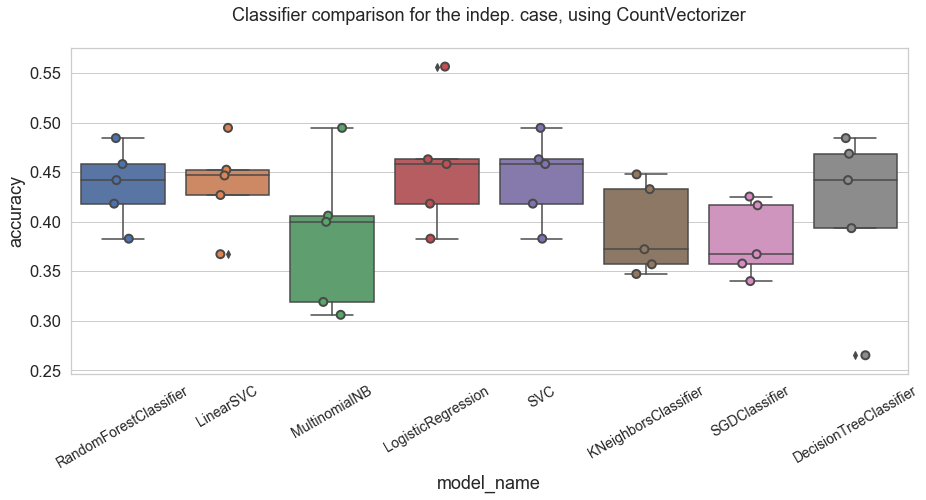

Acc., Ind., CVec
model_name                              
DecisionTreeClassifier          0.410863
KNeighborsClassifier            0.391552
LinearSVC                       0.437743
LogisticRegression              0.455908
MultinomialNB                   0.385273
RandomForestClassifier          0.437264
SGDClassifier                   0.381529
SVC                             0.443537

In [2876]:
acc_df7 = compare_ML_models(tokenized_adf_indep, 'Edited_Summary', 'Decision', 
              'count_vectorizer', 
              5,
              42,
              False,
              'Classifier comparison for the indep. case, using CountVectorizer\n', 
              'Acc., Ind., CVec')
accuracy_dfs.append(acc_df7)
acc_df7

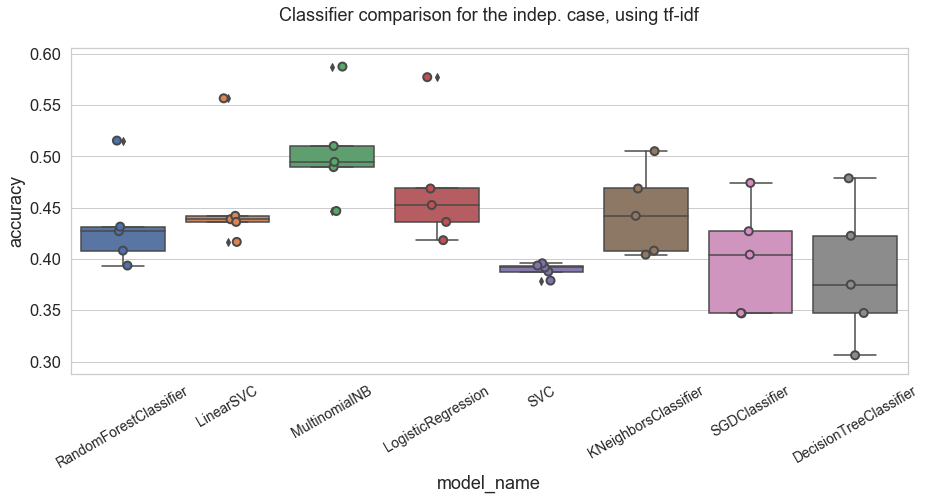

Acc., Ind., tf-idf
model_name                                
DecisionTreeClassifier            0.385979
KNeighborsClassifier              0.445686
LinearSVC                         0.458084
LogisticRegression                0.470648
MultinomialNB                     0.505792
RandomForestClassifier            0.435181
SGDClassifier                     0.399975
SVC                               0.389581

In [2877]:
acc_df8 = compare_ML_models(tokenized_adf_indep, 'Edited_Summary', 'Decision', 
              'tfidf_vectorizer', 
              5,
              42,
              False,
              'Classifier comparison for the indep. case, using tf-idf\n', 
              'Acc., Ind., tf-idf')
accuracy_dfs.append(acc_df8)
acc_df8

It seems like MultinomialNB with tf-idf does better this time. Let's find the best parameters and take a look at the confusion matrix and the scores.

### GridSearch for MultinomialNB - tf-idf

Finding parameters.

In [2864]:
y_i = tokenized_adf_indep['Decision']
X2 = tokenized_adf_indep['Edited_Summary']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y_i, test_size=0.33, random_state=42)

In [2866]:
tfidf_vect = TfidfVectorizer()
tfidf_clf = MultinomialNB()
tfidf_pipe = Pipeline([
                      ('vectorizer', tfidf_vect),
                      ('clf', tfidf_clf)
                      ])

parameters = {'vectorizer__ngram_range': [(1, 2), (1, 3), (1, 4)],
              'clf__alpha': (1, 1e-1, 1e-2, 1e-3)
             }

gs_clf = GridSearchCV(tfidf_pipe, parameters, cv=5)
gs_clf = gs_clf.fit(X2_train, y2_train)

print("For MultinomialNB Classifier with tf-idf:\n")
print("Best score: ", gs_clf.best_score_)
for param_name in sorted(parameters.keys()):
    print("{0}: {1}".format(param_name, gs_clf.best_params_[param_name]))


For MultinomialNB Classifier with tf-idf:

Best score:  0.4766355140186916
clf__alpha: 0.1
vectorizer__ngram_range: (1, 4)


Running our model with the parameters just found.

In [2252]:
tfidf_vect = TfidfVectorizer(ngram_range=(1, 4))
tfidf_clf = MultinomialNB(alpha=0.1)
tfidf_pipe.fit(X2_train, y2_train)
tfidf_preds = tfidf_pipe.predict(X2_test)
print("MultinomialNB Accuracy - tfidf - indep:", accuracy_score(y2_test, tfidf_preds))

MultinomialNB Accuracy - tfidf - indep: 0.49056603773584906


Finding confusion matrix and report.

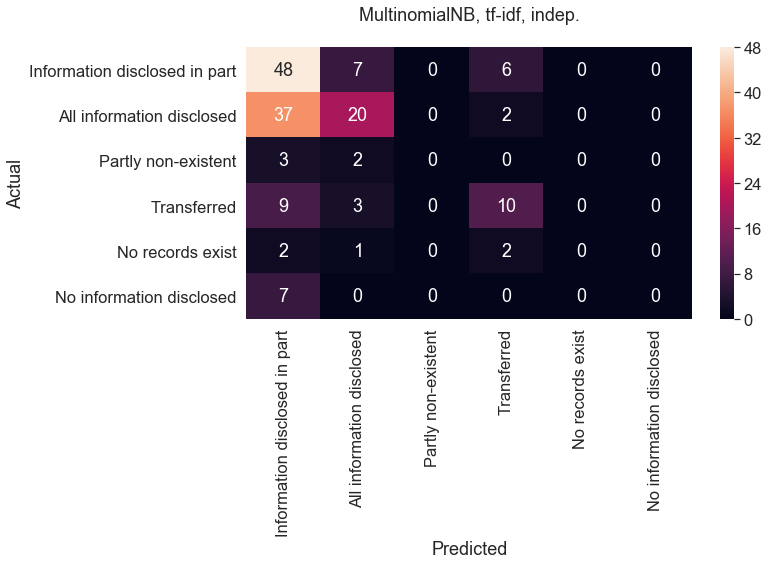

                               precision    recall  f1-score   support

Information disclosed in part       0.45      0.79      0.57        61
    All information disclosed       0.61      0.34      0.43        59
          Partly non-existent       0.00      0.00      0.00         5
                  Transferred       0.50      0.45      0.48        22
             No records exist       0.00      0.00      0.00         5
     No information disclosed       0.00      0.00      0.00         7

                    micro avg       0.49      0.49      0.49       159
                    macro avg       0.26      0.26      0.25       159
                 weighted avg       0.47      0.49      0.45       159



In [2254]:
display_confusion_matrix_w_report(y2_test, tfidf_preds,
                                  tokenized_adf_indep, 'Decision',
                         '        MultinomialNB, tf-idf, indep.\n')

And putting all the accuracy scores together, and giving it some *Style* to make the results clearer.

In [2878]:
accuracies_all = pd.DataFrame()

In [2879]:
accuracies_all = pd.concat(accuracy_dfs, axis=1)

In [2880]:
accuracies_all

Acc., ov15, CVec  Acc., ov15, CVec, bal.  \
model_name                                                         
DecisionTreeClassifier          0.330835                0.262381   
KNeighborsClassifier            0.332115                0.332115   
LinearSVC                       0.360738                0.326804   
LogisticRegression              0.390923                0.344536   
MultinomialNB                   0.349955                0.349955   
RandomForestClassifier          0.385968                0.283998   
SGDClassifier                   0.339626                0.302021   
SVC                             0.381945                0.215925   

                        Acc., o15, tf-idf  Acc., o15, tf-idf, bal.  \
model_name                                                           
DecisionTreeClassifier           0.314668                 0.285715   
KNeighborsClassifier             0.369461                 0.369461   
LinearSVC                        0.389363                 0.335767   
LogisticRegression               0.399917                 0.391149   
MultinomialNB                    0.430138                 0.430138   
RandomForestClassifier           0.382412                 0.303760   
SGDClassifier                    0.330647                 0.339450   
SVC                              0.337522                 0.234153   

                        Acc., 3b, CVec  Acc., 3b, tf-idf  Acc., Ind., CVec  \
model_name                                                                   
DecisionTreeClassifier        0.362924          0.366342          0.410863   
KNeighborsClassifier          0.362969          0.413298          0.391552   
LinearSVC                     0.447886          0.463553          0.437743   
LogisticRegression            0.474018          0.475757          0.455908   
MultinomialNB                 0.458306          0.473928          0.385273   
RandomForestClassifier        0.413268          0.404648          0.437264   
SGDClassifier                 0.423538          0.451409          0.381529   
SVC                           0.401094          0.381859          0.443537   

                        Acc., Ind., tf-idf  
model_name                                  
DecisionTreeClassifier            0.385979  
KNeighborsClassifier              0.445686  
LinearSVC                         0.458084  
LogisticRegression                0.470648  
MultinomialNB                     0.505792  
RandomForestClassifier            0.435181  
SGDClassifier                     0.399975  
SVC                               0.389581

Adding some functions that will *style* and color the dataframe.

In [2881]:
def color_above45_green(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: green'` for above 0.45
    strings, black otherwise.
    """
    color = 'green' if val > 0.45 else 'black'
    return 'color: %s' % color

In [2882]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [2883]:
caption = 'Accuracy score for all the eight models, and 3 different cases\
         (ov15: over 15 requests, 3b: All decisions split into three bins,\
         Ind.: over 15 and w/o Withdrawns and Abandoned.)\
         We also considered two different vectorizers, CountVectorizer (CVec) and tf-idf.\
         Highest score per case is highlighted in yellow. Scores above 45% are shown in green.'
s = accuracies_all.style.\
    applymap(color_above45_green).\
    apply(highlight_max).\
    set_caption(caption)
s

__We see that even though our results are not good (50% is the highest!), in general, for this case, Logistic Regression and Multinomial Naive Bayes classifiers, combined with tf-idf, worked best, as well as reducing the number of 'Decisions'.__